In [1]:
from statistics import mean, median, stdev
from os.path import basename, dirname, splitext, join
import shutil
from pandas import read_csv
from glob import glob
from datetime import datetime
from itertools import chain
import re # import match, finditer
from DNASkittleUtils.Contigs import read_contigs, Contig, write_contigs_to_file, just_the_name
from DNASkittleUtils.DDVUtils import chunks, pp
from Bio.Seq import translate
from collections import defaultdict

In [64]:
def first(iterable):
    if isinstance(iterable, dict):
        return next(iter(iterable.items()))
    return next(iter(iterable))

# Listing and Moving OG sequences that contain at least 2 FRAX genes

In [2]:
def move_study_ogs_to_folder():
    ogs = set()
    for fname in glob(r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ogs\Jun25\Sequences\aligned\*.fa"):
        with open(fname, 'r') as og_file:
            frax_genes = 0
            pattern = re.compile(r'^>FRAX')
            for line in og_file.readlines():
                for match in re.finditer(pattern, line):
                    frax_genes += 1
                    if frax_genes >= 2:
                        ogs.add(basename(fname))
                        break
    print(len(ogs))
    # Move files for study
    # for fname in ogs:
    #     src = join(r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ogs\Jun25\Sequences\aligned", fname)
    #     dest = join(r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ogs\Jun25\Sequences\aligned\for_study", fname)
    #     shutil.move(src, dest)
    return ogs

# Retrieving Pairs of Protein and CDS DNA 

Read all CDS into a dictionary by FRAX name

In [3]:
cds_all = {}
base_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ogs\Jun25\Sequences"
for fname in glob(join(base_dir, "aligned/for_study/CDS/*.fna")): 
    frax_name = just_the_name(fname).replace('_CDS', '')
    cds_all[frax_name] = {c.name.split()[0]: c.seq for c in read_contigs(fname)}
print(len(cds_all), "cds_all species" )
print('FRAX34 has', len(cds_all['FRAX34']),'genes')

30 cds_all species
FRAX34 has 31839 genes


In [6]:
cds_all.keys()

dict_keys(['FRAX16', 'FRAX26', 'FRAX08', 'FRAX21', 'FRAX29', 'FRAX01', 'FRAX31', 'FRAX14', 'FRAX03', 'FRAX02', 'FRAX23', 'FRAX34', 'FRAX32', 'FRAX30', 'FRAX12', 'FRAX25', 'FRAX28', 'FRAX20', 'FRAX11', 'FRAX33', 'FRAX19', 'FRAX15', 'FRAX13', 'FRAX07', 'FRAX05', 'FRAX00', 'FRAX04', 'FRAX27', 'FRAX06', 'FRAX09'])

In [7]:
og_prot ={}
proteins = {}

In [8]:
for index, fname in enumerate(glob(join(base_dir, "aligned/for_study/*.fa"))):  #for_study/
    if just_the_name(fname) in og_prot:
        continue
    prot_contigs = read_contigs(fname)
    # TODO: extract from gene_name
    og_prot[just_the_name(fname)] = {c.name for c in prot_contigs}
    if index % 1000 == 0:
        print(basename(fname))
    for c in prot_contigs:
#         print(c.name)
        if c.name not in proteins:
            proteins[c.name] = c.seq
        else:
            print("--Conflict--", c.name)

OG0000000.fa
OG0001000.fa
OG0002000.fa
OG0003001.fa
OG0004002.fa
OG0005003.fa
OG0006003.fa
OG0007003.fa
OG0008004.fa
OG0009005.fa
OG0010005.fa
OG0011005.fa
OG0012007.fa
OG0013010.fa
OG0014012.fa
OG0015015.fa
OG0016017.fa
OG0017019.fa
OG0018023.fa
OG0019031.fa
OG0020047.fa
OG0021088.fa
OG0022138.fa
OG0023212.fa
OG0024429.fa
OG0025459.fa
OG0026795.fa
OG0027903.fa


In [152]:
gene_to_og = {gene_name: og for og, genes in og_prot.items() for gene_name in genes}

In [9]:
for gene in cds_all['FRAX34']:
    if '000102120' in gene:
        print(gene)

FRAX34_000102120.2_R0
FRAX34_000102120.1_R1


Aligned is 27 AA longer because of gaps

This FRAX33 gene doesn't have gaps

Extract the paired sequences and use in alignment function

In [10]:
def fetch_dna_for_gene(gene_name):
    sep = gene_name.index('_')
    species = gene_name[:sep]
    if species in cds_all:
        return cds_all[species][gene_name[sep+1:]]
    else:
        raise ValueError(species)
    
fetch_dna_for_gene('FRAX34_FRAX34_000102120.1_R1')
def fetch_sequence_pair(gene_name, ignore_length=False):
    dna, prot = fetch_dna_for_gene(gene_name), proteins[gene_name]
    ungapped_prot = prot.replace('-', '')
    if len(dna) // 3 == len(ungapped_prot)+1  or ignore_length:
        return dna, prot
    else: 
        if len(translate(dna).replace('*','')) == len(ungapped_prot):
            #contains ignore stop codons
            #TODO remove these stop codons because they'll cause (sort of) read shifts in the alignment
            translation = translate(dna).replace('*','')
            stops = [m.start() for m in re.finditer('\*', translation)]
            stops = chain(*([s*3 for s in stops], [s*3+1 for s in stops], [s*3+2 for s in stops]))
            goods = (dna[i] for i in range(len(dna)) if i not in stops)
            cleaned = ''.join(goods)
            return cleaned, prot
        raise IndexError(gene_name + " not the same lengths: %i and %i" % (len(dna) // 3, len(ungapped_prot)))
fetch_sequence_pair('FRAX34_FRAX34_000102120.1_R1')

('ATGTGTGACTTTGGAAAGCAACTCTTTGTACTATCCATGCGGAATCACAACCTGGAACCTGTGGAACTAAATGCTATGTGGCACAAAGTAGGTGCCACCTTTAGAATCCCGCATCTTGATGCATGTTCTTCTGTGTTTGCCGATGACCAAATCATCATAGCAAACAGTGGACCTAATTCTAATGGGTGTCAGTTCTTCATCACCTGTGCGAAGTGCGACTGGCTTGACAATAAGCATGTTGTTTTCGGGCGTGTGCTTGGAGATGGTCTTTTGGTTGCAAGGAAGATTGAGAATGTGGCGACGGGACCCAACAACCGGCCTAAATTGGCTTGTGTTATTGCTGAATGTGGAGAGATGTAA',
 'MC---------DFGKQLFVLSM-----------RNHNLEPVELNAMWHKVGATFRIPH-----LDAC---SSVFADDQIIIANSGPNSNGCQFFITCAKCDWLDNKHVVFGRVLGDGLLVARKIENVATGPNNRPKLACVIAECGEM')

# Use MSA to align nucleotides

In [11]:
def align_cds_using_prot(cds, prot_seq):
    from itertools import chain
    #use protein alignment on cds
    triple_seq = chain(*[(c,c,c) for c in prot_seq])
    aligned_cds = []
    cds_iter = iter(cds)
    for c in triple_seq:
        try:
            if c == '-':
                aligned_cds.append("-")
            else:
                aligned_cds.append(next(cds_iter))
        except StopIteration:
            print((cds, prot_seq))
            raise
    return ''.join(aligned_cds)

def align_dna(gene_name):
    cds, prot_seq = fetch_sequence_pair(gene_name)
    if cds:
        return align_cds_using_prot(cds, prot_seq)
    else: 
        return None


align_dna('FRAX34_FRAX34_000102120.1_R1')

'ATGTGT---------------------------GACTTTGGAAAGCAACTCTTTGTACTATCCATG---------------------------------CGGAATCACAACCTGGAACCTGTGGAACTAAATGCTATGTGGCACAAAGTAGGTGCCACCTTTAGAATCCCGCAT---------------CTTGATGCATGT---------TCTTCTGTGTTTGCCGATGACCAAATCATCATAGCAAACAGTGGACCTAATTCTAATGGGTGTCAGTTCTTCATCACCTGTGCGAAGTGCGACTGGCTTGACAATAAGCATGTTGTTTTCGGGCGTGTGCTTGGAGATGGTCTTTTGGTTGCAAGGAAGATTGAGAATGTGGCGACGGGACCCAACAACCGGCCTAAATTGGCTTGTGTTATTGCTGAATGTGGAGAGATG'

In [153]:
def dna_aligned_OG(og_name):
    aligned_results = {}
    for gene_name in og_prot[og_name]:
        try:
            aligned_results[gene_name] = align_dna(gene_name)
        except ValueError as e:
            pass
#             print("Missing",e)
    return aligned_results

def dna_aligned_genes(gene_names):
    aligned_results = {}
    # check if all gene_names are in the same og
    ogs = [gene_to_og[gene] for gene in gene_names]
    if any([og != ogs[0] for og in ogs]):
        raise ValueError("Not all genes are in the same OG alignment", ogs)
    for gene_name in gene_names:
        try:
            aligned_results[gene_name] = align_dna(gene_name)
        except ValueError as e:
            pass
    return aligned_results
    
dna_aligned_OG('OG0024430')

{'FRAX00_FRAEX38873_v2_000313550.1': 'ATGTTATTCTTGTTTGGATACAATTTAGTTAGGTACCTGTCCAATTTTGGCTTTGATAGCCATCAGATGATCTTCACCAGTTTAATCTATAATATTCTTGCAACTAATCGATATATTTTCTTGTCAGTACATCACAATACGTATGCTGAGGACCCTTTTGCCAAGGAATTTGGAATTAAAATAAGAGAGAAGCTGGCTCAAGTTGAAGCTCGCATTTTGCCTGCTCCTTGGGGAGAAGAATTGTCTGCCCCAAGTTGGACAGTGGAATATGATGAACAAGTTCATATTCATCTATGCAGTTTGTTGTTGGATTGGGTGATAAAGTTTTGCCGACTGATATTG---AAGGAATGCAGAGTT------------------GGTGTTGACCGGAATAAATATCAAATTCAAATTCCCTTGCCTCCAAAAATTGATCCAAGTGTTACAATGATGGCAGTAGAGGAAAATCCAGATGTTACATATAATGATGTTGGAGGATGTAAGGAGCATATTGAAAAGATACGAGCAGTTGCTGGGCTATCCATGCTTCACCCTGAAAAATTTGTGAAGCTCGGGATCGATCCTCCAAATGGCGTTCTTTGTTATGGTCCTCCGGGTACTGGTAAAACTCTTCTTGCTAGAGCTGTAGCTAATCGAACCGATGCATGTTTTATTCGTGTTATTGGTAAGGAGCTTGTCCATAAATATGTTGGTGAGGAAGCTCGGATGGTTCATGAACTGTTTCAGATGGCACGTTCCAAAAAAGCTTGTATTGTGTTCTTTGATGAAGTGGATGCCATTGGAGCTCGGGATCGATCCTCCAAAGGGCGTTCTTTGTTATGGTTCTATGGTCCTCCGGTTACTGGTAAAACTCTTCTTGCTAGAGCTGTAGCTAATCGAATCGATGCATGTTTTATTCGTGTTATTGATAGGAAGCTTGTCCAGAAATATGTTGGTGAGGAAGC

In [158]:
dna_aligned_genes(['FRAX00_FRAEX38873_v2_000313550.1', 'FRAX23_FRAX23_000313250.1_R0']) #FRAX23_FRAX23_000313550.1_R0

ValueError: ('Not all genes are in the same OG alignment', ['OG0024430', 'OG0008212'])

**This test case OG0024430 could also be used an example of bias towards the FRAX00 Gemoma annotation source**

# 4DTv and Codon Tables

In [13]:
dna_to_protein = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
    'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W',
    }

In [14]:
fourDTv_codons = {'CTT':'L','CTC':'L','CTA':'L','CTG':'L',
'GTT':'V','GTC':'V','GTA':'V','GTG':'V',
'TCT':'S','TCC':'S','TCA':'S','TCG':'S',
'CCT':'P','CCC':'P','CCA':'P','CCG':'P',
'ACT':'T','ACC':'T','ACA':'T','ACG':'T',
'GCT':'A','GCC':'A','GCA':'A','GCG':'A',
'CGT':'R','CGC':'R','CGA':'R','CGG':'R',
'GGT':'G','GGC':'G','GGA':'G','GGG':'G'}  # This is DNA to protein, no U no revcomp

In [15]:
def build_synonymous(codons):
    synonyms = {} # of sets
    for key in codons:
        synonyms[key] = set() #{key}?
        for B in codons:
            if codons[key] == codons[B]:
                synonyms[key].add(B)
    return synonyms
synonyms = build_synonymous(dna_to_protein)

# Count Synonymous Sites

In [160]:
def count_synonymous_sites(ref, query):
    ref_codons, query_codons = chunks(ref, 3), chunks(query, 3)
    comp_pairs = zip(ref_codons, query_codons)
    
    opportunities = 0
    same = 0
    synonymous = 0
    nonsynonymous = 0
    four_fold_opportunities = 0
    four_fold_changes = 0
    for A, B in comp_pairs:
        if '-' not in A and '-' not in B and 'N' not in A and 'N' not in B:
            opportunities += 1
            if A in fourDTv_codons:
                four_fold_opportunities += 1
            if A == B:
                same += 1
            elif B in synonyms[A]:
                synonymous += 1
                if B in fourDTv_codons:
                    four_fold_changes += 1
            else:
                nonsynonymous += 1
    assert four_fold_changes <= synonymous, (four_fold_changes, synonymous)
    assert nonsynonymous + synonymous + same == opportunities, (nonsynonymous, synonymous, same, opportunities)
    assert four_fold_opportunities <= opportunities, (four_fold_opportunities, opportunities)
    if same < synonymous or same + synonymous < opportunities // 4:
        raise ValueError("Likely alignment error" + str([same, synonymous, opportunities]))
    return {'opportunities': opportunities,    'same': same,    'synonymous': synonymous,
        'nonsynonymous': nonsynonymous,    'four_fold_opportunities': four_fold_opportunities,
        'four_fold_changes': four_fold_changes}


In [128]:
OG0024430

{'FRAX00_FRAEX38873_v2_000313550.1': 'ATGTTATTCTTGTTTGGATACAATTTAGTTAGGTACCTGTCCAATTTTGGCTTTGATAGCCATCAGATGATCTTCACCAGTTTAATCTATAATATTCTTGCAACTAATCGATATATTTTCTTGTCAGTACATCACAATACGTATGCTGAGGACCCTTTTGCCAAGGAATTTGGAATTAAAATAAGAGAGAAGCTGGCTCAAGTTGAAGCTCGCATTTTGCCTGCTCCTTGGGGAGAAGAATTGTCTGCCCCAAGTTGGACAGTGGAATATGATGAACAAGTTCATATTCATCTATGCAGTTTGTTGTTGGATTGGGTGATAAAGTTTTGCCGACTGATATTG---AAGGAATGCAGAGTT------------------GGTGTTGACCGGAATAAATATCAAATTCAAATTCCCTTGCCTCCAAAAATTGATCCAAGTGTTACAATGATGGCAGTAGAGGAAAATCCAGATGTTACATATAATGATGTTGGAGGATGTAAGGAGCATATTGAAAAGATACGAGCAGTTGCTGGGCTATCCATGCTTCACCCTGAAAAATTTGTGAAGCTCGGGATCGATCCTCCAAATGGCGTTCTTTGTTATGGTCCTCCGGGTACTGGTAAAACTCTTCTTGCTAGAGCTGTAGCTAATCGAACCGATGCATGTTTTATTCGTGTTATTGGTAAGGAGCTTGTCCATAAATATGTTGGTGAGGAAGCTCGGATGGTTCATGAACTGTTTCAGATGGCACGTTCCAAAAAAGCTTGTATTGTGTTCTTTGATGAAGTGGATGCCATTGGAGCTCGGGATCGATCCTCCAAAGGGCGTTCTTTGTTATGGTTCTATGGTCCTCCGGTTACTGGTAAAACTCTTCTTGCTAGAGCTGTAGCTAATCGAATCGATGCATGTTTTATTCGTGTTATTGATAGGAAGCTTGTCCAGAAATATGTTGGTGAGGAAGC

In [129]:
ks_stats(OG0024430['FRAX00_FRAEX38873_v2_000313550.1'], OG0024430['FRAX06_FRAX06_000313550.1_R0'])

{'fourfold_ratio': 0.0707070707070707, 'ks_ratio': 0.05241935483870968}

In [130]:
ks_stats(OG0024430['FRAX06_FRAX06_000313550.1_R0'], OG0024430['FRAX23_FRAX23_000313550.1_R0'])

{'fourfold_ratio': 0.06666666666666667, 'ks_ratio': 0.03825136612021858}

In [131]:
ks_stats(OG0024430['FRAX00_FRAEX38873_v2_000313550.1'], OG0024430['FRAX23_FRAX23_000313550.1_R0'])

{'fourfold_ratio': 0.05952380952380952, 'ks_ratio': 0.041237113402061855}

In [18]:
OG0024430 = dna_aligned_OG('OG0024430')
print(OG0024430.keys())
count_synonymous_sites(OG0024430['FRAX00_FRAEX38873_v2_000313550.1'], OG0024430['FRAX06_FRAX06_000313550.1_R0'])

dict_keys(['FRAX00_FRAEX38873_v2_000313550.1', 'FRAX06_FRAX06_000313550.1_R0', 'FRAX23_FRAX23_000313550.1_R0'])


{'four_fold_changes': 7,
 'four_fold_opportunities': 99,
 'opportunities': 248,
 'same': 187,
 'synonymous': 13,
 'transversions': 48}

In [22]:
from itertools import combinations
[a for a in combinations('a b c d'.split(), 2)]

[('a', 'b'), ('a', 'c'), ('a', 'd'), ('b', 'c'), ('b', 'd'), ('c', 'd')]

In [47]:
og_prot['OG0013251']

{'FRAX00_FRAEX38873_v2_000058770.1',
 'FRAX02_FRAX02_000058770.1_R0',
 'FRAX02_FRAX02_000058770.1_R1',
 'FRAX02_FRAX02_000058770.1_R3',
 'FRAX05_FRAX05_000058770.1_R0',
 'FRAX07_FRAX07_000058770.1_R1',
 'FRAX07_FRAX07_000058770.1_R2',
 'FRAX07_FRAX07_000058770.1_R3',
 'FRAX08_FRAX08_000058770.1_R1',
 'FRAX09_FRAX09_000058770.1_R0',
 'FRAX11_FRAX11_000058770.1_R0',
 'FRAX12_FRAX12_000058770.1_R0',
 'FRAX13_FRAX13_000058770.1_R0',
 'FRAX21_FRAX21_000058770.1_R0',
 'FRAX27_FRAX27_000058770.1_R0',
 'FRAX28_FRAX28_000058770.1_R0',
 'FRAX28_FRAX28_000058770.1_R1',
 'FRAX28_FRAX28_000058770.1_R2',
 'FRAX29_FRAX29_000058770.1_R0',
 'FRAX29_FRAX29_000058770.1_R2',
 'FRAX29_FRAX29_000058770.1_R3',
 'FRAX29_FRAX29_000058770.1_R4',
 'FRAX30_FRAX30_000058770.1_R1',
 'FRAX30_FRAX30_000058770.1_R2',
 'FRAX32_FRAX32_000058770.1_R0',
 'FRAX32_FRAX32_000058770.1_R1',
 'FRAX32_FRAX32_000058770.1_R3',
 'FRAX33_FRAX33_000058770.1_R0',
 'FRAX34_FRAX34_000058770.1_R0',
 'Mguttatus_Migut.C01135.1.p',
 'Oeurop

In [58]:
gene_prefixes = 'FRAX00 FRAX01 FRAX02 FRAX03 FRAX04 FRAX05 FRAX06 FRAX07 FRAX08 FRAX09 FRAX11 FRAX12 FRAX13 FRAX14 FRAX15 FRAX16 FRAX19 FRAX20 FRAX21 FRAX23 FRAX25 FRAX26 FRAX27 FRAX28 FRAX29 FRAX30 FRAX31 FRAX32 FRAX33 FRAX34'.split()

def paralog_pairs(og_name):
    #precheck paralog existence
    by_species = separate_genes_by_species(og_prot[og_name])
    paralogs = [genes for species, genes in by_species.items() if len(genes) > 1]
    seqs = dna_aligned_genes(set(chain(*paralogs)))  # only computed for paralogs alignment 
    pairs = []
    for species, genes in by_species.items():
        if len(genes) > 1:
            for ref, query in combinations(genes, 2):
                pairs.append((Contig(ref, seqs[ref]), Contig(query, seqs[query])))
    return pairs
    
def separate_genes_by_species(gene_names):
    by_species = defaultdict(lambda: list())
    black_list = {'Oeurop','Mgutta','Slycop', 'FRAX02', 'FRAX34'}  # Excluding hybrid FRAX02 and Polyploid FRAX34
    for gene in gene_names:
        name = gene[0] if len(gene) == 2 else gene # if you got a pair, take the first
        if name[:6] not in black_list:
            by_species[name[:6]].append(gene)
    return by_species

paralog_pairs('OG0014415')

[(< "FRAX06_FRAX06_000165250.1_R0" 1119 nucleotides>,
  < "FRAX06_FRAX06_000165250.1_R1" 1119 nucleotides>),
 (< "FRAX12_FRAX12_000165250.1_R0" 1119 nucleotides>,
  < "FRAX12_FRAX12_000165250.1_R1" 1119 nucleotides>),
 (< "FRAX12_FRAX12_000165250.1_R0" 1119 nucleotides>,
  < "FRAX12_FRAX12_000165250.1_R2" 1119 nucleotides>),
 (< "FRAX12_FRAX12_000165250.1_R1" 1119 nucleotides>,
  < "FRAX12_FRAX12_000165250.1_R2" 1119 nucleotides>)]

In [54]:
def ks_stat_pairs(pairs):
    return {(pair[0].name, pair[1].name): ks_stats(pair[0].seq, pair[1].seq) for pair in pairs}

def ks_stats(A, B):
    stats = count_synonymous_sites(A,B)
    ks_ratio = stats['synonymous'] / stats['opportunities'] if stats['opportunities'] else 0
    fourfold_ratio = stats['four_fold_changes'] / stats['four_fold_opportunities'] if stats['four_fold_opportunities'] else 0
    return {'ks_ratio':ks_ratio, 'fourfold_ratio':fourfold_ratio}

In [55]:
ks_stat_pairs(paralog_pairs('OG0013251'))

{('FRAX07_FRAX07_000058770.1_R1',
  'FRAX07_FRAX07_000058770.1_R3'): {'fourfold_ratio': 0.11764705882352941, 'ks_ratio': 0.0784313725490196},
 ('FRAX07_FRAX07_000058770.1_R2',
  'FRAX07_FRAX07_000058770.1_R1'): {'fourfold_ratio': 0.11538461538461539, 'ks_ratio': 0.043478260869565216},
 ('FRAX07_FRAX07_000058770.1_R2',
  'FRAX07_FRAX07_000058770.1_R3'): {'fourfold_ratio': 0.125, 'ks_ratio': 0.0784313725490196},
 ('FRAX28_FRAX28_000058770.1_R0',
  'FRAX28_FRAX28_000058770.1_R2'): {'fourfold_ratio': 0.07894736842105263, 'ks_ratio': 0.05063291139240506},
 ('FRAX28_FRAX28_000058770.1_R1',
  'FRAX28_FRAX28_000058770.1_R0'): {'fourfold_ratio': 0.08108108108108109, 'ks_ratio': 0.1},
 ('FRAX28_FRAX28_000058770.1_R1',
  'FRAX28_FRAX28_000058770.1_R2'): {'fourfold_ratio': 0.058823529411764705, 'ks_ratio': 0.06493506493506493},
 ('FRAX29_FRAX29_000058770.1_R0',
  'FRAX29_FRAX29_000058770.1_R2'): {'fourfold_ratio': 0.14285714285714285, 'ks_ratio': 0.08},
 ('FRAX29_FRAX29_000058770.1_R0',
  'FRAX29_

In [56]:
all_og_pairs = {}

In [57]:
for count, og_name in enumerate(og_prot):
    try:
        if og_name not in all_og_pairs:
            all_og_pairs[og_name] = paralog_pairs(og_name)
        if count % 1000 == 0:
            print(og_name, count)
    except KeyError:
        pass  # There wasn't a FRAX00 entry to serve as spoke

OG0011716 0


d:\josiah\projects\jupyter\lib\site-packages\Bio\Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


OG0009793 1000
OG0004709 2000
OG0007839 3000
OG0025267 4000
OG0006653 5000
OG0003911 6000
OG0018097 7000
OG0012690 8000
OG0026090 9000
OG0020767 10000
OG0026377 11000
OG0011616 12000
OG0017959 13000
OG0024172 14000
OG0012476 15000
OG0020026 16000
OG0010972 17000
OG0002054 18000
OG0005327 19000
OG0019696 20000
OG0015087 21000
OG0020259 22000
OG0017612 23000
OG0002819 24000
OG0017325 25000
OG0007692 26000
OG0006176 27000


Outdated code tests  
assert any(n for n in og_prot['OG0023444'] if 'FRAEX38873' in n)

missing_FRAX00 = {og_name for og_name in og_prot if not any(n for n in og_prot[og_name] if 'FRAEX38873' in n)}
assert len(og_prot) - len(all_og_pairs) - len(missing_FRAX00) == 0
;# Ensures that the only skipped OGs are from lack of a FRAX00 reference


# Make a file output for aligned DNA

In [45]:
from DDVUtils import write_contigs_to_file

def output_dna_MSA_files():
    dna_path = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ogs\Jun25\Sequences\aligned\for_study\dna_aligned"
    for og_name, pairs in all_og_pairs.items():
        reference = next(iter(pairs))[0]
        #TODO: change storage to conform to write_contigs_to_file
        contigs = [pair[1] for pair in pairs]
        contigs.insert(0, reference)
        write_contigs_to_file(join(dna_path, og_name + '.fa'), contigs, verbose=False)
# output_dna_MSA_files()

#### Reshuffling of alll_og_pairs to be sorted by species
Useful for per species Ks plots as well as finding the file to look up orthologs in

In [62]:
first(all_og_pairs)

('OG0011716',
 [(< "FRAX28_FRAX28_000145350.2_R0" 1047 nucleotides>,
   < "FRAX28_FRAX28_000145350.1_R1" 1047 nucleotides>),
  (< "FRAX33_FRAX33_000145350.2_R0" 1047 nucleotides>,
   < "FRAX33_FRAX33_000145350.1_R1" 1047 nucleotides>),
  (< "FRAX07_FRAX07_000145350.2_R0" 1047 nucleotides>,
   < "FRAX07_FRAX07_000145350.1_R1" 1047 nucleotides>),
  (< "FRAX09_FRAX09_000145350.1_R1" 1047 nucleotides>,
   < "FRAX09_FRAX09_000145350.2_R0" 1047 nucleotides>)])

all_ks_stats = {og_name: ks_stat_pairs(og) for og_name, og in all_og_pairs.items()}

len(all_ks_stats) == len(all_og_pairs)

In [177]:
paralogs_by_species = defaultdict(lambda: set())
for list_of_pairs in all_og_pairs.values():
    for pair in list_of_pairs:
        paralogs_by_species[pair[0].name[:6]].add(pair)
len(paralogs_by_species), len(first(paralogs_by_species.values()))

(28, 23986)

**Note:** consider running `collect_stats_for_all_valid_pairs` instead of ks_paralogs_by_species

In [100]:
ks_paralogs_by_species = {species: ks_stat_pairs(pairs) for species, pairs in paralogs_by_species.items()}

In [101]:
len(ks_paralogs_by_species), len(first(ks_paralogs_by_species))

(28, 2)

In [102]:
ks_paralogs_by_species.keys()

dict_keys(['FRAX16', 'FRAX26', 'FRAX08', 'FRAX21', 'FRAX29', 'FRAX28', 'FRAX31', 'FRAX14', 'FRAX01', 'FRAX23', 'FRAX32', 'FRAX04', 'FRAX12', 'FRAX11', 'FRAX20', 'FRAX25', 'FRAX09', 'FRAX33', 'FRAX19', 'FRAX15', 'FRAX13', 'FRAX07', 'FRAX05', 'FRAX00', 'FRAX30', 'FRAX27', 'FRAX06', 'FRAX03'])

In [99]:
first(first(ks_paralogs_by_species.values()))

(('FRAX28_FRAX28_000145350.2_R0', 'FRAX28_FRAX28_000145350.1_R1'),
 {'fourfold_ratio': 0.24285714285714285, 'ks_ratio': 0.18055555555555555})

In [73]:
import pickle
with open('ks_paralogs_by_species.pickle', 'wb') as handle:
    pickle.dump(ks_paralogs_by_species, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('paralogs_by_species.pickle', 'wb') as handle:
    pickle.dump(dict(paralogs_by_species), handle, protocol=pickle.HIGHEST_PROTOCOL)

At this point we ostensibly have Ks scores for every valid paralog pair within every FRAX species.  We should now be able to make a Ks plot of all genes for each species, then select a WGD window Ks threshold and start the Ortholog transfer.

### Verifying My Ks Values are on the same scale as Lizzy's
I'm calculating Ks as the percentage of synonymous substitution opportunities actually contain substitutions. 

In [110]:
first(og_prot)

('OG0011716',
 {'FRAX00_FRAEX38873_v2_000145350.2',
  'FRAX01_FRAX01_000145350.2_R0',
  'FRAX02_FRAX02_000145350.1_R1',
  'FRAX02_FRAX02_000145350.2_R0',
  'FRAX04_FRAX04_000145350.2_R0',
  'FRAX05_FRAX05_000145350.2_R0',
  'FRAX06_FRAX06_000145350.2_R0',
  'FRAX07_FRAX07_000145350.1_R1',
  'FRAX07_FRAX07_000145350.2_R0',
  'FRAX08_FRAX08_000145350.2_R0',
  'FRAX09_FRAX09_000145350.1_R1',
  'FRAX09_FRAX09_000145350.2_R0',
  'FRAX11_FRAX11_000145350.2_R0',
  'FRAX13_FRAX13_000145350.2_R0',
  'FRAX14_FRAX14_000145350.2_R0',
  'FRAX15_FRAX15_000145350.2_R0',
  'FRAX16_FRAX16_000145350.2_R0',
  'FRAX19_FRAX19_000145350.2_R0',
  'FRAX21_FRAX21_000145350.2_R0',
  'FRAX23_FRAX23_000145350.2_R0',
  'FRAX25_FRAX25_000145350.2_R0',
  'FRAX26_FRAX26_000145350.2_R0',
  'FRAX27_FRAX27_000145350.2_R0',
  'FRAX28_FRAX28_000145350.1_R1',
  'FRAX28_FRAX28_000145350.2_R0',
  'FRAX29_FRAX29_000145350.2_R0',
  'FRAX30_FRAX30_000145350.2_R4',
  'FRAX31_FRAX31_000145350.2_R0',
  'FRAX32_FRAX32_000145350.2_R

In [149]:
X361950, X235610

('---------------------------------------------------------------------------------------ATGGAACGTAATGCTCATAGGAGAGCTAGATGGAATGATACTTTCACTCATCAAAATGGTGATGTGAACACA---TCAGACGTCGAAGATGAGCTTGATCCCTGGACTGCCTGGGCATATAAGCCTCGTACAATTACATTATTACTTATTGGTGCATGTTTTCTGATATGGGCAAGTGGAGCACTCGATCCTGAACGCAGTTCAACTGGTGATCTGGTTACTTCTGTGAAAAGA---------------------GGTATATGGGCAGTGATTGCCGTGTTTCTTGCTTACTGCTTGTTGCAAGCTCCTTCTACGGTACTTATCAGGCCACATCCTGCAATTTGGCGCCTGGTTCATGGATTGGCTGTTATTTACCTTGTTGCATTGACATTTTTGCTATTTCAGAAGCGTGATCATGCTCAGCAATTCATGAAATACCTTCATCCTGATCTTGGCATTGAGCTTCCTGAAAGATCATATGGTGCTGATTGCCGAATTTATGTACCTGAAAATCCTACAAGCAGGTTTAAGAATGTTTATGATACACTTTTCGATGAGTTTGTTCTTGCTCATATTCTTGGTTGGTGGGGAAAAGCTATAATGATACGTAATCAGCCTCTCTTGTGGGTACTGTCAATTGGATTTGAGTTGATGGAG---------------------------------------------CTAACCTTTCGTCACATGTTACCTAACTTCAACGAATGCTGGTGGGATAGCATTGTCCTCGATATATTAATCTGCAATTGGTTCGGTATTTGGGCAGGAATGCGTACTGTTCGGTACTTTGATGGTAAAACTTATGAGTGGGTTGGTATAAGCAGGCAGCCAAACATCCTAAGCAAGGTCAAAAGAACACTGGGACAATTTACACCTGC

In [165]:
X361950 = align_dna('FRAX00_FRAEX38873_v2_000'+'361950.1')
X235610 = align_dna('FRAX00_FRAEX38873_v2_000'+'235610.1')
count_synonymous_sites(X361950, X235610)  # lizzy's = 0.8266

ValueError: Likely alignment error[5, 11, 238]

In [162]:
ks_stats(X361950, X235610)

ValueError: Likely alignment error[5, 11, 238]

In [164]:
X243000 = align_dna('FRAX00_FRAEX38873_v2_000'+'243000.1')
X97730 = align_dna('FRAX00_FRAEX38873_v2_000'+'097730.1')
count_synonymous_sites(X243000, X97730) # lizzy's value = 0

ValueError: Likely alignment error[3, 5, 148]

In [166]:
X337120 = align_dna('FRAX00_FRAEX38873_v2_000'+'337120.1')
X003020 = align_dna('FRAX00_FRAEX38873_v2_000'+'003020.1')
count_synonymous_sites(X337120, X003020)

d:\josiah\projects\jupyter\lib\site-packages\Bio\Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


{'four_fold_changes': 0,
 'four_fold_opportunities': 96,
 'nonsynonymous': 0,
 'opportunities': 217,
 'same': 216,
 'synonymous': 1}

In [169]:
ks_stats(X337120,X003020)  # should be 0.0054

{'fourfold_ratio': 0.0, 'ks_ratio': 0.004608294930875576}

--------------------

----------------------

--------------------

# ====Resume Here====
--------------------
 
------------------

----------------------

In [4]:
# Load data (deserialize)
import pickle
with open('dna_msa.pickle', 'rb') as handle:
    dna_msa = pickle.load(handle)
len(dna_msa)

4241

# Plots

In [74]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas

def pretty_hist(title, raw_values, x_title="", y_title="Count", xmax=None, bins=None):
    if xmax is None:
        xmax = max(raw_values)
    if bins is None:
        bins = xmax - min(raw_values)
    if not isinstance(bins, int):
        bins = 10
    c_values = [v for v in raw_values if v <= xmax]
    df = pandas.Series(c_values)#, columns=['Family ID', 'Copies'])
    f = df.hist(bins=bins, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')#dpi=300)
    f.grid(False)
#     f.set_xticks([i for i in range(min(raw_values), xmax) if i % (bins//8) == 0])
    f.set_title(title)
    f.set_xlabel(x_title)
    f.set_ylabel(y_title)

#pretty_hist('Test Histogram', [5,5,5,5,5, 1,2,2,2,3,3,1,7,7,9])

In [84]:
four_folds_all = [x['fourfold_ratio'] for MSA in all_ks_stats.values() for x in MSA.values() ]
# pretty_hist('4DTv for All Fraxinus Genes', four_folds_all, xmax=.7, bins=40)

In [85]:
ks_vals_all = [x['ks_ratio'] for MSA in all_ks_stats.values() for x in MSA.values() ]
# pretty_hist('Ks for All Fraxinus Genes', ks_vals_all, xmax=.7, bins=40)

In [79]:
from scipy.interpolate import BSpline, make_interp_spline

In [106]:
def i_hist(values):
    bins = [0] * (max(values) +1)
    for v in values:
        bins[v] += 1
    return bins

import numpy as np
import matplotlib.pyplot as plt

def categorical_histogram(title, datasets, normalize=False, xmax=None, x_title='',
                         y_title='Count', lines=True):
    # plot time_intervals,  plot gains in different colors
    fig, ax = plt.subplots(figsize=(10,5), dpi=600, facecolor='white')
    hist_series = [[label, i_hist(values)] for label, values in datasets.items()]
    longest = max([len(hist[1]) for hist in hist_series]) 
    minimum = min([min(hist) for hist in datasets.values()])
    if xmax:
        longest = min(xmax-minimum, longest)
    for i, pair in enumerate(hist_series):
        hist_series[i][1] = (hist_series[i][1] + [0] * longest)[:longest] # zero padding
    xs = np.arange(0, longest)  # set x axis
    bar_width = 1
    cmap = plt.get_cmap("Dark2")
    colors = cmap(np.linspace(0.0, 1.0, len(datasets)))

    height_sorted = sorted(hist_series, key=lambda pair: -max(pair[1]))
    tops = [max(pair[1]) for pair in height_sorted]
    ax.set_ylim(ymin=0, ymax=max(tops))
    for i, pair in enumerate(height_sorted):
        label, bars = pair
        adjusted_bars = [b*(tops[0] / tops[i]) for b in bars]
        if normalize:
            bars = adjusted_bars
        if lines:
            xnew = np.linspace(min(xs),max(xs),300)
            spliner = make_interp_spline(xs, bars)
            power_smooth = spliner(xnew,)
            ax.plot(xnew, power_smooth, label=label, color=colors[i])
        else:
            ax.bar(xs, bars, bar_width,
                        alpha=.6, color=colors[i], linewidth=0,
                        label=label)
        
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.set_title(title)
    # ax.set_xticks(index + bar_width / 2)
    # ax.set_xticklabels(('A', 'B', 'C', 'D', 'E'))
    ax.legend(loc='upper right')
    # fig.tight_layout()

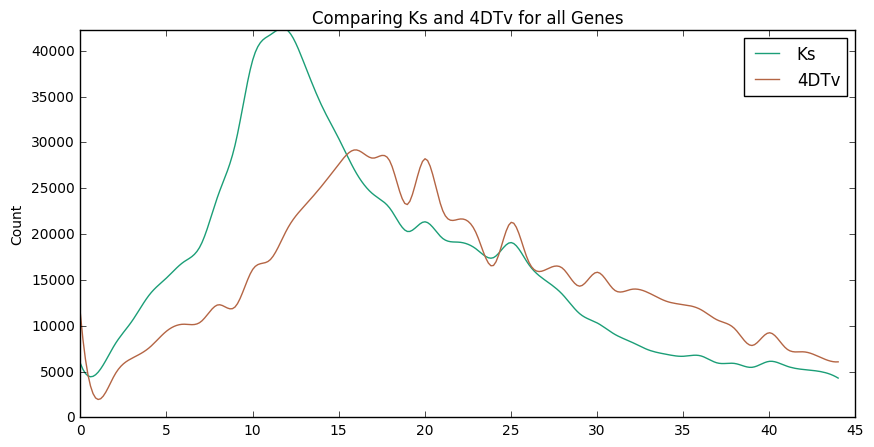

In [87]:
categorical_histogram('Comparing Ks and 4DTv for all Genes', {'Ks': [int(y*100) for y in ks_vals_all],
                                                             '4DTv': [int(y*100) for y in four_folds_all]}, xmax=45)

**Conclusion:** These wide peaks are likely caused by mixing all of the species peaks together.  I predict these will separate out much better when looking at one species at a time.

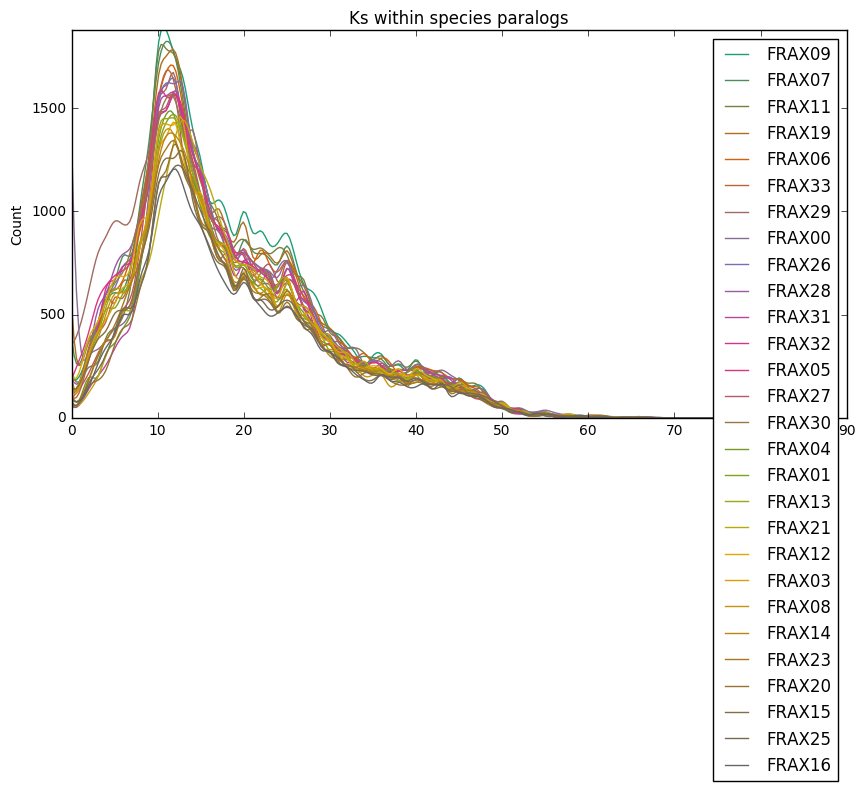

In [108]:
plot_by_species = {}
for species, pairs in ks_paralogs_by_species.items():
    species_stats = [int(stats['ks_ratio'] * 100) for names, stats in pairs.items()]
#     print(species, species_stats[:10])
    plot_by_species[species] = species_stats
categorical_histogram('Ks within species paralogs', plot_by_species, xmax=85) 

## Filter Families by those included as Ohnologs

In [88]:
study_ohnologs = set('OG0012177 OG0005778 OG0005042 OG0002888 OG0004841 OG0011863 OG0001379 OG0006704 OG0011800 OG0014792 OG0003798 OG0004333 OG0008017 OG0007942 OG0007813 OG0008549 OG0001997 OG0013132 OG0007949 OG0012632 OG0004679 OG0004822 OG0004727 OG0006515 OG0019657 OG0011464 OG0002557 OG0016809 OG0000473 OG0003862 OG0008568 OG0007901 OG0008789 OG0011695 OG0017333 OG0006075 OG0006019 OG0016793 OG0004765 OG0005969 OG0003553 OG0004122 OG0004194 OG0006491 OG0010152 OG0004478 OG0006013 OG0018515 OG0009434 OG0009087 OG0013737 OG0011678 OG0009399 OG0004674 OG0007324 OG0009425 OG0008246 OG0010521 OG0012416 OG0004111 OG0006078 OG0017467 OG0019901 OG0001476 OG0012894 OG0003465 OG0007480 OG0008026 OG0004890 OG0016692 OG0005095 OG0004516 OG0003805 OG0007087 OG0005031 OG0003687 OG0010556 OG0006787 OG0002346 OG0005627 OG0005639 OG0011145 OG0010237 OG0010885 OG0005836 OG0006825 OG0006254 OG0000622 OG0014682 OG0009361 OG0005479 OG0010970 OG0012247 OG0008313 OG0001764 OG0008391 OG0007895 OG0014407 OG0016785 OG0009855 OG0006606 OG0005053 OG0002954 OG0010172 OG0011615 OG0001741 OG0009743 OG0007629 OG0004301 OG0009418 OG0009733 OG0005079 OG0013705 OG0008306 OG0005185 OG0004558 OG0007852 OG0022086 OG0012443 OG0004065 OG0002445 OG0009511 OG0003711 OG0009343 OG0016903 OG0003683 OG0010621 OG0018876 OG0007627 OG0011048 OG0011387 OG0007154 OG0001036 OG0003784 OG0002737 OG0007803 OG0006601 OG0005792 OG0007364 OG0008294 OG0007498 OG0004866 OG0009592 OG0012069 OG0007996 OG0005666 OG0006402 OG0006974 OG0010263 OG0010014 OG0002070 OG0006966 OG0005058 OG0001286 OG0007089 OG0017310 OG0018940 OG0005373 OG0017246 OG0012317 OG0007938 OG0011647 OG0005776 OG0008564 OG0009008 OG0008750 OG0011248 OG0010839 OG0009045 OG0004746 OG0006255 OG0006662 OG0005524 OG0005616 OG0006215 OG0005779 OG0006724 OG0007594 OG0010865 OG0007440 OG0005311 OG0007161 OG0007008 OG0006958 OG0016034 OG0005619 OG0004997 OG0005860 OG0002349 OG0007788 OG0001852 OG0008546 OG0006655 OG0007931 OG0007916 OG0008781 OG0011373 OG0007676 OG0003740 OG0004809 OG0005227 OG0006305 OG0010762 OG0001121 OG0004043 OG0011848 OG0004625 OG0017606 OG0011590 OG0011439 OG0016981 OG0007736 OG0005618 OG0001869 OG0021314 OG0010553 OG0005569 OG0001726 OG0008019 OG0003219 OG0012746 OG0003836 OG0007830 OG0004853 OG0016323 OG0007513 OG0006503 OG0009450 OG0006370 OG0003274 OG0004756 OG0012990 OG0005949 OG0001402 OG0009747 OG0004489 OG0004309 OG0008406 OG0007930 OG0020234 OG0004347 OG0012077 OG0004007 OG0007735 OG0007207 OG0006677 OG0008043 OG0010476 OG0007964 OG0003822 OG0000927 OG0006947 OG0009561 OG0004164 OG0005926 OG0007403 OG0004626 OG0006701 OG0004784 OG0000986 OG0010353 OG0010419 OG0008915 OG0013793 OG0003680 OG0004245 OG0006797 OG0002331 OG0012722 OG0007464 OG0008551 OG0001802 OG0010594 OG0003361 OG0013655 OG0009209 OG0016575 OG0013773 OG0022212 OG0004669 OG0010176 OG0007905 OG0005363 OG0008949 OG0004446 OG0007343 OG0005273 OG0008318 OG0008683 OG0008385 OG0018185 OG0004404 OG0004941 OG0014039 OG0004593 OG0006521 OG0007556 OG0008123 OG0012848 OG0011182 OG0003878 OG0007505 OG0002232 OG0006676 OG0011070 OG0007153 OG0001632 OG0002952 OG0012549 OG0006452 OG0007301 OG0004942 OG0008672 OG0017976 OG0001020 OG0010813 OG0010293 OG0012032 OG0011129 OG0003863 OG0005151 OG0007804 OG0007439 OG0012860 OG0006191 OG0013733 OG0011735 OG0004659 OG0005074 OG0017520 OG0012210 OG0005596 OG0010611 OG0019902 OG0007382 OG0001783 OG0005588 OG0009074 OG0007866 OG0002786 OG0001354 OG0010067 OG0009146 OG0008170 OG0007893 OG0010770 OG0007967 OG0008837 OG0004474 OG0013685 OG0008198 OG0011000 OG0017938 OG0005739 OG0009066 OG0009149 OG0010016 OG0002517 OG0009720 OG0008208 OG0007038 OG0010087 OG0008456 OG0002496 OG0005976 OG0005154 OG0006287 OG0001902 OG0007323 OG0005275 OG0011532 OG0018469 OG0008519 OG0003306 OG0005093 OG0005672 OG0014207 OG0006205 OG0018499 OG0013124 OG0008186 OG0008760 OG0008359 OG0011869 OG0009171 OG0005880 OG0005968 OG0003569 OG0005829 OG0010789 OG0012183 OG0007766 OG0014622 OG0006040 OG0003964 OG0007795 OG0011094 OG0006996 OG0006824 OG0005821 OG0004258 OG0006939 OG0011325 OG0008056 OG0006156 OG0018511 OG0007104 OG0004381 OG0014130 OG0002273 OG0005655 OG0005633 OG0019582 OG0011148 OG0009004 OG0005224 OG0014994 OG0007251 OG0006864 OG0018907 OG0003888 OG0006863 OG0019007 OG0018578 OG0008475 OG0015985 OG0009225 OG0006573 OG0016582 OG0011379 OG0011965 OG0009312 OG0016251 OG0006602 OG0020589 OG0004205 OG0004382 OG0006919 OG0004676 OG0005352 OG0005518 OG0005456 OG0013807 OG0017284 OG0011322 OG0008291 OG0010989 OG0017023 OG0010225 OG0012394 OG0010449 OG0011445 OG0012598 OG0001667 OG0003463 OG0007843 OG0008021 OG0020120 OG0001981 OG0014723 OG0010461 OG0006794 OG0007538 OG0004962 OG0009217 OG0009219 OG0005719 OG0011225 OG0011774 OG0003257 OG0012283 OG0001522 OG0007633 OG0020440 OG0001063 OG0001930 OG0008425 OG0004980 OG0004227 OG0005921 OG0006448 OG0008801 OG0009900 OG0013488 OG0017267 OG0020620 OG0005989 OG0006474 OG0006233 OG0008367 OG0004099 OG0004222 OG0001012 OG0003692 OG0003309 OG0009535 OG0008265 OG0016541 OG0002551 OG0006734 OG0011256 OG0008702 OG0007369 OG0009909 OG0010399 OG0006807 OG0005013 OG0011108 OG0010848 OG0008224 OG0002230 OG0005974 OG0001605 OG0008772 OG0016164 OG0010752 OG0010730 OG0006537 OG0009754 OG0006475 OG0007013 OG0008956 OG0000563 OG0011385 OG0009220 OG0011364 OG0008502 OG0007609 OG0005040 OG0000617 OG0014727 OG0010878 OG0005734 OG0003611 OG0006510 OG0010439 OG0009635 OG0007349 OG0010210 OG0006243 OG0006197 OG0002539 OG0010646 OG0004557 OG0006887 OG0009580 OG0003931 OG0003662 OG0008667 OG0008060 OG0003444 OG0019871 OG0007149 OG0004840 OG0009334 OG0009298 OG0003793 OG0004914 OG0007454 OG0000587 OG0007688 OG0005025 OG0002607 OG0005476 OG0008083 OG0011492 OG0017024 OG0012267 OG0001171 OG0009586 OG0007001 OG0004636 OG0007401 OG0004848 OG0008070 OG0016086 OG0010284 OG0008884 OG0017276 OG0004648 OG0006397 OG0003254 OG0007501 OG0003243 OG0001285 OG0017711 OG0003222 OG0009287 OG0001197 OG0011669 OG0004471 OG0008164 OG0001507 OG0009346 OG0008784 OG0005544 OG0011302 OG0000638 OG0001087 OG0006597 OG0005097 OG0005421 OG0011413 OG0005919 OG0007205 OG0012440 OG0014052 OG0007179 OG0001418 OG0006002 OG0010713 OG0009891 OG0005472 OG0011834 OG0009081 OG0006782 OG0014690 OG0006044 OG0009726 OG0003857 OG0006616 OG0002606 OG0009759 OG0015580 OG0008758 OG0010105 OG0009126 OG0010239 OG0018139 OG0009266 OG0005551 OG0011849 OG0011285 OG0008126 OG0008585 OG0010832 OG0009403 OG0010673 OG0004800 OG0006967 OG0001310 OG0010375 OG0010736 OG0003328 OG0004503 OG0008675 OG0002961 OG0003528 OG0001883 OG0009179 OG0007411 OG0006806 OG0010630 OG0003709 OG0011423 OG0004255 OG0010330 OG0019486 OG0005728 OG0012718 OG0000751 OG0003115 OG0009102 OG0005112 OG0005431 OG0011354 OG0012066 OG0002746 OG0015741 OG0001943 OG0002148 OG0009667 OG0004522 OG0009732 OG0004968 OG0014094 OG0004525 OG0010030 OG0019299 OG0000892 OG0011403 OG0005935 OG0005061 OG0011168 OG0011680 OG0010522 OG0008193 OG0002534 OG0006492 OG0012815 OG0008632 OG0009545 OG0013406 OG0000491 OG0005906 OG0005408 OG0005785 OG0007700 OG0008039 OG0004700 OG0004657 OG0008509 OG0010291 OG0010853 OG0006457 OG0003234 OG0018391 OG0007025 OG0008648 OG0007781 OG0004830 OG0002395 OG0006378 OG0009047 OG0014658 OG0006735 OG0017659 OG0006592 OG0002093 OG0003988 OG0005405 OG0006953 OG0008011 OG0008404 OG0009843 OG0008559 OG0016857 OG0008372 OG0008651 OG0003770 OG0004078 OG0008341 OG0001220 OG0010829 OG0009140 OG0005483 OG0008049 OG0012007 OG0012847 OG0017754 OG0004922 OG0007647 OG0007873 OG0010756 OG0006987 OG0010044 OG0007283 OG0010159 OG0006751 OG0008033 OG0008851 OG0004280 OG0006121 OG0005585 OG0011793 OG0005737 OG0003905 OG0006756 OG0019788 OG0005911 OG0005175 OG0005260 OG0011892 OG0013298 OG0011900 OG0008958 OG0004526 OG0006016 OG0004778 OG0007928 OG0010910 OG0009212 OG0003855 OG0001687 OG0005188 OG0001321 OG0018253 OG0011552 OG0016833 OG0005504 OG0005007 OG0003671 OG0003315 OG0009489 OG0005284 OG0003248 OG0007696 OG0000933 OG0007418 OG0007756 OG0008553 OG0004783 OG0009458 OG0015694 OG0007080 OG0010719 OG0011122 OG0007021 OG0008328 OG0018792 OG0005382 OG0003381 OG0005685 OG0003881 OG0002155 OG0018131 OG0007341 OG0006047 OG0009719 OG0006661 OG0006641 OG0009703 OG0007249 OG0001959 OG0004719 OG0017457 OG0007491 OG0012889 OG0009686 OG0004200 OG0005305 OG0004230 OG0006551 OG0010303 OG0006647 OG0005034 OG0007623 OG0016333 OG0012883 OG0003898 OG0008311 OG0004993 OG0007064 OG0004945 OG0006105 OG0005835 OG0011120 OG0005022 OG0009336 OG0003742 OG0012825 OG0009278 OG0001503 OG0006275 OG0010153 OG0003053 OG0011123 OG0007321 OG0008921 OG0005099 OG0001877 OG0004614 OG0007725 OG0005059 OG0008595 OG0004564 OG0010248 OG0011730 OG0001685 OG0004212 OG0004581 OG0006547 OG0014370 OG0009779 OG0008528 OG0011071 OG0011847 OG0010864 OG0007503 OG0000874 OG0010404 OG0015575 OG0005166 OG0006745 OG0007613 OG0000661 OG0001370 OG0004606 OG0010734 OG0011958 OG0011929 OG0010294 OG0007673 OG0011913 OG0004854 OG0007051 OG0009448 OG0014554 OG0006969 OG0001629 OG0006199 OG0009227 OG0010364 OG0012288 OG0008471 OG0009169 OG0005180 OG0005942 OG0004406 OG0005450 OG0007115 OG0007686 OG0004734 OG0004951 OG0012956 OG0007716 OG0000939 OG0002610 OG0004781 OG0009789 OG0006098 OG0010382 OG0004630 OG0003833 OG0009830 OG0016084 OG0014364 OG0019496 OG0011360 OG0016552 OG0007536 OG0004517 OG0013636 OG0009616 OG0011864 OG0004709 OG0008195 OG0008012 OG0004883 OG0006419 OG0007677 OG0011899 OG0005583 OG0009518 OG0005503 OG0008870 OG0009214 OG0002249 OG0007887 OG0015704 OG0010038 OG0007573 OG0007065 OG0007279 OG0006160 OG0007549 OG0007999 OG0008579 OG0010366 OG0007348 OG0006938 OG0016768 OG0006386 OG0006560 OG0002428 OG0010920 OG0004208 OG0005388 OG0006744 OG0002182 OG0009408 OG0000708 OG0011618 OG0005365 OG0005547 OG0001536 OG0004663 OG0010230 OG0011565 OG0009608 OG0019784 OG0002915 OG0005002 OG0009905 OG0007152 OG0020710 OG0007306 OG0011058 OG0010124 OG0005886 OG0007146 OG0003302 OG0004806 OG0019520 OG0009028 OG0006732 OG0009873 OG0008361 OG0003055 OG0011054 OG0008908 OG0019545 OG0012461 OG0001485 OG0004405 OG0006513 OG0006527 OG0008032 OG0005397 OG0007469 OG0002226 OG0007909 OG0004943 OG0004504 OG0006852 OG0020636 OG0009082 OG0007697 OG0014097 OG0006222 OG0019297 OG0003413 OG0005249 OG0003621 OG0004407 OG0011415 OG0017790 OG0001346 OG0004779 OG0006244 OG0004150 OG0008917 OG0002525 OG0007252 OG0004877 OG0003799 OG0006585 OG0008116 OG0007591 OG0002836 OG0008936 OG0011927 OG0009980 OG0003748 OG0004714 OG0009129 OG0008601 OG0007986 OG0007134 OG0003368 OG0008324 OG0004702 OG0008408 OG0003307 OG0010669 OG0013412 OG0008529 OG0000273 OG0010143 OG0009482 OG0016819 OG0003971 OG0004155 OG0010785 OG0009575 OG0001456 OG0002898 OG0006786 OG0008143 OG0006020 OG0003736 OG0003661 OG0007637 OG0002255 OG0012618 OG0018056 OG0012892 OG0008258 OG0008843 OG0004071 OG0009249 OG0004408 OG0015017 OG0003352 OG0010569 OG0011801 OG0005011 OG0004139 OG0006623 OG0005448 OG0013780 OG0016746 OG0003069 OG0003997 OG0001391 OG0005177 OG0007391 OG0018546 OG0020272 OG0003873 OG0004456 OG0005877 OG0007926 OG0010960 OG0005234 OG0002036 OG0003119 OG0009420 OG0007649 OG0003325 OG0006931 OG0004403 OG0008730 OG0017421 OG0007698 OG0012133 OG0014004 OG0005607 OG0002302 OG0012760 OG0010609 OG0005773 OG0005595 OG0005251 OG0006950 OG0006644 OG0006625 OG0008401 OG0011560 OG0011272 OG0012103 OG0006073 OG0002853 OG0010452 OG0009678 OG0008868 OG0007202 OG0022799 OG0009373 OG0005982 OG0008010 OG0000378 OG0005708 OG0005131 OG0007223 OG0011941 OG0005997 OG0006240 OG0008523 OG0007962 OG0003445 OG0009476 OG0001464 OG0002522 OG0012297 OG0012487 OG0018075 OG0007782 OG0002868 OG0007175 OG0003617 OG0010491 OG0010482 OG0003917 OG0009784 OG0012357 OG0006451 OG0008656 OG0002139 OG0009265 OG0006829 OG0018024 OG0002002 OG0010409 OG0007635 OG0005824 OG0017649 OG0007322 OG0009194 OG0011569 OG0003672 OG0009159 OG0009742 OG0007061 OG0002592 OG0004496 OG0019710 OG0006347 OG0008967 OG0005044 OG0006383 OG0007270 OG0008658 OG0009658 OG0008182 OG0011693 OG0001954 OG0005905 OG0013510 OG0008628 OG0013223 OG0004545 OG0001642 OG0006715 OG0004491 OG0007598 OG0004177 OG0011420 OG0008726 OG0004577 OG0017262 OG0005550 OG0011653 OG0011237 OG0014939 OG0005336 OG0016669 OG0003904 OG0004317 OG0004129 OG0004668 OG0007339 OG0001396 OG0005576 OG0003940 OG0005394 OG0006608 OG0003612 OG0006578 OG0005348 OG0003698 OG0000753 OG0009614 OG0005761 OG0011049 OG0017349 OG0014320 OG0018594 OG0009918 OG0005887 OG0002030 OG0001676 OG0004782 OG0000659 OG0010531 OG0018873 OG0000212 OG0015146 OG0010794 OG0005688 OG0011504 OG0007749 OG0004210 OG0004485 OG0009949 OG0006306 OG0006062 OG0010024 OG0010131 OG0007388 OG0009694 OG0011219 OG0004272 OG0003172 OG0004643 OG0007872 OG0006964 OG0006651 OG0003148 OG0008623 OG0006872 OG0006409 OG0008981 OG0008357 OG0003812 OG0012296 OG0007084 OG0008503 OG0007981 OG0006543 OG0011236 OG0006068 OG0008982 OG0006256 OG0002260 OG0009001 OG0003768 OG0005101 OG0009629 OG0003604 OG0003195 OG0003864 OG0004938 OG0007845 OG0007985 OG0000721 OG0011944 OG0008084 OG0004775 OG0013468 OG0006750 OG0003774 OG0009912 OG0010847 OG0007280 OG0004344 OG0009333 OG0009279 OG0009317 OG0010448 OG0017129 OG0002817 OG0017945 OG0004893 OG0009042 OG0007750 OG0007091 OG0008476 OG0012700 OG0002351 OG0008440 OG0004153 OG0018010 OG0010817 OG0005909 OG0010022 OG0005164 OG0004774 OG0008589 OG0008630 OG0006629 OG0006099 OG0003266 OG0005950 OG0014157 OG0005553 OG0012476 OG0011670 OG0004987 OG0007452 OG0002788 OG0004338 OG0003106 OG0007904 OG0009991 OG0016702 OG0003601 OG0012084 OG0006685 OG0004036 OG0012451 OG0004551 OG0013703 OG0009945 OG0003859 OG0001816 OG0006808 OG0005289 OG0014492 OG0005026 OG0004362 OG0005699 OG0013823 OG0010615 OG0002812 OG0005331 OG0019739 OG0008946 OG0010721 OG0005510 OG0001637 OG0016540 OG0006101 OG0005859 OG0008581 OG0009092 OG0007214 OG0010287 OG0004638 OG0009072 OG0009470 OG0011082 OG0013535 OG0003297 OG0006760 OG0002871 OG0009967 OG0008349 OG0012644 OG0006603 OG0006311 OG0002758 OG0005367 OG0014072 OG0005852 OG0008864 OG0009974 OG0005681 OG0006892 OG0010058 OG0001547 OG0007387 OG0004106 OG0010083 OG0004095 OG0003108 OG0006211 OG0009190 OG0014626 OG0003223 OG0005298 OG0004819 OG0006681 OG0009797 OG0007170 OG0005634 OG0009138 OG0004873 OG0007992 OG0001935 OG0000670 OG0005709 OG0012266 OG0000834 OG0003134 OG0003314 OG0009527 OG0004326 OG0003897 OG0004218 OG0006180 OG0005557 OG0011570 OG0005140 OG0010021 OG0009762 OG0008077 OG0006334 OG0015583 OG0017027 OG0010321 OG0004725 OG0003934 OG0009254 OG0005481 OG0005660 OG0009508 OG0005722 OG0000398 OG0005174 OG0011061 OG0001376 OG0013990 OG0010633 OG0007708 OG0005559 OG0007257 OG0014359 OG0012568 OG0005690 OG0005461 OG0006441 OG0008973 OG0008535 OG0010477 OG0013964 OG0008922 OG0004816 OG0009819 OG0016283 OG0004356 OG0006437 OG0005057 OG0006332 OG0006422 OG0017816 OG0013853 OG0004363 OG0005399 OG0009248 OG0006607 OG0003032 OG0004634 OG0007385 OG0006516 OG0017202 OG0006021 OG0009960 OG0011497 OG0009419 OG0018583 OG0006456 OG0005285 OG0004605 OG0010115 OG0006084 OG0015254 OG0010106 OG0011212 OG0014729 OG0004930 OG0002278 OG0009207 OG0008755 OG0008893 OG0012972 OG0003477 OG0008761 OG0009519 OG0000418 OG0002711 OG0011731 OG0008720 OG0009229 OG0004250 OG0004061 OG0011711 OG0010090 OG0009096 OG0009433 OG0000595 OG0010180 OG0011107 OG0009331 OG0010018 OG0008573 OG0003210 OG0007579 OG0007908 OG0008192 OG0011865 OG0004963 OG0005799 OG0009809 OG0001858 OG0005261 OG0009886 OG0011066 OG0008992 OG0011351 OG0011034 OG0005143 OG0008209 OG0010999 OG0010270 OG0003185 OG0005111 OG0003946 OG0001617 OG0009769 OG0017517 OG0009443 OG0018831 OG0007953 OG0006470 OG0002674 OG0012658 OG0001544 OG0007231 OG0010683 OG0011062 OG0012338 OG0017342 OG0004179 OG0006271 OG0015514 OG0011092 OG0006752 OG0012052 OG0007472 OG0012751 OG0011690 OG0005113 OG0013938 OG0004538 OG0015729 OG0013471 OG0014528 OG0004225 OG0009487 OG0007413 OG0010946 OG0003983 OG0011870 OG0010827 OG0002467 OG0009064 OG0008522 OG0007026 OG0005769 OG0007861 OG0010933 OG0008663 OG0005726 OG0011461 OG0007415 OG0010947 OG0009868 OG0008842 OG0003987 OG0015950 OG0006066 OG0005374 OG0018982 OG0007422 OG0006310 OG0012797 OG0001540 OG0005669 OG0009364 OG0013217 OG0008094 OG0005808 OG0015423 OG0009387 OG0007748 OG0013546 OG0017873 OG0008867 OG0019456 OG0007634 OG0014612 OG0010307 OG0005281 OG0004798 OG0011945 OG0005167 OG0004290 OG0005589 OG0006566 OG0006249 OG0014629 OG0011575 OG0008544 OG0016156 OG0014902 OG0005561 OG0008913 OG0020536 OG0006093 OG0012060 OG0009208 OG0006295 OG0018900 OG0005083 OG0010433 OG0003693 OG0003142 OG0007171 OG0002484 OG0006082 OG0016611 OG0007639 OG0004906 OG0005384 OG0011476 OG0003384 OG0005359 OG0013618 OG0004547 OG0016167 OG0006151 OG0011794 OG0004542 OG0013966 OG0006090 OG0013375 OG0006434 OG0003788 OG0002816 OG0009241 OG0005955 OG0005697 OG0017808 OG0006261 OG0004747 OG0004912 OG0008902 OG0012386 OG0007185 OG0005338 OG0009908 OG0018700 OG0022962 OG0003198 OG0005578 OG0005535 OG0007076 OG0012876 OG0006359 OG0016391 OG0013241 OG0010801 OG0003473 OG0002863 OG0003915 OG0006192 OG0006185 OG0009647 OG0007983 OG0021284 OG0007948 OG0004899 OG0005016 OG0004905 OG0004879 OG0006114 OG0007331 OG0005641 OG0005355 OG0013294 OG0007910 OG0006570 OG0007632 OG0004121 OG0005325 OG0005545 OG0008025 OG0005977 OG0002854 OG0013219 OG0007209 OG0010502 OG0005827 OG0008562 OG0006944 OG0010457 OG0006905 OG0010478 OG0008413 OG0013980 OG0009131 OG0012484 OG0010767 OG0010181 OG0004056 OG0005110 OG0006859 OG0005878 OG0004965 OG0008764 OG0016875 OG0019082 OG0006835 OG0012238 OG0007878 OG0011879 OG0008567 OG0007313 OG0011659 OG0006348 OG0007088 OG0003848 OG0003179 OG0017896 OG0017525 OG0004607 OG0015118 OG0003114 OG0003823 OG0011993 OG0006123 OG0006162 OG0008814 OG0011610 OG0005863 OG0004457 OG0015721 OG0005902 OG0002356 OG0008030 OG0008898 OG0018602 OG0005088 OG0005560 OG0010068 OG0009752 OG0008736 OG0006117 OG0007455 OG0004549 OG0009579 OG0008113 OG0008944 OG0007831 OG0004600 OG0004632 OG0002978 OG0003933 OG0010927 OG0006993 OG0001917 OG0011523 OG0011055 OG0005687 OG0005981 OG0005210 OG0004039 OG0005424 OG0005332 OG0004144 OG0002932 OG0016834 OG0006705 OG0010073 OG0010211 OG0010504 OG0009202 OG0006288 OG0005841 OG0011138 OG0016636 OG0007049 OG0004641 OG0007801 OG0009600 OG0004450 OG0005292 OG0006106 OG0010667 OG0004068 OG0004133 OG0009185 OG0009041 OG0006925 OG0004067 OG0006514 OG0003543 OG0006768 OG0005894 OG0006564 OG0005915 OG0006296 OG0003996 OG0019404 OG0005117 OG0003634 OG0002639 OG0004171 OG0010340 OG0006459 OG0009012 OG0003245 OG0006553 OG0003630 OG0011014 OG0012812 OG0006678 OG0005427 OG0005333 OG0012648 OG0015607 OG0009698 OG0009344 OG0003598 OG0005850 OG0013015 OG0011008 OG0006250 OG0018569 OG0010184 OG0008611 OG0002204 OG0007465 OG0008636 OG0017576 OG0008302 OG0010818 OG0005344 OG0001449 OG0006694 OG0003457 OG0010886 OG0010672 OG0006153 OG0009025 OG0011943 OG0009188 OG0016612 OG0007245 OG0004583 OG0007848 OG0003380 OG0007754 OG0004282 OG0011868 OG0006142 OG0001780 OG0003221 OG0005918 OG0008804 OG0008278 OG0003252 OG0010859 OG0003417 OG0006382 OG0006921 OG0017521 OG0004892 OG0004523 OG0015105 OG0003028 OG0018783 OG0003710 OG0004515 OG0008844 OG0008395 OG0003346 OG0006636 OG0010466 OG0009016 OG0006467 OG0000334 OG0005071 OG0010921 OG0007965 OG0010903 OG0010597 OG0009132 OG0012843 OG0004306 OG0001400 OG0004202 OG0005521 OG0014881 OG0008240 OG0004804 OG0007978 OG0017410 OG0005591 OG0007366 OG0008063 OG0011820 OG0005267 OG0001302 OG0009366 OG0007425 OG0005555 OG0016462 OG0006365 OG0007581 OG0007875 OG0012488 OG0020509 OG0016457 OG0004723 OG0001442 OG0004249 OG0007359 OG0015897 OG0007004 OG0005572 OG0006252 OG0006152 OG0011607 OG0018377 OG0007892 OG0011756 OG0006175 OG0003944 OG0017480 OG0016594 OG0011159 OG0008272 OG0003969 OG0003902 OG0003373 OG0004975 OG0012758 OG0017925 OG0008253 OG0004201 OG0003101 OG0012055 OG0004518 OG0009544 OG0007254 OG0012875 OG0011781 OG0006446 OG0016013 OG0005337 OG0019384 OG0009469 OG0014972 OG0008248 OG0006842 OG0013931 OG0004812 OG0007596 OG0006417 OG0006279 OG0006861 OG0008746 OG0012282 OG0009757 OG0006209 OG0004354 OG0006317 OG0008545 OG0014119 OG0002432 OG0011635 OG0009314 OG0008245 OG0015521 OG0017106 OG0005471 OG0005212 OG0003785 OG0010715 OG0016585 OG0010261 OG0009424 OG0002320 OG0011064 OG0008666 OG0006450 OG0004619 OG0017942 OG0014315 OG0007457 OG0002641 OG0007373 OG0008823 OG0018203 OG0012529 OG0006653 OG0006265 OG0008110 OG0004499 OG0003895 OG0005809 OG0011952 OG0007126 OG0006315 OG0009563 OG0004617 OG0005430 OG0011875 OG0006326 OG0020838 OG0004500 OG0009162 OG0008065 OG0009475 OG0008232 OG0007355 OG0000816 OG0005319 OG0002270 OG0007555 OG0002393 OG0009231 OG0005498 OG0005389 OG0005048 OG0002669 OG0007630 OG0001709 OG0010320 OG0007624 OG0005565 OG0017482 OG0007187 OG0004944 OG0007172 OG0009057 OG0006031 OG0009664 OG0012384 OG0007362 OG0001304 OG0002354 OG0013831 OG0018083 OG0005160 OG0007409 OG0004510 OG0010743 OG0005445 OG0005272 OG0004396 OG0007012 OG0003171 OG0016860 OG0005781 OG0004918 OG0009415 OG0011914 OG0002785 OG0009746 OG0002065 OG0004958 OG0004863 OG0004257 OG0006524 OG0016437 OG0006053 OG0004000 OG0010299 OG0007550 OG0005598 OG0006282 OG0006436 OG0004902 OG0008740 OG0017184 OG0003081 OG0010585 OG0007527 OG0003565 OG0007689 OG0010808 OG0003938 OG0010139 OG0003839 OG0010803 OG0006427 OG0004772 OG0005455 OG0002806 OG0003954 OG0010554 OG0015965 OG0007018 OG0011466 OG0005988 OG0006675 OG0008880 OG0012050 OG0006170 OG0003157 OG0006713 OG0010539 OG0014295 OG0011701 OG0006325 OG0000781 OG0007150 OG0007771 OG0004986 OG0006589 OG0008877 OG0007935 OG0006949 OG0005509 OG0002035 OG0007005 OG0021572 OG0005658 OG0013504 OG0013208 OG0008249 OG0006278 OG0003651 OG0005176 OG0002437 OG0000489 OG0009276 OG0008811 OG0011083 OG0009766 OG0009699 OG0016831 OG0004880 OG0007808 OG0007186 OG0008132 OG0018988 OG0011933 OG0009377 OG0004075 OG0007450 OG0002164 OG0018607 OG0002423 OG0007031 OG0004049 OG0003338 OG0005892 OG0001742 OG0004211 OG0019294 OG0009920 OG0004234 OG0002239 OG0004424 OG0007779 OG0003559 OG0002460 OG0006304 OG0002280 OG0008346 OG0006986 OG0010423 OG0006290 OG0004161 OG0012305 OG0011004 OG0003752 OG0013767 OG0003787 OG0012655 OG0000998 OG0006956 OG0015048 OG0004296 OG0004849 OG0012816 OG0009044 OG0001030 OG0007042 OG0002773 OG0014357 OG0007794 OG0001303 OG0000625 OG0005205 OG0011529 OG0009550 OG0007265 OG0001429 OG0018945 OG0004850 OG0004165 OG0007389 OG0011562 OG0008188 OG0017282 OG0005183 OG0010559 OG0007586 OG0007121 OG0007069 OG0013790 OG0003749 OG0003654 OG0007604 OG0004385 OG0006455 OG0019711 OG0010072 OG0005469 OG0003123 OG0006739 OG0009164 OG0008537 OG0019619 OG0005075 OG0007474 OG0005516 OG0006840 OG0006476 OG0002769 OG0019893 OG0009431 OG0009911 OG0007151 OG0006253 OG0003649 OG0003330 OG0002265 OG0003682 OG0004989 OG0007600 OG0005203 OG0001655 OG0006049 OG0002197 OG0007704 OG0010690 OG0009137 OG0000612 OG0003925 OG0005991 OG0010710 OG0002825 OG0007351 OG0007350 OG0010276 OG0004692 OG0005978 OG0007476 OG0005920 OG0008079 OG0016538 OG0007335 OG0005077 OG0011390 OG0007119 OG0000885 OG0010923 OG0006520 OG0008813 OG0016243 OG0005322 OG0007793 OG0006109 OG0004935 OG0006816 OG0005477 OG0005807 OG0008732 OG0010110 OG0001166 OG0005310 OG0004270 OG0005379 OG0008462 OG0002576 OG0005073 OG0013153 OG0006831 OG0008727 OG0001257 OG0007776 OG0008437 OG0009979 OG0008600 OG0008971 OG0005037 OG0006481 OG0018030 OG0014303 OG0007120 OG0007541 OG0003272 OG0001970 OG0006210 OG0011437 OG0018193 OG0008217 OG0005315 OG0008461 OG0010065 OG0006055 OG0012445 OG0011728 OG0006511 OG0005952 OG0011644 OG0011195 OG0007902 OG0008329 OG0010913 OG0007796 OG0004613 OG0006523 OG0009670 OG0008580 OG0008594 OG0009634 OG0005802 OG0009027 OG0003283 OG0016306 OG0012078 OG0005528 OG0009553 OG0008058 OG0004513 OG0007281 OG0005329 OG0004393 OG0001420 OG0000304 OG0011090 OG0003166 OG0004990 OG0005507 OG0020721 OG0004447 OG0008254 OG0011433 OG0005804 OG0012215 OG0006137 OG0003825 OG0013380 OG0013269 OG0008053 OG0005558 OG0007243 OG0004380 OG0002790 OG0004954 OG0002723 OG0007028 OG0002729 OG0002261 OG0006915 OG0009243 OG0018776 OG0004869 OG0000740 OG0011422 OG0004204 OG0019378 OG0003867 OG0004870 OG0004539 OG0007404 OG0004652 OG0008213 OG0010221 OG0006833 OG0013919 OG0010488 OG0007712 OG0005098 OG0004128 OG0016070 OG0006270 OG0007255 OG0012400 OG0010455 OG0009100 OG0012237 OG0007807 OG0010259 OG0009139 OG0020553 OG0001135 OG0011165 OG0005928 OG0002133 OG0013443 OG0007907 OG0010496 OG0003550 OG0006362 OG0007201 OG0007572 OG0009345 OG0012965 OG0016966 OG0006805 OG0014607 OG0008448 OG0013305 OG0004377 OG0002458 OG0007277 OG0007178 OG0004939 OG0005246 OG0010401 OG0005223 OG0013093 OG0015093 OG0005713 OG0014234 OG0008662 OG0009555 OG0007687 OG0011694 OG0008082 OG0019027 OG0019682 OG0012611 OG0009648 OG0003719 OG0017165 OG0002275 OG0001922 OG0005232 OG0002665 OG0005287 OG0009880 OG0008169 OG0012165 OG0009651 OG0006788 OG0019501 OG0006954 OG0006174 OG0007719 OG0007699 OG0007333 OG0006957 OG0005103 OG0013431 OG0007532 OG0010800 OG0010608 OG0006746 OG0005854 OG0011353 OG0018128 OG0004337 OG0011286 OG0016312 OG0004397 OG0004622 OG0004983 OG0007375 OG0006056 OG0005086 OG0008018 OG0005171 OG0011867 OG0013653 OG0006227 OG0012186 OG0006784 OG0010950 OG0005091 OG0011199 OG0015536 OG0003794 OG0004623 OG0012639 OG0006376 OG0006257 OG0004673 OG0007071 OG0005787 OG0008218 OG0012274 OG0001636 OG0010699 OG0004180 OG0011939 OG0005609 OG0018225 OG0008941 OG0010955 OG0006050 OG0005673 OG0004969 OG0006795 OG0005153 OG0011802 OG0009098 OG0007920 OG0004908 OG0006061 OG0004865 OG0011311 OG0009972 OG0006595 OG0007427 OG0008700 OG0006943 OG0011786 OG0005593 OG0007657 OG0008130 OG0003079 OG0004537 OG0005980 OG0003810 OG0006736 OG0003098 OG0004720 OG0015573 OG0009040 OG0003514 OG0006755 OG0017806 OG0003034 OG0007858 OG0014210 OG0008410 OG0008296 OG0008257 OG0010357 OG0010327 OG0009286 OG0003209 OG0006758 OG0009948 OG0006502 OG0011235 OG0008229 OG0006206 OG0008400 OG0003139 OG0009070 OG0005810 OG0006775 OG0005842 OG0004005 OG0006849 OG0013012 OG0011196 OG0018146 OG0005867 OG0001029 OG0009931 OG0007819 OG0013502 OG0013026 OG0004929 OG0010164 OG0005084 OG0006743 OG0006702 OG0009848 OG0004544 OG0004216 OG0006906 OG0006194 OG0016394 OG0004895 OG0004844 OG0007922 OG0008841 OG0003355 OG0000013 OG0006673 OG0008665 OG0012144 OG0010047 OG0017813 OG0014533 OG0000877 OG0006940 OG0010489 OG0001229 OG0007859 OG0003070 OG0009447 OG0003664 OG0005511 OG0003677 OG0006118 OG0002377 OG0004438 OG0004454 OG0007512 OG0006147 OG0005392 OG0015914 OG0006800 OG0009593 OG0002157 OG0008286 OG0009154 OG0004568 OG0006375 OG0007690 OG0005066 OG0008127 OG0011176 OG0001380 OG0005375 OG0011300 OG0007184 OG0009039 OG0019622 OG0005429 OG0008848 OG0004966 OG0005848 OG0004123 OG0012137 OG0006010 OG0004371 OG0007958 OG0007516 OG0004594 OG0007054 OG0008411 OG0004651 OG0005229 OG0011162 OG0010868 OG0002169 OG0009493 OG0012898 OG0008283 OG0011511 OG0002465 OG0004737 OG0011457 OG0007493 OG0008055 OG0020301 OG0007490 OG0016559 OG0009256 OG0001070 OG0003154 OG0008752 OG0014772 OG0011356 OG0000655 OG0013411 OG0021349 OG0006083 OG0007703 OG0002774 OG0011946 OG0010084 OG0007011 OG0004730 OG0010505 OG0011299 OG0008165 OG0014338 OG0007968 OG0012129 OG0007035 OG0006468 OG0006103 OG0004932 OG0008688 OG0001765 OG0003535 OG0006600 OG0002716 OG0004435 OG0009568 OG0020277 OG0009721 OG0003451 OG0005082 OG0009148 OG0018556 OG0015754 OG0007132 OG0017149 OG0006699 OG0007113 OG0021342 OG0009181 OG0006070 OG0007484 OG0009906 OG0004776 OG0015557 OG0006342 OG0006015 OG0002409 OG0007869 OG0007224 OG0004013 OG0010514 OG0009235 OG0000919 OG0003976 OG0005766 OG0013792 OG0010647 OG0009371 OG0008003 OG0005222 OG0009284 OG0004754 OG0013379 OG0009662 OG0009479 OG0005534 OG0000716 OG0009503 OG0012030 OG0006801 OG0007400 OG0001648 OG0002599 OG0017030 OG0017667 OG0008168 OG0008586 OG0004505 OG0009992 OG0007867 OG0002640 OG0007936 OG0009770 OG0004894 OG0012273 OG0011700 OG0012791 OG0001490 OG0005813 OG0009486 OG0004427 OG0003832 OG0009576 OG0005276 OG0018775 OG0012171 OG0009206 OG0008771 OG0006041 OG0007530 OG0006799 OG0014026 OG0008497 OG0015261 OG0002126 OG0006379 OG0009713 OG0004163 OG0007446 OG0004017 OG0004442 OG0001467 OG0012454 OG0012327 OG0007082 OG0003299 OG0008162 OG0004677 OG0007471 OG0007925 OG0015792 OG0001809 OG0004793 OG0005604 OG0007724 OG0010560 OG0006994 OG0007742 OG0005782 OG0004576 OG0006281 OG0017193 OG0004292 OG0000838 OG0003128 OG0005830 OG0014290 OG0007542 OG0017186 OG0004386 OG0006161 OG0006742 OG0011147 OG0005321 OG0011013 OG0006973 OG0005316 OG0008457 OG0005403 OG0011065 OG0004152 OG0004253 OG0011404 OG0007118 OG0008818 OG0013624 OG0003918 OG0011449 OG0002350 OG0005849 OG0005489 OG0012510 OG0002028 OG0004580 OG0006145 OG0009806 OG0003860 OG0005069 OG0008690 OG0004950 OG0005055 OG0008222 OG0011029 OG0011281 OG0005000 OG0008340 OG0009172 OG0002254 OG0014118 OG0001322 OG0006497 OG0008307 OG0011920 OG0010099 OG0009385 OG0010582 OG0006591 OG0004352 OG0005089 OG0005106 OG0006810 OG0012810 OG0005788 OG0004387 OG0017328 OG0011113 OG0004288 OG0008631 OG0008747 OG0007619 OG0001525 OG0003342 OG0006048 OG0012398 OG0006034 OG0006796 OG0006354 OG0006269 OG0010169 OG0004303 OG0007642 OG0013564 OG0008067 OG0016608 OG0007434 OG0004443 OG0006907 OG0007334 OG0009423 OG0013246 OG0010944 OG0005482 OG0006558 OG0007107 OG0004744 OG0011091 OG0001328 OG0002751 OG0001455 OG0012430 OG0007802 OG0010735 OG0012353 OG0013692 OG0006203 OG0011067 OG0009840 OG0009406 OG0006176 OG0017508 OG0013490 OG0012436 OG0002822 OG0015012 OG0006568 OG0017252 OG0007969 OG0020856 OG0008493 OG0006684 OG0009009 OG0005148 OG0005192 OG0002667 OG0009847 OG0005917 OG0009048 OG0009530 OG0007710 OG0008454 OG0011080 OG0004996 OG0019321 OG0009093 OG0005663 OG0003288 OG0003663 OG0019886 OG0006672 OG0004310 OG0018244 OG0013646 OG0007317 OG0005409 OG0006339 OG0003437 OG0004665 OG0008119 OG0005372 OG0006130 OG0008226 OG0005812 OG0010411 OG0002687 OG0004364 OG0011741 OG0008728 OG0003945 OG0005274 OG0014861 OG0007760 OG0009247 OG0005644 OG0016952 OG0022667 OG0005328 OG0005945 OG0005873 OG0017991 OG0006266 OG0007342 OG0011571 OG0008774 OG0012785 OG0008577 OG0004654 OG0007534 OG0007278 OG0012179 OG0017034 OG0007432 OG0005416 OG0018771 OG0006837 OG0008157 OG0005360 OG0008281 OG0011042 OG0006172 OG0004158 OG0016603 OG0002161 OG0009263 OG0002970 OG0008073 OG0004889 OG0008790 OG0004308 OG0008995 OG0006262 OG0005395 OG0003078 OG0006783 OG0021293 OG0004964 OG0004411 OG0011605 OG0007952 OG0009180 OG0001634 OG0008561 OG0007037 OG0005895 OG0005973 OG0005600 OG0009111 OG0005009 OG0010503 OG0004716 OG0000138 OG0006730 OG0002220 OG0016311 OG0010962 OG0014637 OG0006028 OG0012619 OG0001283 OG0012075 OG0006978 OG0005520 OG0010257 OG0006344 OG0010279 OG0011873 OG0007044 OG0005115 OG0018437 OG0001666 OG0010464 OG0004898 OG0001299 OG0008518 OG0010929 OG0008899 OG0010627 OG0006286 OG0010101 OG0013808 OG0003137 OG0009481 OG0006903 OG0007847 OG0003826 OG0002180 OG0003076 OG0005590 OG0004299 OG0010288 OG0009642 OG0004961 OG0005869 OG0008293 OG0004468 OG0017288 OG0020737 OG0008904 OG0018172 OG0018789 OG0002831 OG0009564 OG0008525 OG0018692 OG0007383 OG0009919 OG0006791 OG0007906 OG0012087 OG0006627 OG0004243 OG0009531 OG0017547 OG0017166 OG0002744 OG0015291 OG0010529 OG0008114 OG0007003 OG0009933 OG0011001 OG0015474 OG0006018 OG0006498 OG0004345 OG0005612 OG0010390 OG0019080 OG0003013 OG0013594 OG0002492 OG0003060 OG0002016 OG0010421 OG0003738 OG0004615 OG0005218 OG0011033 OG0015973 OG0005753 OG0004532 OG0010120 OG0015717 OG0007494 OG0004682 OG0004220 OG0022651 OG0008975 OG0008637 OG0013694 OG0011359 OG0002811 OG0007159 OG0004608 OG0009043 OG0009080 OG0005814 OG0009751 OG0010833 OG0003764 OG0008481 OG0002060 OG0009401 OG0007303 OG0005784 OG0004960 OG0003506 OG0006960 OG0001948 OG0007461 OG0008163 OG0006447 OG0010277 OG0002761 OG0011280 OG0005303 OG0011251 OG0007487 OG0005990 OG0013066 OG0000798 OG0008598 OG0010199 OG0010873 OG0010551 OG0002804 OG0004871 OG0003532 OG0007828 OG0007390 OG0012963 OG0004318 OG0008480 OG0011103 OG0008348 OG0010934 OG0009834 OG0006923 OG0007548 OG0010475 OG0006888 OG0017986 OG0004770 OG0007273 OG0006433 OG0007945 OG0007563 OG0004088 OG0009622 OG0005233 OG0005480 OG0005035 OG0019233 OG0007316 OG0007412 OG0007238 OG0008433 OG0002912 OG0004790 OG0007308 OG0004140 OG0006698 OG0006765 OG0019790 OG0005817 OG0009573 OG0004693 OG0005751 OG0004131 OG0005036 OG0005054 OG0004794 OG0008948 OG0016529 OG0005252 OG0007230 OG0007722 OG0010150 OG0001212 OG0008121 OG0005078 OG0007911 OG0006802 OG0009321 OG0008806 OG0011617 OG0004827 OG0007799 OG0007959 OG0003419 OG0009727 OG0005861 OG0019309 OG0010266 OG0006463 OG0012090 OG0003201 OG0005910 OG0013675 OG0008610 OG0017433 OG0006635 OG0004042 OG0006598 OG0005493 OG0005125 OG0008875 OG0021109 OG0010709 OG0008570 OG0019751 OG0003367 OG0020885 OG0005135 OG0007972 OG0006946 OG0005376 OG0013346 OG0002673 OG0012466 OG0008846 OG0007000 OG0007932 OG0011539 OG0019450 OG0004421 OG0004971 OG0013891 OG0004059 OG0006548 OG0009006 OG0011038 OG0006857 OG0010198 OG0013596 OG0004660 OG0009187 OG0010795 OG0005567 OG0001517 OG0012966 OG0007340 OG0002942 OG0010265 OG0010902 OG0016044 OG0004671 OG0010820 OG0007531 OG0007547 OG0002573 OG0009572 OG0004033 OG0007511 OG0009216 OG0003606 OG0007963 OG0004508 OG0004915 OG0008891 OG0006424 OG0008588 OG0010243 OG0012085 OG0001056 OG0013585 OG0003737 OG0009963 OG0004900 OG0012472 OG0008388 OG0017648 OG0006081 OG0007481 OG0002206 OG0011505 OG0008409 OG0001309 OG0006458 OG0012360 OG0005933 OG0008159 OG0013167 OG0005356 OG0007022 OG0004624 OG0018047 OG0006251 OG0009962 OG0009127 OG0013731 OG0007914 OG0007206 OG0006902 OG0008459 OG0000057 OG0001615 OG0011134 OG0006322 OG0002813 OG0007977 OG0004339 OG0005004 OG0005866 OG0011224 OG0005763 OG0004331 OG0021789 OG0002590 OG0015025 OG0018207 OG0007242 OG0006656 OG0004988 OG0011358 OG0009005 OG0006461 OG0011329 OG0007770 OG0012194 OG0004466 OG0008895 OG0015857 OG0002876 OG0005676 OG0005302 OG0005152 OG0002708 OG0005659 OG0009440 OG0013506 OG0012219 OG0001950 OG0005930 OG0005157 OG0003761 OG0001633 OG0016055 OG0007588 OG0008862 OG0001740 OG0009226 OG0005908 OG0008314 OG0004315 OG0002162 OG0009502 OG0005994 OG0004687 OG0008897 OG0006299 OG0006095 OG0004054 OG0008822 OG0011344 OG0002783 OG0004116 OG0004294 OG0017702 OG0003045 OG0005794 OG0007393 OG0004704 OG0008820 OG0006340 OG0009141 OG0007570 OG0010202 OG0012806 OG0005815 OG0002697 OG0001757 OG0011600 OG0005204 OG0009653 OG0005705 OG0009268 OG0003555 OG0003357 OG0006472 OG0009538 OG0010472 OG0012987 OG0003256 OG0009839 OG0012708 OG0009052 OG0009468 OG0003090 OG0015531 OG0001350 OG0005525 OG0005916 OG0000463 OG0009429 OG0009795 OG0009122 OG0019104 OG0010356 OG0005764 OG0009893 OG0008542 OG0015103 OG0004358 OG0004755 OG0004732 OG0017195 OG0010991 OG0007709 OG0007599 OG0006381 OG0010700 OG0008957 OG0003830 OG0012174 OG0009862 OG0016092 OG0014002 OG0012646 OG0006679 OG0011204 OG0004595 OG0008753 OG0006747 OG0017863 OG0017929 OG0006036 OG0000069 OG0005502 OG0015836 OG0010953 OG0008829 OG0006696 OG0007250 OG0008526 OG0003670 OG0017731 OG0007723 OG0007453 OG0004416 OG0021601 OG0015856 OG0009740 OG0011301 OG0010209 OG0005642 OG0008520 OG0007050 OG0016557 OG0005662 OG0011540 OG0007569 OG0005209 OG0014632 OG0007098 OG0010278 OG0009038 OG0013139 OG0006771 OG0006163 OG0007043 OG0006399 OG0011270 OG0018049 OG0006776 OG0004115 OG0003994 OG0008616 OG0004431 OG0004612 OG0009953 OG0003366 OG0006977 OG0010031 OG0008069 OG0020276 OG0010385 OG0017241 OG0010275 OG0009083 OG0006277 OG0008464 OG0002660 OG0010095 OG0014345 OG0006414 OG0005805 OG0006060 OG0010188 OG0007326 OG0005170 OG0005765 OG0004936 OG0005888 OG0012094 OG0006212 OG0004391 OG0003872 OG0008364 OG0008375 OG0008276 OG0008133 OG0010887 OG0011441 OG0008827 OG0004261 OG0005401 OG0001364 OG0007329 OG0011883 OG0018523 OG0002021 OG0009071 OG0004420 OG0018825 OG0006700 OG0007568 OG0008552 OG0006487 OG0009744 OG0005682 OG0011393 OG0005630 OG0005263 OG0006737 OG0007966 OG0001674 OG0011942 OG0005219 OG0005883 OG0009023 OG0005198 OG0012098 OG0010075 OG0009086 OG0006224 OG0009799 OG0007758 OG0009709 OG0007988 OG0009824 OG0003908 OG0010574 OG0004974 OG0003745 OG0009024 OG0017245 OG0006738 OG0011547 OG0006935 OG0006936 OG0004872 OG0005811 OG0004875 OG0004631 OG0006575 OG0010746 OG0018923 OG0020464 OG0005786 OG0011223 OG0005948 OG0006814 OG0004182 OG0005959 OG0006410 OG0004472 OG0015357 OG0011886 OG0007805 OG0008179 OG0008694 OG0013409 OG0018500 OG0004355 OG0008710 OG0009728 OG0013861 OG0005882 OG0000979 OG0011604 OG0004332 OG0003851 OG0015266 OG0007602 OG0004649 OG0002500 OG0013647 OG0011877 OG0006374 OG0006058 OG0002881 OG0008378 OG0010747 OG0007030 OG0005736 OG0005010 OG0009103 OG0016986 OG0007437 OG0000845 OG0012799 OG0007096 OG0007535 OG0006539 OG0003972 OG0004448 OG0005871 OG0003691 OG0008703 OG0004034 OG0009582 OG0009155 OG0005169 OG0021853 OG0013051 OG0010738 OG0005225 OG0004824 OG0019267 OG0017406 OG0005694 OG0005574 OG0003492 OG0009088 OG0015160 OG0012311 OG0010968 OG0004548 OG0003135 OG0005790 OG0006004 OG0004417 OG0010316 OG0007506 OG0005635 OG0007615 OG0010220 OG0010371 OG0005711 OG0007141 OG0010692 OG0006086 OG0006248 OG0010196 OG0015785 OG0001069 OG0005492 OG0008612 OG0003184 OG0004992 OG0014619 OG0008714 OG0017798 OG0005244 OG0017770 OG0007479 OG0018294 OG0010000 OG0004107 OG0007163 OG0006208 OG0008242 OG0003058 OG0004156 OG0006371 OG0010234 OG0014550 OG0004710 OG0013704 OG0006336 OG0006462 OG0008661 OG0007394 OG0005207 OG0002106 OG0005494 OG0015201 OG0005172 OG0010078 OG0005046 OG0015525 OG0005254 OG0005893 OG0018702 OG0010041 OG0008587 OG0007751 OG0007212 OG0011760 OG0005362 OG0012016 OG0019620 OG0005488 OG0001656 OG0012926 OG0008926 OG0014046 OG0006478 OG0012567 OG0006508 OG0004574 OG0009384 OG0012862 OG0009995 OG0006242 OG0011588 OG0004118 OG0005270 OG0009221 OG0003103 OG0004076 OG0007014 OG0017253 OG0009617 OG0001766 OG0014806 OG0010304 OG0010613 OG0001154 OG0005064 OG0007991 OG0010788 OG0011687 OG0007592 OG0008697 OG0006621 OG0004896 OG0005900 OG0010849 OG0008027 OG0005155 OG0007744 OG0007561 OG0005932 OG0008492 OG0015019 OG0011045 OG0005540 OG0006798 OG0007628 OG0005464 OG0004994 OG0004664 OG0008223 OG0008869 OG0007290 OG0009558 OG0007870 OG0009501 OG0008836 OG0004934 OG0005533 OG0008960 OG0007557 OG0008477 OG0009588 OG0003335 OG0007681 OG0003507 OG0000799 OG0011479 OG0008200 OG0014279 OG0013654 OG0001753 OG0007680 OG0006314 OG0006774 OG0009756 OG0004728 OG0008779 OG0002209 OG0012099 OG0003627 OG0002749 OG0006951 OG0014925 OG0003167 OG0006865 OG0001112 OG0009851 OG0004324 OG0006665 OG0004955 OG0004761 OG0004705 OG0007504 OG0006229 OG0004159 OG0011852 OG0009603 OG0004455 OG0009541 OG0004501 OG0007062 OG0008852 OG0001774 OG0008260 OG0006302 OG0011026 OG0013552 OG0002980 OG0010982 OG0002183 OG0012224 OG0004903 OG0006264 OG0008970 OG0006149 OG0009079 OG0005755 OG0017625 OG0008686 OG0005090 OG0006911 OG0010807 OG0007470 OG0009320 OG0004795 OG0010917 OG0005843 OG0009993 OG0005340 OG0008762 OG0011915 OG0007883 OG0012879 OG0007994 OG0018743 OG0010403 OG0007552 OG0015913 OG0002975 OG0006131 OG0006418 OG0010697 OG0004724 OG0002321 OG0001193 OG0009075 OG0005720 OG0004985 OG0005881 OG0000193 OG0004077 OG0006867 OG0004022 OG0011140 OG0002171 OG0010645 OG0005710 OG0007738 OG0007189 OG0000391 OG0018846 OG0005490 OG0008295 OG0002880 OG0004838 OG0006912 OG0011487 OG0009543 OG0010861 OG0004860 OG0004188 OG0006509 OG0007918 OG0009749 OG0006039 OG0006985 OG0004191 OG0016698 OG0018157 OG0008516 OG0008402 OG0006927 OG0010462 OG0006781 OG0007868 OG0003562 OG0018087 OG0008706 OG0010456 OG0007344 OG0006680 OG0006138 OG0010213 OG0004050 OG0005562 OG0006674 OG0012595 OG0007211 OG0006259 OG0009816 OG0006813 OG0012145 OG0006909 OG0019227 OG0008955 OG0003655 OG0006245 OG0005831 OG0008512 OG0008374 OG0006258 OG0006870 OG0004788 OG0013592 OG0007543 OG0014241 OG0007984 OG0016313 OG0012178 OG0009163 OG0015300 OG0004307 OG0008687 OG0011451 OG0007643 OG0004480 OG0004629 OG0006790 OG0009368 OG0007943 OG0006232 OG0007850 OG0005065 OG0007253 OG0006377 OG0002580 OG0008997 OG0010540 OG0009790 OG0010468 OG0008988 OG0004685 OG0000628 OG0003829 OG0011369 OG0007164 OG0008100 OG0011101 OG0004197 OG0004946 OG0006341 OG0009222 OG0010524 OG0007937 OG0005033 OG0004130 OG0005608 OG0004931 OG0006839 OG0014650 OG0004561 OG0002116 OG0009625 OG0008358 OG0005465 OG0008288 OG0006046 OG0005238 OG0008108 OG0017744 OG0004300 OG0005939 OG0005297 OG0012155 OG0011980 OG0007345 OG0004168 OG0002885 OG0007715 OG0011688 OG0005768 OG0012369 OG0007665 OG0015378 OG0004316 OG0004278 OG0005577 OG0008739 OG0010045 OG0013745 OG0006042 OG0008279 OG0018989 OG0005652 OG0005109 OG0002362 OG0010626 OG0005380 OG0010365 OG0006648 OG0001343 OG0011990 OG0007070 OG0006190 OG0001557 OG0008578 OG0006885 OG0008713 OG0004575 OG0004284 OG0007912 OG0009584 OG0010138 OG0007507 OG0012745 OG0003568 OG0004146 OG0005986 OG0009304 OG0004340 OG0009495 OG0006231 OG0000609 OG0001939 OG0006714 OG0010604 OG0006235 OG0011398 OG0004413 OG0006307 OG0004815 OG0008337 OG0004221 OG0006119 OG0010347 OG0007399 OG0012065 OG0008780 OG0006617 OG0006064 OG0004423 OG0009777 OG0006624 OG0008950 OG0012411 OG0004378 OG0004998 OG0008189 OG0008799 OG0008925 OG0004536 OG0004984 OG0011115 OG0006017 OG0015848 OG0004178 OG0006565 OG0005960 OG0010219 OG0008373 OG0008896 OG0010003 OG0010086 OG0004690 OG0004293 OG0015879 OG0011591 OG0012136 OG0015036 OG0006968 OG0007521 OG0008160 OG0006970 OG0013175 OG0010598 OG0002796 OG0010093 OG0013589 OG0010428 OG0004769 OG0005343 OG0005626 OG0005278 OG0017884 OG0008931 OG0002007 OG0005957 OG0003939 OG0017323 OG0007081 OG0009438 OG0010516 OG0004621 OG0010588 OG0017000 OG0012140 OG0011205 OG0007764 OG0011018 OG0013554 OG0003173 OG0006480 OG0011791 OG0011970 OG0002889 OG0008887 OG0005186 OG0001520 OG0010499 OG0003385 OG0006580 OG0009700 OG0007213 OG0010757 OG0009946 OG0007929 OG0001462 OG0005914 OG0019134 OG0010092 OG0007896 OG0009788 OG0011088 OG0003619 OG0000784 OG0007406 OG0013376 OG0004025 OG0007229 OG0007416 OG0006671 OG0003948 OG0004947 OG0006173 OG0005940 OG0007576 OG0000223 OG0006025 OG0005647 OG0006650 OG0021364 OG0001778 OG0010850 OG0003779 OG0008783 OG0006612 OG0008650 OG0009969 OG0005951 OG0017298 OG0007844 OG0007787 OG0013092 OG0004689 OG0004999 OG0006881 OG0003887 OG0009841 OG0006722 OG0005451 OG0008974 OG0007009 OG0015698 OG0001090 OG0003089 OG0015793 OG0011460 OG0017543 OG0005839 OG0005444 OG0001967 OG0005526 OG0006830 OG0008937 OG0017366 OG0007745 OG0008396 OG0018092 OG0004768 OG0003803 OG0012166 OG0010825 OG0011825 OG0007707 OG0005312 OG0009010 OG0006214 OG0002735 OG0005226 OG0008363 OG0007138 OG0009303 OG0009051 OG0005418 OG0005060 OG0011512 OG0008148 OG0002850 OG0006260 OG0009666 OG0010050 OG0009313 OG0005245 OG0001353 OG0005758 OG0004981 OG0008638 OG0005640 OG0019051'.split())
len(study_ohnologs)

4242

In [89]:
# Turn study_ohnologs into list of gene names using og_prot
study_genes = set()
missed_ogs = 0
for og in study_ohnologs:
    if og in og_prot:
        study_genes.update(og_prot[og])
    else: 
        missed_ogs += 1
pp(len(study_genes)), "missed", missed_ogs

('236,236', 'missed', 0)

**If the filtering real is worthless then we should be able to take a random sample from ks_vals_all and get indistinguishable results.  This will be normalized for size and also account for any small sample artifacting and error bars**

## Conclusion: N1 filtering shows consistent and significant enrichment for the second peak WGD

In [90]:
any_N1 = set('OG0011714 OG0006860 OG0010627 OG0018982 OG0005912 OG0009350 OG0008921 OG0009564 OG0000863 OG0012094 OG0002133 OG0004260 OG0001210 OG0001790 OG0005987 OG0013704 OG0003110 OG0013504 OG0004894 OG0006990 OG0002272 OG0001789 OG0005843 OG0013938 OG0000726 OG0010767 OG0002134 OG0005784 OG0002258 OG0004404 OG0000013 OG0002717 OG0011356 OG0003934 OG0006251 OG0002077 OG0012430 OG0004565 OG0007512 OG0011915 OG0011588 OG0012833 OG0011610 OG0005498 OG0004151 OG0005988 OG0000491 OG0007594 OG0009797 OG0000968 OG0008861 OG0007817 OG0002297 OG0007363 OG0004823 OG0003192 OG0010825 OG0010614 OG0010347 OG0010502 OG0018846 OG0011094 OG0000423 OG0012964 OG0008033 OG0008468 OG0007930 OG0009488 OG0015536 OG0003739 OG0008097 OG0002071 OG0009584 OG0010482 OG0003015 OG0000638 OG0003861 OG0012879 OG0006913 OG0009836 OG0013964 OG0002963 OG0009195 OG0008706 OG0009043 OG0002719 OG0013092 OG0001410 OG0001379 OG0009651 OG0009314 OG0000861 OG0006423 OG0007461 OG0009586 OG0005453 OG0009097 OG0007453 OG0011590 OG0010218 OG0010899 OG0003839 OG0007463 OG0011758 OG0002705 OG0009886 OG0007343 OG0002076 OG0004999 OG0006742 OG0008644 OG0008189 OG0012327 OG0005233 OG0006983 OG0009278 OG0006278 OG0017165 OG0007546 OG0018988 OG0004923 OG0013502 OG0006305 OG0003838 OG0009688 OG0016986 OG0005707 OG0012036 OG0005357 OG0009561 OG0007228 OG0008351 OG0006276 OG0000272 OG0004633 OG0005500 OG0002938 OG0003348 OG0002960 OG0009001 OG0006198 OG0002240 OG0002432 OG0007553 OG0003184 OG0007789 OG0000401 OG0002090 OG0000521 OG0009092 OG0014273 OG0004095 OG0001654 OG0008577 OG0001277 OG0007946 OG0009395 OG0005475 OG0000221 OG0009920 OG0004057 OG0002524 OG0007486 OG0011845 OG0009643 OG0004472 OG0001731 OG0006919 OG0006259 OG0009220 OG0010903 OG0006260 OG0011090 OG0004868 OG0008391 OG0005093 OG0005310 OG0004449 OG0000648 OG0000731 OG0006524 OG0003025 OG0000662 OG0001980 OG0003598 OG0002487 OG0002007 OG0004385 OG0005831 OG0008276 OG0002504 OG0006840 OG0004677 OG0006086 OG0009346 OG0003155 OG0007900 OG0007491 OG0011320 OG0001431 OG0008564 OG0008170 OG0009308 OG0008476 OG0008645 OG0007820 OG0008981 OG0008385 OG0006854 OG0000615 OG0007093 OG0000390 OG0001579 OG0004371 OG0003189 OG0011490 OG0005346 OG0008528 OG0006958 OG0006073 OG0007994 OG0003394 OG0011064 OG0010879 OG0002199 OG0005941 OG0000921 OG0017896 OG0001648 OG0008846 OG0014861 OG0006949 OG0003884 OG0004420 OG0008099 OG0004933 OG0003182 OG0007123 OG0007919 OG0004872 OG0011461 OG0002807 OG0004711 OG0015836 OG0019267 OG0007233 OG0003414 OG0004648 OG0002230 OG0002035 OG0010805 OG0000914 OG0001354 OG0001381 OG0001878 OG0003331 OG0015914 OG0004761 OG0006930 OG0005272 OG0008610 OG0001995 OG0007086 OG0000388 OG0004188 OG0010989 OG0010788 OG0009398 OG0012078 OG0014264 OG0005743 OG0010652 OG0012812 OG0010800 OG0003996 OG0009967 OG0004985 OG0006953 OG0009806 OG0002565 OG0002200 OG0001930 OG0001918 OG0007376 OG0005316 OG0008860 OG0008611 OG0010114 OG0004895 OG0000223 OG0002219 OG0007959 OG0003248 OG0002080 OG0002789 OG0006246 OG0001515 OG0006652 OG0003629 OG0008401 OG0015897 OG0009698 OG0007027 OG0011026 OG0006170 OG0018253 OG0004318 OG0011433 OG0005150 OG0004184 OG0005929 OG0000875 OG0001305 OG0004675 OG0010714 OG0001920 OG0001575 OG0006651 OG0007080 OG0006167 OG0015268 OG0008040 OG0003468 OG0005399 OG0004048 OG0003698 OG0004963 OG0016004 OG0006234 OG0002525 OG0009256 OG0001011 OG0008926 OG0010528 OG0004073 OG0001948 OG0000006 OG0014370 OG0004996 OG0006901 OG0009751 OG0007953 OG0008373 OG0002361 OG0010300 OG0005751 OG0007401 OG0003646 OG0001647 OG0014234 OG0009839 OG0004220 OG0004276 OG0003851 OG0001588 OG0003392 OG0009180 OG0005528 OG0008819 OG0005598 OG0011980 OG0001603 OG0002716 OG0018578 OG0016664 OG0005281 OG0002681 OG0012130 OG0008526 OG0007534 OG0001282 OG0015704 OG0005239 OG0002856 OG0011353 OG0009529 OG0011495 OG0010083 OG0000320 OG0008809 OG0008301 OG0005506 OG0008487 OG0003789 OG0010261 OG0002861 OG0006075 OG0011108 OG0010884 OG0011420 OG0005169 OG0007476 OG0004869 OG0011018 OG0005951 OG0001787 OG0010283 OG0003632 OG0000546 OG0008789 OG0006311 OG0002481 OG0006810 OG0018602 OG0011801 OG0004153 OG0004027 OG0006601 OG0003026 OG0003306 OG0003411 OG0004703 OG0000419 OG0002780 OG0003899 OG0005593 OG0001882 OG0005786 OG0008090 OG0005000 OG0008764 OG0006755 OG0000209 OG0016675 OG0009163 OG0016582 OG0011144 OG0002169 OG0016673 OG0001616 OG0011092 OG0004147 OG0010747 OG0009366 OG0002147 OG0004200 OG0001722 OG0005635 OG0007158 OG0001512 OG0010754 OG0005362 OG0004171 OG0003008 OG0006333 OG0009678 OG0006080 OG0001732 OG0009733 OG0001525 OG0007570 OG0005132 OG0004635 OG0006307 OG0005650 OG0005670 OG0002040 OG0001356 OG0005514 OG0008818 OG0007307 OG0009946 OG0007039 OG0014338 OG0007249 OG0006774 OG0003515 OG0007393 OG0006175 OG0004007 OG0001916 OG0007248 OG0005592 OG0002401 OG0008944 OG0010594 OG0011914 OG0008137 OG0000765 OG0014097 OG0002620 OG0008646 OG0003680 OG0005556 OG0004148 OG0005669 OG0001019 OG0010505 OG0006084 OG0002095 OG0003492 OG0019439 OG0006631 OG0007725 OG0008462 OG0012972 OG0011407 OG0009779 OG0002426 OG0009066 OG0006626 OG0008500 OG0005569 OG0000835 OG0005785 OG0007134 OG0001071 OG0002277 OG0003726 OG0003558 OG0007870 OG0005935 OG0009469 OG0004621 OG0005254 OG0008288 OG0010301 OG0014437 OG0003815 OG0005512 OG0001564 OG0002770 OG0006802 OG0006835 OG0006801 OG0005003 OG0009408 OG0017754 OG0012401 OG0018131 OG0002595 OG0001131 OG0004071 OG0006382 OG0005045 OG0005302 OG0002880 OG0000872 OG0000404 OG0006678 OG0007380 OG0007615 OG0012862 OG0009998 OG0020464 OG0011038 OG0009280 OG0002475 OG0009516 OG0021314 OG0010833 OG0020620 OG0014697 OG0001997 OG0019227 OG0005722 OG0005554 OG0017625 OG0003576 OG0018203 OG0001044 OG0000688 OG0000477 OG0000845 OG0002928 OG0011121 OG0010991 OG0012020 OG0002394 OG0010039 OG0005076 OG0006620 OG0009342 OG0006270 OG0003718 OG0003158 OG0011869 OG0003964 OG0010953 OG0002519 OG0010719 OG0011290 OG0003330 OG0001886 OG0004992 OG0007556 OG0002513 OG0005420 OG0001279 OG0007052 OG0001906 OG0001038 OG0011945 OG0002895 OG0002624 OG0006825 OG0002399 OG0005502 OG0011212 OG0003122 OG0009544 OG0004952 OG0006857 OG0003736 OG0010808 OG0008947 OG0010946 OG0005923 OG0001375 OG0008350 OG0003243 OG0001386 OG0002693 OG0009991 OG0006235 OG0010494 OG0010982 OG0003151 OG0012186 OG0007661 OG0012099 OG0002871 OG0007668 OG0000693 OG0010199 OG0008999 OG0001645 OG0003062 OG0006028 OG0009448 OG0004781 OG0005489 OG0003816 OG0011251 OG0004221 OG0000620 OG0001757 OG0016746 OG0000178 OG0006573 OG0011138 OG0018511 OG0008162 OG0002038 OG0000602 OG0005587 OG0003756 OG0008748 OG0006481 OG0012171 OG0004483 OG0004737 OG0000298 OG0005117 OG0003164 OG0008223 OG0011602 OG0002979 OG0002898 OG0006756 OG0007170 OG0004910 OG0001222 OG0001979 OG0006807 OG0003134 OG0018507 OG0005348 OG0003172 OG0001118 OG0002554 OG0003635 OG0009985 OG0013205 OG0002545 OG0016809 OG0010036 OG0014072 OG0005567 OG0004584 OG0002178 OG0002970 OG0012648 OG0005709 OG0009401 OG0009100 OG0018635 OG0000997 OG0003622 OG0016594 OG0005952 OG0003135 OG0004466 OG0010881 OG0007872 OG0011867 OG0007627 OG0003568 OG0017547 OG0003761 OG0011617 OG0004429 OG0010378 OG0008186 OG0004641 OG0006150 OG0010080 OG0003504 OG0005157 OG0006909 OG0005273 OG0006427 OG0003822 OG0005805 OG0002864 OG0003470 OG0008968 OG0009691 OG0003666 OG0002012 OG0004619 OG0010225 OG0004537 OG0008291 OG0006849 OG0001072 OG0016768 OG0007150 OG0000908 OG0009093 OG0018087 OG0009500 OG0003217 OG0009511 OG0008065 OG0011245 OG0002967 OG0011367 OG0006233 OG0006662 OG0002290 OG0001532 OG0008047 OG0006344 OG0006598 OG0008516 OG0008026 OG0000816 OG0010045 OG0010050 OG0001267 OG0006906 OG0006483 OG0006190 OG0000800 OG0006753 OG0003707 OG0003177 OG0002773 OG0006521 OG0005064 OG0008320 OG0009279 OG0008374 OG0006864 OG0017335 OG0004134 OG0008405 OG0001847 OG0004984 OG0003315 OG0004909 OG0015884 OG0009979 OG0011413 OG0002151 OG0000045 OG0009893 OG0001393 OG0005205 OG0008018 OG0005115 OG0004961 OG0002634 OG0008167 OG0002512 OG0003757 OG0011080 OG0007542 OG0009720 OG0010785 OG0004912 OG0002330 OG0009841 OG0011848 OG0007964 OG0005688 OG0011644 OG0009980 OG0007018 OG0019080 OG0000116 OG0004850 OG0004704 OG0000751 OG0001898 OG0014130 OG0004548 OG0006794 OG0008658 OG0010441 OG0011965 OG0002694 OG0009894 OG0008940 OG0001699 OG0011470 OG0003060 OG0012815 OG0018207 OG0001020 OG0009571 OG0000882 OG0002776 OG0006627 OG0006147 OG0015019 OG0008864 OG0008600 OG0000488 OG0008235 OG0005950 OG0002510 OG0003897 OG0002157 OG0005120 OG0003260 OG0010077 OG0001097 OG0004768 OG0006126 OG0003383 OG0000804 OG0010527 OG0005315 OG0006458 OG0008811 OG0006939 OG0011062 OG0014902 OG0010907 OG0011057 OG0006881 OG0011839 OG0005460 OG0005845 OG0000769 OG0010539 OG0010683 OG0011826 OG0012288 OG0009648 OG0003526 OG0009345 OG0005319 OG0003157 OG0003230 OG0015211 OG0017323 OG0006917 OG0005089 OG0000469 OG0012848 OG0009505 OG0008841 OG0019784 OG0005052 OG0005263 OG0008914 OG0001203 OG0001519 OG0007285 OG0009950 OG0008747 OG0005790 OG0000995 OG0008017 OG0008136 OG0001033 OG0009017 OG0010807 OG0003245 OG0003042 OG0016610 OG0006617 OG0005124 OG0001721 OG0003244 OG0000248 OG0007625 OG0001272 OG0001720 OG0006059 OG0001198 OG0012353 OG0009787 OG0001684 OG0002751 OG0002744 OG0003679 OG0012989 OG0006381 OG0007025 OG0009522 OG0009384 OG0011373 OG0004888 OG0002535 OG0006386 OG0007932 OG0009167 OG0005421 OG0009593 OG0002636 OG0009086 OG0000373 OG0000929 OG0000850 OG0005152 OG0003699 OG0011007 OG0005311 OG0000989 OG0013546 OG0001353 OG0009743 OG0002650 OG0008550 OG0008482 OG0003505 OG0006998 OG0004136 OG0004338 OG0008460 OG0004937 OG0001079 OG0009721 OG0008025 OG0016612 OG0009299 OG0007914 OG0009696 OG0002858 OG0004340 OG0002826 OG0010522 OG0007153 OG0001396 OG0004202 OG0009493 OG0007500 OG0006339 OG0008102 OG0005035 OG0006560 OG0010794 OG0001536 OG0003037 OG0008570 OG0002782 OG0008934 OG0005155 OG0001839 OG0011568 OG0002615 OG0003116 OG0004166 OG0001262 OG0019309 OG0000874 OG0003895 OG0005144 OG0007215 OG0006362 OG0005185 OG0007621 OG0006547 OG0005491 OG0006516 OG0008023 OG0008505 OG0017873 OG0011552 OG0000926 OG0000958 OG0010886 OG0009148 OG0003326 OG0004944 OG0002738 OG0009843 OG0005474 OG0008799 OG0005220 OG0003328 OG0007844 OG0010669 OG0010913 OG0009171 OG0012305 OG0003891 OG0006294 OG0001664 OG0001328 OG0000802 OG0003393 OG0000973 OG0007050 OG0007657 OG0016540 OG0001162 OG0005083 OG0008887 OG0004453 OG0002111 OG0000692 OG0008659 OG0004702 OG0007845 OG0008691 OG0001756 OG0003069 OG0004719 OG0001185 OG0013731 OG0005303 OG0001225 OG0008490 OG0001520 OG0016541 OG0003156 OG0007734 OG0000695 OG0007210 OG0008839 OG0000801 OG0004564 OG0010269 OG0001063 OG0006051 OG0002838 OG0001377 OG0005972 OG0019902 OG0002739 OG0013171 OG0011061 OG0001144 OG0010150 OG0010789 OG0004413 OG0005816 OG0007111 OG0002226 OG0012568 OG0005376 OG0009432 OG0002192 OG0004676 OG0004691 OG0004480 OG0004332 OG0010665 OG0011946 OG0004224 OG0008324 OG0016086 OG0004182 OG0006072 OG0010738 OG0018741 OG0002464 OG0005158 OG0011849 OG0001216 OG0007632 OG0003990 OG0009303 OG0004028 OG0001229 OG0009009 OG0003181 OG0002352 OG0006865 OG0009353 OG0008580 OG0006282 OG0011519 OG0005964 OG0004286 OG0010278 OG0011101 OG0014528 OG0011325 OG0004799 OG0003677 OG0005674 OG0002863 OG0005135 OG0005865 OG0010456 OG0004198 OG0001895 OG0006963 OG0013707 OG0013554 OG0008447 OG0005686 OG0010943 OG0001530 OG0000448 OG0002533 OG0002821 OG0006315 OG0009517 OG0004280 OG0008622 OG0002882 OG0001610 OG0009176 OG0008746 OG0007647 OG0008209 OG0006613 OG0006434 OG0010211 OG0002735 OG0005360 OG0001812 OG0015950 OG0000516 OG0003017 OG0004242 OG0006788 OG0008192 OG0005864 OG0009379 OG0001164 OG0001023 OG0020553 OG0004121 OG0021342 OG0009226 OG0004462 OG0000781 OG0010933 OG0010556 OG0004395 OG0001853 OG0019051 OG0003296 OG0002563 OG0008012 OG0000579 OG0007809 OG0005862 OG0009842 OG0009016 OG0012758 OG0009873 OG0009321 OG0006201 OG0006037 OG0010613 OG0009846 OG0006994 OG0001652 OG0003104 OG0001139 OG0009579 OG0003938 OG0001867 OG0002830 OG0010801 OG0007728 OG0007143 OG0007087 OG0003802 OG0008614 OG0010728 OG0002978 OG0005121 OG0006970 OG0007013 OG0004114 OG0009027 OG0007610 OG0001762 OG0007527 OG0006636 OG0006727 OG0001550 OG0012084 OG0011322 OG0005842 OG0006550 OG0009006 OG0002203 OG0007938 OG0002645 OG0002460 OG0007489 OG0006517 OG0004561 OG0006314 OG0009577 OG0003785 OG0002484 OG0004307 OG0006299 OG0010365 OG0003174 OG0002614 OG0001058 OG0004440 OG0002268 OG0009640 OG0010224 OG0010047 OG0005834 OG0006109 OG0003821 OG0009468 OG0010090 OG0007404 OG0016251 OG0005835 OG0000215 OG0008737 OG0003846 OG0009305 OG0005739 OG0005938 OG0006279 OG0001779 OG0002383 OG0006013 OG0004815 OG0012825 OG0011906 OG0008739 OG0017093 OG0009891 OG0004776 OG0002661 OG0003656 OG0003374 OG0002144 OG0007342 OG0008886 OG0005251 OG0007259 OG0004127 OG0001921 OG0004120 OG0010376 OG0003373 OG0008313 OG0004646 OG0009094 OG0009645 OG0001458 OG0004053 OG0001273 OG0010101 OG0000766 OG0003876 OG0002814 OG0008478 OG0007366 OG0008028 OG0010400 OG0005808 OG0008119 OG0002216 OG0007686 OG0011904 OG0004044 OG0013376 OG0010320 OG0003293 OG0001929 OG0004714 OG0001387 OG0003770 OG0003194 OG0011439 OG0003128 OG0009080 OG0010239 OG0001462 OG0003585 OG0005980 OG0001478 OG0008104 OG0006162 OG0001977 OG0007270 OG0001957 OG0010381 OG0002709 OG0005444 OG0010485 OG0000786 OG0005700 OG0013703 OG0009924 OG0011250 OG0008495 OG0006635 OG0002050 OG0010873 OG0005051 OG0003506 OG0016575 OG0006564 OG0014492 OG0002174 OG0006606 OG0007931 OG0004739 OG0009430 OG0008228 OG0005289 OG0006674 OG0001031 OG0006656 OG0001890 OG0003777 OG0010905 OG0005258 OG0004865 OG0001690 OG0008278 OG0005720 OG0015985 OG0005612 OG0005538 OG0016787 OG0007282 OG0011379 OG0000069 OG0017195 OG0008258 OG0001582 OG0006413 OG0011048 OG0007057 OG0004873 OG0008753 OG0004065 OG0007094 OG0005804 OG0001247 OG0005933 OG0008581 OG0005560 OG0002224 OG0007902 OG0001676 OG0001888 OG0011992 OG0004988 OG0006140 OG0007664 OG0005867 OG0002215 OG0005605 OG0006787 OG0017790 OG0008994 OG0004298 OG0017467 OG0005022 OG0001069 OG0006782 OG0003959 OG0006578 OG0014632 OG0006152 OG0004727 OG0000311 OG0014095 OG0000727 OG0008714 OG0003054 OG0000353 OG0004926 OG0008503 OG0003825 OG0010287 OG0006768 OG0011678 OG0005883 OG0011127 OG0004636 OG0004932 OG0009433 OG0017241 OG0004474 OG0004150 OG0007609 OG0006621 OG0000817 OG0016311 OG0009024 OG0002746 OG0010217 OG0010603 OG0010125 OG0012452 OG0006439 OG0009193 OG0006887 OG0004035 OG0000487 OG0003168 OG0004245 OG0003574 OG0011569 OG0010962 OG0016692 OG0005406 OG0018545 OG0001430 OG0011970 OG0001521 OG0002941 OG0008242 OG0002349 OG0008545 OG0008163 OG0001391 OG0007229 OG0008380 OG0006179 OG0002429 OG0005172 OG0006249 OG0004167 OG0006041 OG0007710 OG0002023 OG0008378 OG0001950 OG0006241 OG0004296 OG0004135 OG0009420 OG0000076 OG0002730 OG0007154 OG0004644 OG0010721 OG0017816 OG0008762 OG0006730 OG0005948 OG0000566 OG0006672 OG0007859 OG0010491 OG0002916 OG0000612 OG0003814 OG0000375 OG0005778 OG0007696 OG0001338 OG0009296 OG0016857 OG0007201 OG0009415 OG0007330 OG0008955 OG0005429 OG0009905 OG0009575 OG0003572 OG0006568 OG0005259 OG0004356 OG0002154 OG0000679 OG0003902 OG0004836 OG0000755 OG0006309 OG0011943 OG0006973 OG0001815 OG0000941 OG0001240 OG0001660 OG0003028 OG0020440 OG0008657 OG0007883 OG0009114 OG0000813 OG0010436 OG0001336 OG0008314 OG0015721 OG0013490 OG0011134 OG0004181 OG0003274 OG0004889 OG0006947 OG0003832 OG0006687 OG0004925 OG0000523 OG0009635 OG0007712 OG0007126 OG0011781 OG0006675 OG0012457 OG0004654 OG0001385 OG0004215 OG0008089 OG0008843 OG0006649 OG0007920 OG0004905 OG0007633 OG0005925 OG0008665 OG0014302 OG0009042 OG0011398 OG0017520 OG0002207 OG0003529 OG0004158 OG0008201 OG0003201 OG0001569 OG0005057 OG0013990 OG0006121 OG0011777 OG0011544 OG0002483 OG0009245 OG0008842 OG0004442 OG0009078 OG0003945 OG0004502 OG0005066 OG0006267 OG0007159 OG0001617 OG0008796 OG0013253 OG0002505 OG0008521 OG0003620 OG0002124 OG0006470 OG0004709 OG0005427 OG0002313 OG0009908 OG0001115 OG0009940 OG0002697 OG0008114 OG0010120 OG0009304 OG0006095 OG0003549 OG0000633 OG0000360 OG0004609 OG0004418 OG0004349 OG0011195 OG0004000 OG0005186 OG0004348 OG0001251 OG0016457 OG0007905 OG0005664 OG0003676 OG0002530 OG0008672 OG0005510 OG0006664 OG0017366 OG0007813 OG0006518 OG0002406 OG0001744 OG0003844 OG0005207 OG0006139 OG0004531 OG0010912 OG0004969 OG0004806 OG0003915 OG0003223 OG0008720 OG0012718 OG0009734 OG0002026 OG0009616 OG0005833 OG0017480 OG0005583 OG0013647 OG0011539 OG0006805 OG0007353 OG0001700 OG0007252 OG0006501 OG0016156 OG0009676 OG0007936 OG0011107 OG0008837 OG0005682 OG0009754 OG0004256 OG0016044 OG0003241 OG0004218 OG0001559 OG0005518 OG0016167 OG0009570 OG0000463 OG0008360 OG0007620 OG0000563 OG0013675 OG0005265 OG0002180 OG0004911 OG0004498 OG0018940 OG0003657 OG0007937 OG0008752 OG0007563 OG0011863 OG0003337 OG0008602 OG0004212 OG0007169 OG0007749 OG0004157 OG0008393 OG0005163 OG0001783 OG0004590 OG0004673 OG0007141 OG0005545 OG0005279 OG0008318 OG0008011 OG0006839 OG0004267 OG0008021 OG0010847 OG0002001 OG0002993 OG0003849 OG0014792 OG0012032 OG0001667 OG0006786 OG0004560 OG0011391 OG0019404 OG0002283 OG0006738 OG0007224 OG0005164 OG0005604 OG0001719 OG0010859 OG0006707 OG0001624 OG0002582 OG0009714 OG0007222 OG0006944 OG0007949 OG0009188 OG0005386 OG0003367 OG0005493 OG0006862 OG0004031 OG0007245 OG0004488 OG0002867 OG0011261 OG0004107 OG0018047 OG0007269 OG0008977 OG0002943 OG0007272 OG0006602 OG0007345 OG0001827 OG0001642 OG0005814 OG0003788 OG0011711 OG0007172 OG0002600 OG0008031 OG0011819 OG0009502 OG0009289 OG0013705 OG0000207 OG0007552 OG0003457 OG0010531 OG0010169 OG0002355 OG0008088 OG0005327 OG0008880 OG0001581 OG0008222 OG0019027 OG0009373 OG0004615 OG0002669 OG0004262 OG0001422 OG0000142 OG0002449 OG0007187 OG0001397 OG0004716 OG0019396 OG0006905 OG0006298 OG0007098 OG0002714 OG0001902 OG0011091 OG0001914 OG0010371 OG0006145 OG0000136 OG0004783 OG0004632 OG0004942 OG0009091 OG0000600 OG0011695 OG0010324 OG0010054 OG0002422 OG0002420 OG0005954 OG0015017 OG0014629 OG0016559 OG0005328 OG0007503 OG0011236 OG0001803 OG0000772 OG0007253 OG0002188 OG0011182 OG0000589 OG0006781 OG0008446 OG0001007 OG0018139 OG0012303 OG0020885 OG0004618 OG0006496 OG0003493 OG0004552 OG0002228 OG0001681 OG0005740 OG0003009 OG0000806 OG0005154 OG0006542 OG0004571 OG0001485 OG0009956 OG0007992 OG0018193 OG0012085 OG0001464 OG0006308 OG0004946 OG0008444 OG0008668 OG0010711 OG0007687 OG0008991 OG0017543 OG0012810 OG0001683 OG0006852 OG0007081 OG0009031 OG0002137 OG0002660 OG0000821 OG0007044 OG0003997 OG0009826 OG0008897 OG0011222 OG0006700 OG0006242 OG0008679 OG0001244 OG0006978 OG0004906 OG0004819 OG0013711 OG0003408 OG0006441 OG0006667 OG0011359 OG0006957 OG0004544 OG0003690 OG0009059 OG0006532 OG0012179 OG0004759 OG0005140 OG0009660 OG0018873 OG0003817 OG0003559 OG0002723 OG0002236 OG0003487 OG0006033 OG0009137 OG0007179 OG0007288 OG0019545 OG0001042 OG0007624 OG0010196 OG0010016 OG0004874 OG0000529 OG0004072 OG0016013 OG0007840 OG0005123 OG0005590 OG0018500 OG0003076 OG0007927 OG0004749 OG0012296 OG0009185 OG0010752 OG0007999 OG0006186 OG0015878 OG0002969 OG0008368 OG0006243 OG0004389 OG0007012 OG0005917 OG0003720 OG0008816 OG0015729 OG0008875 OG0004513 OG0000849 OG0001337 OG0009912 OG0004693 OG0002637 OG0005566 OG0008806 OG0000565 OG0011280 OG0009444 OG0008188 OG0004330 OG0007831 OG0001934 OG0005012 OG0011363 OG0008725 OG0006046 OG0004090 OG0009322 OG0006018 OG0007035 OG0019682 OG0002658 OG0007904 OG0000232 OG0007897 OG0005799 OG0004793 OG0010260 OG0005344 OG0010138 OG0006412 OG0004931 OG0009758 OG0007323 OG0007177 OG0001668 OG0017884 OG0000649 OG0011825 OG0003126 OG0006925 OG0000287 OG0009112 OG0010127 OG0003071 OG0005287 OG0008281 OG0006146 OG0012223 OG0001343 OG0005181 OG0002763 OG0003209 OG0008268 OG0008912 OG0008511 OG0007579 OG0001154 OG0003744 OG0010237 OG0021109 OG0007731 OG0003257 OG0004014 OG0001760 OG0019788 OG0001421 OG0005568 OG0005677 OG0001271 OG0005815 OG0015036 OG0013653 OG0008831 OG0001763 OG0003749 OG0005621 OG0008891 OG0002379 OG0020071 OG0003497 OG0011067 OG0012194 OG0005966 OG0006373 OG0006853 OG0003637 OG0008471 OG0004309 OG0001470 OG0003456 OG0002920 OG0019233 OG0009297 OG0004598 OG0007348 OG0011488 OG0009592 OG0000622 OG0004437 OG0003617 OG0013773 OG0010414 OG0007331 OG0012806 OG0006951 OG0005822 OG0009868 OG0010737 OG0007564 OG0012740 OG0007372 OG0006537 OG0010572 OG0006508 OG0000575 OG0011049 OG0010716 OG0008110 OG0011168 OG0009542 OG0010025 OG0006959 OG0008253 OG0003781 OG0007214 OG0003994 OG0011355 OG0002043 OG0005354 OG0006402 OG0007388 OG0002612 OG0001201 OG0015291 OG0001132 OG0005171 OG0001601 OG0000338 OG0007848 OG0008913 OG0010514 OG0001194 OG0006815 OG0002164 OG0005450 OG0008751 OG0002346 OG0007922 OG0002411 OG0012016 OG0002784 OG0002490 OG0007536 OG0008608 OG0000485 OG0008381 OG0009231 OG0008165 OG0008306 OG0011646 OG0000737 OG0012991 OG0009431 OG0004436 OG0003115 OG0006255 OG0003933 OG0003687 OG0003661 OG0006215 OG0003668 OG0007293 OG0007168 OG0002580 OG0016298 OG0006455 OG0005974 OG0017267 OG0008060 OG0007090 OG0000734 OG0004317 OG0008252 OG0007406 OG0001126 OG0002410 OG0006071 OG0005455 OG0006577 OG0001148 OG0006208 OG0001999 OG0006705 OG0006301 OG0002474 OG0002380 OG0004249 OG0002866 OG0001024 OG0007301 OG0014359 OG0013831 OG0006142 OG0002254 OG0008399 OG0001960 OG0011700 OG0008975 OG0005541 OG0001419 OG0010678 OG0008160 OG0000472 OG0006961 OG0000506 OG0004443 OG0007673 OG0011990 OG0004991 OG0008993 OG0001350 OG0011605 OG0006440 OG0008733 OG0000436 OG0012064 OG0001032 OG0000659 OG0018900 OG0008497 OG0009015 OG0009248 OG0002070 OG0007479 OG0000522 OG0003534 OG0004499 OG0008787 OG0009521 OG0006520 OG0005048 OG0011169 OG0006269 OG0006223 OG0006306 OG0007961 OG0003088 OG0003710 OG0005588 OG0000984 OG0010973 OG0008689 OG0002849 OG0004892 OG0002588 OG0005694 OG0011340 OG0002125 OG0001517 OG0000225 OG0010354 OG0000705 OG0010746 OG0007703 OG0011917 OG0008428 OG0014236 OG0000928 OG0002436 OG0008302 OG0010608 OG0000349 OG0006766 OG0013015 OG0001473 OG0005165 OG0008194 OG0015048 OG0007042 OG0008361 OG0001553 OG0009927 OG0008959 OG0009440 OG0013592 OG0007849 OG0006929 OG0000343 OG0015514 OG0006409 OG0006502 OG0005055 OG0006065 OG0003031 OG0004319 OG0003247 OG0004668 OG0006486 OG0003772 OG0008128 OG0001544 OG0003063 OG0005546 OG0010582 OG0004549 OG0002062 OG0006155 OG0006498 OG0005271 OG0010401 OG0007175 OG0005222 OG0007257 OG0003530 OG0007118 OG0012075 OG0002802 OG0005383 OG0001825 OG0008074 OG0005257 OG0004898 OG0001465 OG0005526 OG0002358 OG0001899 OG0000593 OG0008684 OG0002689 OG0005582 OG0001018 OG0011344 OG0001460 OG0009742 OG0011921 OG0008585 OG0009639 OG0006866 OG0010609 OG0014895 OG0006153 OG0012013 OG0002289 OG0006650 OG0002344 OG0006129 OG0003132 OG0002372 OG0004689 OG0003006 OG0009452 OG0010917 OG0009416 OG0004631 OG0008414 OG0004082 OG0018244 OG0007928 OG0003972 OG0006814 OG0011066 OG0012549 OG0004606 OG0013093 OG0009269 OG0001084 OG0003898 OG0001361 OG0002591 OG0009285 OG0004304 OG0011286 OG0008195 OG0011361 OG0009642 OG0008616 OG0012243 OG0002854 OG0010361 OG0008206 OG0007128 OG0003810 OG0005405 OG0000398 OG0004891 OG0002087 OG0009761 OG0004417 OG0009102 OG0002365 OG0000669 OG0005551 OG0003120 OG0000736 OG0007138 OG0003477 OG0010476 OG0004124 OG0010147 OG0005524 OG0006497 OG0012193 OG0005151 OG0004131 OG0003356 OG0018075 OG0005848 OG0012283 OG0000639 OG0004538 OG0005595 OG0005990 OG0007483 OG0014806 OG0004748 OG0005439 OG0011437 OG0006232 OG0004515 OG0007254 OG0000650 OG0004786 OG0012646 OG0010645 OG0003323 OG0005668 OG0002785 OG0005320 OG0003171 OG0012022 OG0000167 OG0006549 OG0001881 OG0008342 OG0003404 OG0009424 OG0005180 OG0002675 OG0004470 OG0008732 OG0007804 OG0010232 OG0007355 OG0005821 OG0005827 OG0006555 OG0018225 OG0003906 OG0008141 OG0018607 OG0001737 OG0006136 OG0011663 OG0000897 OG0009438 OG0006792 OG0017521 OG0009750 OG0006379 OG0005706 OG0005032 OG0010639 OG0011219 OG0008498 OG0009654 OG0002627 OG0009064 OG0006630 OG0001366 OG0009504 OG0008822 OG0004473 OG0007251 OG0007533 OG0008568 OG0004301 OG0001596 OG0005499 OG0015785 OG0008349 OG0008804 OG0009619 OG0006191 OG0010182 OG0004235 OG0009286 OG0002926 OG0005229 OG0009454 OG0010366 OG0002204 OG0003213 OG0005577 OG0002942 OG0009364 OG0002256 OG0009033 OG0002659 OG0004579 OG0005088 OG0011332 OG0009127 OG0007916 OG0001993 OG0010636 OG0006885 OG0007451 OG0007467 OG0010181 OG0005633 OG0012488 OG0007070 OG0010540 OG0004858 OG0010974 OG0004179 OG0004203 OG0000980 OG0009554 OG0001632 OG0000834 OG0014575 OG0003862 OG0009332 OG0001008 OG0004866 OG0007043 OG0005712 OG0003410 OG0004393 OG0008882 OG0014198 OG0003259 OG0013745 OG0006253 OG0009567 OG0003179 OG0004079 OG0011287 OG0006433 OG0006410 OG0001786 OG0002266 OG0016306 OG0008043 OG0009972 OG0007704 OG0010765 OG0007341 OG0003652 OG0003857 OG0006377 OG0002339 OG0014446 OG0004987 OG0003067 OG0007561 OG0005820 OG0007182 OG0008518 OG0010213 OG0003955 OG0007629 OG0013295 OG0009447 OG0006272 OG0003366 OG0009315 OG0000668 OG0006886 OG0002377 OG0012077 OG0005795 OG0007986 OG0010405 OG0001242 OG0004140 OG0004747 OG0009703 OG0007670 OG0008143 OG0004993 OG0004572 OG0008877 OG0007716 OG0009559 OG0002680 OG0003645 OG0002059 OG0014118 OG0003871 OG0003740 OG0007115 OG0004678 OG0005873 OG0005298 OG0007720 OG0009046 OG0011913 OG0000880 OG0007732 OG0005011 OG0008284 OG0001286 OG0010065 OG0017310 OG0010044 OG0007596 OG0009512 OG0005082 OG0003350 OG0001378 OG0011369 OG0008908 OG0002721 OG0006290 OG0000966 OG0003205 OG0002824 OG0011636 OG0004347 OG0007498 OG0005494 OG0017841 OG0000226 OG0006761 OG0016055 OG0008989 OG0005649 OG0002096 OG0001083 OG0011541 OG0002787 OG0008830 OG0009243 OG0002473 OG0000539 OG0009759 OG0010180 OG0002544 OG0005565 OG0006478 OG0013411 OG0007766 OG0000499 OG0001320 OG0008329 OG0007239 OG0009931 OG0009071 OG0009219 OG0008127 OG0015118 OG0005737 OG0007578 OG0005989 OG0001060 OG0006733 OG0009103 OG0006861 OG0003250 OG0008375 OG0001724 OG0002725 OG0007682 OG0003165 OG0002008 OG0006134 OG0005755 OG0010447 OG0001027 OG0006399 OG0001833 OG0003398 OG0003418 OG0013251 OG0002118 OG0012324 OG0013535 OG0001769 OG0006070 OG0008683 OG0002904 OG0005732 OG0010202 OG0003038 OG0002310 OG0003084 OG0007975 OG0008461 OG0002769 OG0010031 OG0014643 OG0005894 OG0010672 OG0004790 OG0006923 OG0004938 OG0005900 OG0000574 OG0006010 OG0003186 OG0008522 OG0011281 OG0004207 OG0009047 OG0008406 OG0007011 OG0004650 OG0004049 OG0009051 OG0011892 OG0003048 OG0007250 OG0002639 OG0008174 OG0010291 OG0000135 OG0002191 OG0005830 OG0008780 OG0002402 OG0002737 OG0007532 OG0011003 OG0014619 OG0010783 OG0005544 OG0004099 OG0002908 OG0009425 OG0001793 OG0012476 OG0000157 OG0006289 OG0000990 OG0009079 OG0008852 OG0015146 OG0011793 OG0017976 OG0008911 OG0004771 OG0012384 OG0004152 OG0006641 OG0001965 OG0010124 OG0009959 OG0005419 OG0001810 OG0015571 OG0000218 OG0012898 OG0007308 OG0004459 OG0002206 OG0002397 OG0005522 OG0008229 OG0007943 OG0017808 OG0007110 OG0002072 OG0016333 OG0000920 OG0008637 OG0012440 OG0004576 OG0005944 OG0007745 OG0010878 OG0006245 OG0001402 OG0005610 OG0007926 OG0002576 OG0010735 OG0013379 OG0006319 OG0017253 OG0008424 OG0003532 OG0007506 OG0007933 OG0003885 OG0012166 OG0007256 OG0012791 OG0007163 OG0005749 OG0011205 OG0007832 OG0008494 OG0013770 OG0001988 OG0004692 OG0007760 OG0009644 OG0001089 OG0003747 OG0008369 OG0009123 OG0007439 OG0003545 OG0000392 OG0009576 OG0001253 OG0009388 OG0002002 OG0005561 OG0008507 OG0018825 OG0005471 OG0010377 OG0013624 OG0009340 OG0008464 OG0005611 OG0002443 OG0017925 OG0009453 OG0003338 OG0010023 OG0006945 OG0005084 OG0002155 OG0001418 OG0005675 OG0004625 OG0010203 OG0010791 OG0001615 OG0011540 OG0010403 OG0003663 OG0012445 OG0009949 OG0010059 OG0010259 OG0011133 OG0001103 OG0017457 OG0002166 OG0004005 OG0005225 OG0001674 OG0004377 OG0009044 OG0004688 OG0002421 OG0007091 OG0000473 OG0001607 OG0007059 OG0004160 OG0010490 OG0000961 OG0001003 OG0010717 OG0001310 OG0007866 OG0003859 OG0002972 OG0000799 OG0002654 OG0006873 OG0003979 OG0009993 OG0014994 OG0010497 OG0004682 OG0005542 OG0004594 OG0008895 OG0004971 OG0005492 OG0005513 OG0021364 OG0000212 OG0001224 OG0001653 OG0003399 OG0006265 OG0004966 OG0013808 OG0005523 OG0008525 OG0002492 OG0007806 OG0008514 OG0007630 OG0005238 OG0001067 OG0004066 OG0012990 OG0008697 OG0003389 OG0005389 OG0017023 OG0003436 OG0009941 OG0003858 OG0013506 OG0004729 OG0009451 OG0009144 OG0008656 OG0002767 OG0002761 OG0006565 OG0000596 OG0001373 OG0006701 OG0019620 OG0011054 OG0005380 OG0003254 OG0003987 OG0015810 OG0015261 OG0002423 OG0004452 OG0014210 OG0010588 OG0007017 OG0005206 OG0007407 OG0006366 OG0011911 OG0002477 OG0016819 OG0001087 OG0012369 OG0010084 OG0013349 OG0005764 OG0014727 OG0002836 OG0003345 OG0004791 OG0006345 OG0002887 OG0002996 OG0002480 OG0004089 OG0004063 OG0012083 OG0005642 OG0022212 OG0004331 OG0012654 OG0001188 OG0006482 OG0004524 OG0010799 OG0001551 OG0007021 OG0004491 OG0002516 OG0005304 OG0001923 OG0004974 OG0004762 OG0000304 OG0009948 OG0000432 OG0010110 OG0001813 OG0000822 OG0002213 OG0009115 OG0007863 OG0003161 OG0011466 OG0005426 OG0016084 OG0010108 OG0001256 OG0003737 OG0002726 OG0011095 OG0003700 OG0003439 OG0007811 OG0005533 OG0018448 OG0011113 OG0006543 OG0005555 OG0002030 OG0006388 OG0000955 OG0003463 OG0007004 OG0004446 OG0009495 OG0006558 OG0011694 OG0005886 OG0001178 OG0002618 OG0001939 OG0003117 OG0010356 OG0010904 OG0000478 OG0011272 OG0005574 OG0009531 OG0008812 OG0005486 OG0002139 OG0006897 OG0018763 OG0009019 OG0004415 OG0002247 OG0011289 OG0007940 OG0002261 OG0010558 OG0005846 OG0002273 OG0006507 OG0008449 OG0001002 OG0000384 OG0003725 OG0004921 OG0005826 OG0011165 OG0013709 OG0004542 OG0001358 OG0002831 OG0008410 OG0000281 OG0007700 OG0010628 OG0007874 OG0003682 OG0009087 OG0003610 OG0017770 OG0003229 OG0004088 OG0003824 OG0001868 OG0010176 OG0008413 OG0008098 OG0007227 OG0003423 OG0008557 OG0001541 OG0004859 OG0003246 OG0014624 OG0008218 OG0001877 OG0002382 OG0009225 OG0007895 OG0003173 OG0005081 OG0001871 OG0002987 OG0000977 OG0005924 OG0003602 OG0002822 OG0006750 OG0004271 OG0006074 OG0002911 OG0014026 OG0000747 OG0015423 OG0004773 OG0006895 OG0002229 OG0006009 OG0001586 OG0006950 OG0009776 OG0010647 OG0014039 OG0012056 OG0007225 OG0011039 OG0004798 OG0002877 OG0014357 OG0012030 OG0004478 OG0004427 OG0013241 OG0010404 OG0012619 OG0009251 OG0008954 OG0013790 OG0001010 OG0005297 OG0006566 OG0016323 OG0007051 OG0008888 OG0000767 OG0009298 OG0006795 OG0006102 OG0011794 OG0003417 OG0006463 OG0005111 OG0009795 OG0005721 OG0000798 OG0004084 OG0018583 OG0003917 OG0001457 OG0002456 OG0006244 OG0010164 OG0011044 OG0009116 OG0003582 OG0003402 OG0005597 OG0003438 OG0001296 OG0006297 OG0006199 OG0002986 OG0007474 OG0004698 OG0002296 OG0003297 OG0010276 OG0001049 OG0010001 OG0008771 OG0004075 OG0008003 OG0008885 OG0008727 OG0010421 OG0000830 OG0010444 OG0006336 OG0009501 OG0006871 OG0002494 OG0009855 OG0003442 OG0002239 OG0005504 OG0006467 OG0003836 OG0002664 OG0015580 OG0003020 OG0008593 OG0005211 OG0001288 OG0011354 OG0018907 OG0005274 OG0008834 OG0011713 OG0001951 OG0001565 OG0012994 OG0003251 OG0003007 OG0013793 OG0002470 OG0004580 OG0006192 OG0005647 OG0002855 OG0017807 OG0003778 OG0005547 OG0004613 OG0005584 OG0002889 OG0016702 OG0004422 OG0009155 OG0004596 OG0006696 OG0002759 OG0008537 OG0000898 OG0012956 OG0018172 OG0002488 OG0019486 OG0000489 OG0006131 OG0018358 OG0009458 OG0007277 OG0009095 OG0000368 OG0015857 OG0002884 OG0009955 OG0008346 OG0001554 OG0012644 OG0020856 OG0008057 OG0005715 OG0009372 OG0000127 OG0019622 OG0002847 OG0006098 OG0001342 OG0009788 OG0006445 OG0003055 OG0003239 OG0006471 OG0009249 OG0015266 OG0008126 OG0005387 OG0006182 OG0016462 OG0007599 OG0002189 OG0005291 OG0001773 OG0001522 OG0005536 OG0001892 OG0006327 OG0006528 OG0004671 OG0015848 OG0007329 OG0005086 OG0009265 OG0001158 OG0008039 OG0001566 OG0005540 OG0007471 OG0001477 OG0006796 OG0002954 OG0005717 OG0003309 OG0011665 OG0006504 OG0004329 OG0005733 OG0000839 OG0003214 OG0009977 OG0010284 OG0007468 OG0018776 OG0008561 OG0002549 OG0001259 OG0009313 OG0014729 OG0005520 OG0004320 OG0009966 OG0005398 OG0001214 OG0004754 OG0001295 OG0007802 OG0000161 OG0015717 OG0000410 OG0013124 OG0003129 OG0011189 OG0000905 OG0005382 OG0005878 OG0009550 OG0004416 OG0002691 OG0000890 OG0010070 OG0003784 OG0003484 OG0009532 OG0007755 OG0007892 OG0005133 OG0002386 OG0005863 OG0009538 OG0011728 OG0001124 OG0002605 OG0006036 OG0003495 OG0001041 OG0007786 OG0011147 OG0009898 OG0011071 OG0001298 OG0008694 OG0009135 OG0011317 OG0001212 OG0006715 OG0004822 OG0008815 OG0001455 OG0009096 OG0010516 OG0006438 OG0007171 OG0003992 OG0005213 OG0008549 OG0003040 OG0005981 OG0004117 OG0008586 OG0007549 OG0007240 OG0008829 OG0003520 OG0006771 OG0013931 OG0012799 OG0008532 OG0005020 OG0011285 OG0006284 OG0005367 OG0002927 OG0008046 OG0009287 OG0006296 OG0006915 OG0001104 OG0010299 OG0000057 OG0008230 OG0008437 OG0011047 OG0008803 OG0010161 OG0004261 OG0002665 OG0006615 OG0005531 OG0004720 OG0006551 OG0006111 OG0008688 OG0010342 OG0020636 OG0007144 OG0007151 OG0000987 OG0009120 OG0006390 OG0006855 OG0004468 OG0010018 OG0001635 OG0007896 OG0003886 OG0003320 OG0005874 OG0010449 OG0010887 OG0008384 OG0007588 OG0012847 OG0005267 OG0007155 OG0001495 OG0002301 OG0011679 OG0012700 OG0008588 OG0001953 OG0006343 OG0010309 OG0019456 OG0007262 OG0001105 OG0008019 OG0005183 OG0001976 OG0000186 OG0007761 OG0006931 OG0005166 OG0002387 OG0007394 OG0007266 OG0010774 OG0002803 OG0006903 OG0006685 OG0003750 OG0008690 OG0001036 OG0006004 OG0004811 OG0011295 OG0005090 OG0001725 OG0009482 OG0001314 OG0003903 OG0007338 OG0004943 OG0006739 OG0011151 OG0001883 OG0004161 OG0000773 OG0005777 OG0007723 OG0003130 OG0006603 OG0001415 OG0009784 OG0008358 OG0011487 OG0020628 OG0009010 OG0005926 OG0004690 OG0002369 OG0005487 OG0014303 OG0003873 OG0018056 OG0005301 OG0007389 OG0001636 OG0011570 OG0016636 OG0002303 OG0011014 OG0002106 OG0008132 OG0003601 OG0013564 OG0013051 OG0007869 OG0000418 OG0005294 OG0006188 OG0002194 OG0004174 OG0000224 OG0006019 OG0003318 OG0004528 OG0009762 OG0003346 OG0004500 OG0007289 OG0004770 OG0020277 OG0005103 OG0003169 OG0005596 OG0009541 OG0002804 OG0005408 OG0008540 OG0007005 OG0002015 OG0008275 OG0003856 OG0001268 OG0005850 OG0010240 OG0003594 OG0000616 OG0005680 OG0002176 OG0001964 OG0002064 OG0007735 OG0008051 OG0000273 OG0002444 OG0010499 OG0002774 OG0012510 OG0005309 OG0006066 OG0005396 OG0001830 OG0010757 OG0019150 OG0003351 OG0005079 OG0009141 OG0005262 OG0008244 OG0000985 OG0001160 OG0002509 OG0001034 OG0005678 OG0002607 OG0004305 OG0003923 OG0008265 OG0008579 OG0011358 OG0005930 OG0002384 OG0005176 OG0000789 OG0010766 OG0010621 OG0008016 OG0004067 OG0009070 OG0002651 OG0012639 OG0002104 OG0008893 OG0012876 OG0001420 OG0014004 OG0009212 OG0003952 OG0001704 OG0008939 OG0002729 OG0001173 OG0008638 OG0017986 OG0012155 OG0009237 OG0004354 OG0008628 OG0003762 OG0008465 OG0003292 OG0004505 OG0007966 OG0002034 OG0004226 OG0006734 OG0001442 OG0010929 OG0007555 OG0003787 OG0008520 OG0003924 OG0005895 OG0008542 OG0005352 OG0001090 OG0010129 OG0004519 OG0008283 OG0006000 OG0017945 OG0008307 OG0005718 OG0004424 OG0000753 OG0009871 OG0003332 OG0007226 OG0007591 OG0006196 OG0001910 OG0003807 OG0002265 OG0010334 OG0007526 OG0010715 OG0006448 OG0000663 OG0007140 OG0003654 OG0004657 OG0016611 OG0004327 OG0002602 OG0006217 OG0018692 OG0007894 OG0010503 OG0001829 OG0003074 OG0001713 OG0010058 OG0005730 OG0009099 OG0012809 OG0004201 OG0002378 OG0008565 OG0010617 OG0005781 OG0009686 OG0012050 OG0010762 OG0002427 OG0008867 OG0010700 OG0008700 OG0019663 OG0003671 OG0009369 OG0011775 OG0009242 OG0018783 OG0016552 OG0004715 OG0019294 OG0004669 OG0004118 OG0010193 OG0007146 OG0004883 OG0002646 OG0002722 OG0007088 OG0003550 OG0011237 OG0010412 OG0000444 OG0006499 OG0012400 OG0007135 OG0011669 OG0006911 OG0011299 OG0000967 OG0005077 OG0019711 OG0007230 OG0009638 OG0001738 OG0004039 OG0016903 OG0002788 OG0000328 OG0002947 OG0009334 OG0005361 OG0009465 OG0006360 OG0010040 OG0004592 OG0010604 OG0007278 OG0004546 OG0006418 OG0001743 OG0011162 OG0001414 OG0002579 OG0010375 OG0005023 OG0002131 OG0012502 OG0005869 OG0005438 OG0012658 OG0000201 OG0008870 OG0003984 OG0002534 OG0011847 OG0005113 OG0002883 OG0001777 OG0008666 OG0005245 OG0002331 OG0003782 OG0005047 OG0012065 OG0011404 OG0011159 OG0006363 OG0005128 OG0002683 OG0006025 OG0007427 OG0006160 OG0003003 OG0006888 OG0000833 OG0007890 OG0007385 OG0008956 OG0002374 OG0005476 OG0001838 OG0002666 OG0007548 OG0012098 OG0004960 OG0001236 OG0006776 OG0011822 OG0005148 OG0009072 OG0010457 OG0008419 OG0003002 OG0006563 OG0008472 OG0012926 OG0006286 OG0019224 OG0009179 OG0004845 OG0018010 OG0005909 OG0014972 OG0001768 OG0008995 OG0005813 OG0000295 OG0008974 OG0007724 OG0008792 OG0007598 OG0010544 OG0008293 OG0002688 OG0009675 OG0006533 OG0002936 OG0003222 OG0006515 OG0005753 OG0010722 OG0009530 OG0008055 OG0006403 OG0008695 OG0009923 OG0002445 OG0005586 OG0001344 OG0011201 OG0006778 OG0010438 OG0002212 OG0004964 OG0004708 OG0008623 OG0009757 OG0002271 OG0008591 OG0000776 OG0003333 OG0011604 OG0008936 OG0009247 OG0007279 OG0005969 OG0012853 OG0008595 OG0016283 OG0004687 OG0008889 OG0001802 OG0010197 OG0007280 OG0001940 OG0002886 OG0012416 OG0008150 OG0007283 OG0003473 OG0004753 OG0010209 OG0006969 OG0009749 OG0005056 OG0006197 OG0001755 OG0004403 OG0010074 OG0003029 OG0011001 OG0004054 OG0015557 OG0004746 OG0005766 OG0002074 OG0018569 OG0010753 OG0010248 OG0010817 OG0006043 OG0005877 OG0004163 OG0008553 OG0010744 OG0001672 OG0003578 OG0011329 OG0002181 OG0011008 OG0004080 OG0010703 OG0010170 OG0002975 OG0002752 OG0005430 OG0009083 OG0005204 OG0017576 OG0005227 OG0001028 OG0006021 OG0002287 OG0006422 OG0003268 OG0002163 OG0000814 OG0009489 OG0015378 OG0000310 OG0000713 OG0007440 OG0009607 OG0007881 OG0004705 OG0002270 OG0007884 OG0004508 OG0006469 OG0005876 OG0000775 OG0006031 OG0008112 OG0001134 OG0003936 OG0008232 OG0012746 OG0003813 OG0009343 OG0003125 OG0003940 OG0000761 OG0006211 OG0010382 OG0006323 OG0004239 OG0010970 OG0003240 OG0001492 OG0002017 OG0002021 OG0001357 OG0017806 OG0006703 OG0001840 OG0002243 OG0000635 OG0003312 OG0012439 OG0012591 OG0004534 OG0011394 OG0004025 OG0009604 OG0000899 OG0011351 OG0010697 OG0007600 OG0009002 OG0007395 OG0006912 OG0004958 OG0003005 OG0001196 OG0001404 OG0002502 OG0000110 OG0004344 OG0010188 OG0007973 OG0009227 OG0011364 OG0008400 OG0014939 OG0017482 OG0008745 OG0004407 OG0012334 OG0011684 OG0002005 OG0000742 OG0003123 OG0002964 OG0000847 OG0001193 OG0001938 OG0006117 OG0009909 OG0004517 OG0007958 OG0007212 OG0003145 OG0005073 OG0009535 OG0002946 OG0004732 OG0007711 OG0006653 OG0007788 OG0006870 OG0000812 OG0005040 OG0008915 OG0007743 OG0002000 OG0018523 OG0004736 OG0006326 OG0006509 OG0012465 OG0006519 OG0011571 OG0012073 OG0018185 OG0003298 OG0006178 OG0008728 OG0001735 OG0006048 OG0005986 OG0007148 OG0010228 OG0003888 OG0006697 OG0006779 OG0009775 OG0000712 OG0008050 OG0005959 OG0004146 OG0009634 OG0003628 OG0004078 OG0000901 OG0015357 OG0004380 OG0016669 OG0002686 OG0005881 OG0012069 OG0000809 OG0011161 OG0009503 OG0007690 OG0009403 OG0002177 OG0011731 OG0001824 OG0012438 OG0007623 OG0017246 OG0012282 OG0012014 OG0008053 OG0002748 OG0006078 OG0011383 OG0001727 OG0005607 OG0015913 OG0009666 OG0011494 OG0011529 OG0006618 OG0007929 OG0001319 OG0005462 OG0012785 OG0005098 OG0003818 OG0010408 OG0006505 OG0006450 OG0004541 OG0007322 OG0001911 OG0008070 OG0013099 OG0001852 OG0007856 OG0005409 OG0015879 OG0004490 OG0011197 OG0019319 OG0003881 OG0002390 OG0005792 OG0005992 OG0000512 OG0015583 OG0005919 OG0007521 OG0006746 OG0000642 OG0007038 OG0007942 OG0008868 OG0005687 OG0007538 OG0014650 OG0010489 OG0008475 OG0003678 OG0000125 OG0010451 OG0011883 OG0006927 OG0001497 OG0015856 OG0001695 OG0008457 OG0007465 OG0004289 OG0005812 OG0003514 OG0008294 OG0010321 OG0005472 OG0003270 OG0014772 OG0010317 OG0001992 OG0005916 OG0003380 OG0010215 OG0005469 OG0006612 OG0006510 OG0003571 OG0000106 OG0009429 OG0002850 OG0004507 OG0019520 OG0009900 OG0013861 OG0004779 OG0010234 OG0006304 OG0011408 OG0000170 OG0004890 OG0003144 OG0005110 OG0012052 OG0008339 OG0003401 OG0002419 OG0013431 OG0001316 OG0011729 OG0001507 OG0006680 OG0009098 OG0009168 OG0008121 OG0006934 OG0010471 OG0004713 OG0011224 OG0006342 OG0001313 OG0009291 OG0004191 OG0011033 OG0002400 OG0001828 OG0004725 OG0005461 OG0006351 OG0004501 OG0006824 OG0001143 OG0000158 OG0005209 OG0005673 OG0018539 OG0008454 OG0008159 OG0011045 OG0008674 OG0006698 OG0000922 OG0005861 OG0000855 OG0002476 OG0001483 OG0003553 OG0007298 OG0001068 OG0002117 OG0001491 OG0010243 OG0009662 OG0006254 OG0010464 OG0012386 OG0003667 OG0001300 OG0000447 OG0006322 OG0009752 OG0004994 OG0006456 OG0006942 OG0002848 OG0004882 OG0009945 OG0016164 OG0005177 OG0004164 OG0000334 OG0004672 OG0010524 OG0005634 OG0015111 OG0006404 OG0015793 OG0017711 OG0019496 OG0002868 OG0004116 OG0008969 OG0004744 OG0005456 OG0006212 OG0008922 OG0012165 OG0003793 OG0017648 OG0005697 OG0009747 OG0007362 OG0007072 OG0002935 OG0010483 OG0010466 OG0006281 OG0009217 OG0006977 OG0010829 OG0005658 OG0002334 OG0003775 OG0005911 OG0001400 OG0016952 OG0011449 OG0006310 OG0008696 OG0003887 OG0006744 OG0010420 OG0003826 OG0012103 OG0012335 OG0009121 OG0018128 OG0004306 OG0001334 OG0004333 OG0001781 OG0006124 OG0001302 OG0006654 OG0004536 OG0020301 OG0002152 OG0004556 OG0002806 OG0005336 OG0001308 OG0005385 OG0002065 OG0015025 OG0009474 OG0003384 OG0011929 OG0000429 OG0011050 OG0010416 OG0001534 OG0001035 OG0003150 OG0011864 OG0006374 OG0004989 OG0008217 OG0002702 OG0003075 OG0004824 OG0003045 OG0009267 OG0007061 OG0008996 OG0004316 OG0005579 OG0019739 OG0009222 OG0002081 OG0003360 OG0002641 OG0006149 OG0012760 OG0009317 OG0006974 OG0005343 OG0008632 OG0011297 OG0009816 OG0002412 OG0001562 OG0000395 OG0003343 OG0000198 OG0004800 OG0000976 OG0005196 OG0007488 OG0003499 OG0000704 OG0009492 OG0003630 OG0003451 OG0002796 OG0004077 OG0008612 OG0001879 OG0000595 OG0005637 OG0005809 OG0002264 OG0008348 OG0005036 OG0011474 OG0007991 OG0017406 OG0001303 OG0005392 OG0004277 OG0004165 OG0017606 OG0005221 OG0008530 OG0007952 OG0013426 OG0003448 OG0010555 OG0006740 OG0006784 OG0015754 OG0006106 OG0006745 OG0005069 OG0003805 OG0003078 OG0011114 OG0004037 OG0012696 OG0005190 OG0009852 OG0009310 OG0006014 OG0006451 OG0007569 OG0005676 OG0006808 OG0010894 OG0002783 OG0005663 OG0004947 OG0001691 OG0011226 OG0007490 OG0003458 OG0007981 OG0006605 OG0003911 OG0004168 OG0009276 OG0003640 OG0007982 OG0004093 OG0007069 OG0008881 OG0002619 OG0009190 OG0011415 OG0009552 OG0005422 OG0002255 OG0001331 OG0012399 OG0008519 OG0019893 OG0006083 OG0004950 OG0001257 OG0005789 OG0002790 OG0008177 OG0004109 OG0003256 OG0007577 OG0004358 OG0002201 OG0007189 OG0001705 OG0014523 OG0004851 OG0005928 OG0006385 OG0015678 OG0003147 OG0009039 OG0003265 OG0003991 OG0003041 OG0002233 OG0010293 OG0006338 OG0004575 OG0017938 OG0006575 OG0004190 OG0000876 OG0019790 OG0008760 OG0002879 OG0008296 OG0012655 OG0003567 OG0013980 OG0006334 OG0006350 OG0004547 OG0013471 OG0004860 OG0001751 OG0001613 OG0005779 OG0003046 OG0001546 OG0006371 OG0009515 OG0002792 OG0012411 OG0004012 OG0010303 OG0009486 OG0002013 OG0006185 OG0001526 OG0008823 OG0009254 OG0000492 OG0007104 OG0001708 OG0000743 OG0006548 OG0006050 OG0012436 OG0002956 OG0005359 OG0003609 OG0011471 OG0005904 OG0011879 OG0001166 OG0003072 OG0013224 OG0012168 OG0006732 OG0009140 OG0000459 OG0002086 OG0004061 OG0001578 OG0001479 OG0009003 OG0008396 OG0008377 OG0013066 OG0009768 OG0002590 OG0003969 OG0003649 OG0002253 OG0009209 OG0020536 OG0008182 OG0004363 OG0001364 OG0000627 OG0017702 OG0005365 OG0009025 OG0011464 OG0002819 OG0005977 OG0006691 OG0001872 OG0003281 OG0007391 OG0012966 OG0007008 OG0011553 OG0003723 OG0007751 OG0000927 OG0001975 OG0004570 OG0000996 OG0001650 OG0009629 OG0013406 OG0003472 OG0009460 OG0001435 OG0006053 OG0006256 OG0004373 OG0000063 OG0003596 OG0009111 OG0003840 OG0011827 OG0006534 OG0010068 OG0006759 OG0003904 OG0000494 OG0004738 OG0000258 OG0013807 OG0004257 OG0009022 OG0003087 OG0009899 OG0004154 OG0007290 OG0005481 OG0009699 OG0004252 OG0002857 OG0006813 OG0005893 OG0006495 OG0009820 OG0006459 OG0021837 OG0003670 OG0002692 OG0008899 OG0002368 OG0008650 OG0004659 OG0000919 OG0007790 OG0012224 OG0006530 OG0009881 OG0010944 OG0000249 OG0005907 OG0004862 OG0001365 OG0009159 OG0005201 OG0008435 OG0006370 OG0000155 OG0006002 OG0007030 OG0008552 OG0004290 OG0007112 OG0002437 OG0001454 OG0008133 OG0017149 OG0013305 OG0003913 OG0004622 OG0011522 OG0001531 OG0008790 OG0002690 OG0010593 OG0002403 OG0011185 OG0014315 OG0002079 OG0000203 OG0001475 OG0005325 OG0001119 OG0000237 OG0003799 OG0008703 OG0005585 OG0005971 OG0000673 OG0006480 OG0003711 OG0003556 OG0008008 OG0012542 OG0011167 OG0000538 OG0011762 OG0003768 OG0009685 OG0017245 OG0008702 OG0004699 OG0019710 OG0011227 OG0004183 OG0000406 OG0009555 OG0001915 OG0000915 OG0010475 OG0005446 OG0000637 OG0002550 OG0003397 OG0002517 OG0007893 OG0010266 OG0000887 OG0006204 OG0001905 OG0008594 OG0014550 OG0003774 OG0004287 OG0010554 OG0010087 OG0017929 OG0005464 OG0008030 OG0010159 OG0010659 OG0010095 OG0008928 OG0012297 OG0016966 OG0016835 OG0007242 OG0003252 OG0009709 OG0003535 OG0007082 OG0003444 OG0005261 OG0002528 OG0009371 OG0006527 OG0007699 OG0011244 OG0004312 OG0008257 OG0009625 OG0005364 OG0004893 OG0007984 OG0004828 OG0008261 OG0000885 OG0012965 OG0002743 OG0011451 OG0001954 OG0003573 OG0002238 OG0006948 OG0006454 OG0000819 OG0005741 OG0011416 OG0003234 OG0001270 OG0004979 OG0001851 OG0003916 OG0007024 OG0014637 OG0001494 OG0008480 OG0004194 OG0015698 OG0007998 OG0009060 OG0004803 OG0001597 OG0009719 OG0001047 OG0005521 OG0005860 OG0017276 OG0008502 OG0001718 OG0002754 OG0005156 OG0008048 OG0004192 OG0010626 OG0006670 OG0007915 OG0001029 OG0003421 OG0000708 OG0007974 OG0007206 OG0002902 OG0002418 OG0011412 OG0001811 OG0009902 OG0005413 OG0002459 OG0001380 OG0011328 OG0012858 OG0006623 OG0008626 OG0006704 OG0015521 OG0007420 OG0002340 OG0005503 OG0007834 OG0001076 OG0018437 OG0011712 OG0005232 OG0003612 OG0010033 OG0000380 OG0007572 OG0010730 OG0004178 OG0002869 OG0011607 OG0007321 OG0007487 OG0006093 OG0005416 OG0003228 OG0000858 OG0018377 OG0012618 OG0011111 OG0002539 OG0018281 OG0008800 OG0005029 OG0003743 OG0003850 OG0004750 OG0001264 OG0000228 OG0002027 OG0004666 OG0005270 OG0000681 OG0007299 OG0005681 OG0002170 OG0004681 OG0001456 OG0008226 OG0007325 OG0006665 OG0002679 OG0000710 OG0004597 OG0004128 OG0002589 OG0011927 OG0002558 OG0003175 OG0007152 OG0001276 OG0008724 OG0001874 OG0001903 OG0005170 OG0002731 OG0002998 OG0009740 OG0010641 OG0009382 OG0016092 OG0007535 OG0008474 OG0010713 OG0010304 OG0002126 OG0009847 OG0017667 OG0009142 OG0010551 OG0013263 OG0002183 OG0004278 OG0003685 OG0007132 OG0000828 OG0002364 OG0008094 OG0000963 OG0003445 OG0007437 OG0010149 OG0011511 OG0001970 OG0001656 OG0003956 OG0003285 OG0002839 OG0007276 OG0009738 OG0007776 OG0014723 OG0010000 OG0003193 OG0005162 OG0010003 OG0006859 OG0008869 OG0006666 OG0009999 OG0011440 OG0008884 OG0006420 OG0001291 OG0006277 OG0009234 OG0008513 OG0001447 OG0002815 OG0001785 OG0001633 OG0009487 OG0000324 OG0004283 OG0005452 OG0001171 OG0000451 OG0006829 OG0005122 OG0008833 OG0001598 OG0007387 OG0006221 OG0002888 OG0002594 OG0003321 OG0000261 OG0004582 OG0018857 OG0013443 OG0011277 OG0010037 OG0012602 OG0003621 OG0005334 OG0017186 OG0010875 OG0010100 OG0000933 OG0011886 OG0006695 OG0003053 OG0011442 OG0001223 OG0010606 OG0000657 OG0006616 OG0012394 OG0009684 OG0006432 OG0008582 OG0011492 OG0009730 OG0004510 OG0001594 OG0003236 OG0004450 OG0010452 OG0004525 OG0006816 OG0007997 OG0004098 OG0001806 OG0003854 OG0010885 OG0010073 OG0002409 OG0013780 OG0006790 OG0009545 OG0009539 OG0004787 OG0002113 OG0006682 OG0012484 OG0009700 OG0010093 OG0000859 OG0005887 OG0001959 OG0009124 OG0002684 OG0007837 OG0006773 OG0009241 OG0003419 OG0006252 OG0002073 OG0009476 OG0010664 OG0007513 OG0003010 OG0005373 OG0001533 OG0008900 OG0003704 OG0003597 OG0012273 OG0001682 OG0001835 OG0001219 OG0002672 OG0001540 OG0001398 OG0001299 OG0000787 OG0011850 OG0004864 OG0006637 OG0007434 OG0010673 OG0011698 OG0009804 OG0005363 OG0002840 OG0002045 OG0007494 OG0003939 OG0003864 OG0005198 OG0010049 OG0012144 OG0010305 OG0010868 OG0008365 OG0009045 OG0002559 OG0000842 OG0003166 OG0010048 OG0005428 OG0006210 OG0005044 OG0007582 OG0006800 OG0006346 OG0010439 OG0011870 OG0000931 OG0005711 OG0007839 OG0006760 OG0006222 OG0006275 OG0000193 OG0006684 OG0018391 OG0006446 OG0003730 OG0005973 OG0002202 OG0006716 OG0001329 OG0010574 OG0012461 OG0001641 OG0006850 OG0010116 OG0001764 OG0015792 OG0008551 OG0009325 OG0003440 OG0008246 OG0005218 OG0002225 OG0004397 OG0016698 OG0005356 OG0002135 OG0008937 OG0001767 OG0008176 OG0008481 OG0001836 OG0010105 OG0004308 OG0000666 OG0006101 OG0021293 OG0000690 OG0005616 OG0004139 OG0012090 OG0008069 OG0012317 OG0003966 OG0009919 OG0001054 OG0016011 OG0004030 OG0009588 OG0003276 OG0007356 OG0002957 OG0004314 OG0007384 OG0005276 OG0013294 OG0010559 OG0005160 OG0008271 OG0004362 OG0011248 OG0006302 OG0001138 OG0003102 OG0004284 OG0017193 OG0010820 OG0012951 OG0004434 OG0005074 OG0005539 OG0010921 OG0012177 OG0004003 OG0007918 OG0011920 OG0001627 OG0007418 OG0001630 OG0000784 OG0002454 OG0003829 OG0000518 OG0004695 OG0009479 OG0001192 OG0008353 OG0002241 OG0008573 OG0013891 OG0003086 OG0014279 OG0007681 OG0014407 OG0001901 OG0000389 OG0005908 OG0006600 OG0003518 OG0001070 OG0005347 OG0007121 OG0004303 OG0004975 OG0007750 OG0006625 OG0007793 OG0011812 OG0003867 OG0000133 OG0004587 OG0001758 OG0012311 OG0005228 OG0010079 OG0011371 OG0005811 OG0003845 OG0003413 OG0003077 OG0007794 OG0004345 OG0018700 OG0006822 OG0011270 OG0004040 OG0004485 OG0000364 OG0009534 OG0006892 OG0001518 OG0001098 OG0011199 OG0006119 OG0017317 OG0001390 OG0001580 OG0007102 OG0005203 OG0004980 OG0003107 OG0009862 OG0008750 OG0002687 OG0013919 OG0007528 OG0010708 OG0003905 OG0005915 OG0010198 OG0006513 OG0005108 OG0009953 OG0008035 OG0007106 OG0006094 OG0009582 OG0002466 OG0003841 OG0005767 OG0009773 OG0013153 OG0004102 OG0009214 OG0000923 OG0001922 OG0002084 OG0007665 OG0000698 OG0002335 OG0012330 OG0007560 OG0009391 OG0011688 OG0007164 OG0011860 OG0012104 OG0009084 OG0005750 OG0012051 OG0014005 OG0006765 OG0011082 OG0009113 OG0008286 OG0007207 OG0008442 OG0005260 OG0000699 OG0010411 OG0002119 OG0005454 OG0007136 OG0007887 OG0003766 OG0011149 OG0007571 OG0004581 OG0001807 OG0009518 OG0002989 OG0011002 OG0000434 OG0004122 OG0005080 OG0008784 OG0011256 OG0005026 OG0002173 OG0012892 OG0010902 OG0010014 OG0009929 OG0008034 OG0002971 OG0001746 OG0005910 OG0008027 OG0005719 OG0008624 OG0012060 OG0013853 OG0002984 OG0002668 OG0011004 OG0006726 OG0013966 OG0004248 OG0004949 OG0007785 OG0012174 OG0011916 OG0002708 OG0006526 OG0007200 OG0001057 OG0009763 OG0016833 OG0002843 OG0000826 OG0009036 OG0009622 OG0005757 OG0007031 OG0002809 OG0000114 OG0007184 OG0008662 OG0005580 OG0013484 OG0007636 OG0005033 OG0009259 OG0004743 OG0004827 OG0010832 OG0008208 OG0004155 OG0016557 OG0018556 OG0009377 OG0004386 OG0008149 OG0005143 OG0001894 OG0001759 OG0003363 OG0004408 OG0004730 OG0008311 OG0006416 OG0011403 OG0002833 OG0002424 OG0007868 OG0010611 OG0001856 OG0005349 OG0006882 OG0010646 OG0001510 OG0002955 OG0005212 OG0006679 OG0006352 OG0010692 OG0008625 OG0001121 OG0009789 OG0005763 OG0007757 OG0002263 OG0004205 OG0003878 OG0006624 OG0001987 OG0004119 OG0000970 OG0009172 OG0006971 OG0007022 OG0009880 OG0012035 OG0002398 OG0009646 OG0009800 OG0013167 OG0009697 OG0009466 OG0004844 OG0008383 OG0018294 OG0003863 OG0002994 OG0005807 OG0003651 OG0005892 OG0002248 OG0005424 OG0003352 OG0010390 OG0008243 OG0009746 OG0003372 OG0001290 OG0003619 OG0006176 OG0010353 OG0012015 OG0005728 OG0008238 OG0006123 OG0010895 OG0009790 OG0000608 OG0019450 OG0008546 OG0006453 OG0011575 OG0002004 OG0007211 OG0011372 OG0006491 OG0002108 OG0004664 OG0000962 OG0005242 OG0017288 OG0008741 OG0009149 OG0008214 OG0003190 OG0004665 OG0003510 OG0005683 OG0011690 OG0006064 OG0012845 OG0003485 OG0000347 OG0010504 OG0004233 OG0002974 OG0007852 OG0007261 OG0008988 OG0001351 OG0010178 OG0000891 OG0000446 OG0017525 OG0010569 OG0008878 OG0007843 OG0002260 OG0009508 OG0006791 OG0003519 OG0004877 OG0002961 OG0011422 OG0005801 OG0002562 OG0002977 OG0004661 OG0011034 OG0011701 OG0001254 OG0002249 OG0010477 OG0009835 OG0002362 OG0004658 OG0013655 OG0002611 OG0006049 OG0000166 OG0003357 OG0009819 OG0003101 OG0001742 OG0004637 OG0004679 OG0013694 OG0005630 OG0004521 OG0000758 OG0004189 OG0010106 OG0009194 OG0003490 OG0004638 OG0002491 OG0007689 OG0000843 OG0007980 OG0002903 OG0004848 OG0002575 OG0018146 OG0010988 OG0020272 OG0003395 OG0008200 OG0017000 OG0009082 OG0002781 OG0022086 OG0002053 OG0011615 OG0007934 OG0001958 OG0009614 OG0008439 OG0004696 OG0002760 OG0006332 OG0005018 OG0005355 OG0008630 OG0008896 OG0001638 OG0004193 OG0001855 OG0007400 OG0001502 OG0005902 OG0007351 OG0005947 OG0003819 OG0003611 OG0001651 OG0013217 OG0011612 OG0003264 OG0008655 OG0004378 OG0006544 OG0000244 OG0013024 OG0000498 OG0003689 OG0012267 OG0009323 OG0010184 OG0004279 OG0007543 OG0003111 OG0001680 OG0001405 OG0007719 OG0001870 OG0003267 OG0001583 OG0007640 OG0007978 OG0008403 OG0000288 OG0006926 OG0007454 OG0009568 OG0001547 OG0013636 OG0019013 OG0004936 OG0004493 OG0001774 OG0003342 OG0002799 OG0010022 OG0000716 OG0000939 OG0008647 OG0007223 OG0006405 OG0011741 OG0000740 OG0008730 OG0003683 OG0009963 OG0002710 OG0007309 OG0008779 OG0005936 OG0007213 OG0000632 OG0009387 OG0005736 OG0005866 OG0002948 OG0001649 OG0000994 OG0002862 OG0002267 OG0009543 OG0011900 OG0008726 OG0007186 OG0013737 OG0013505 OG0003978 OG0008411 OG0000191 OG0003162 OG0002813 OG0006722 OG0000159 OG0010795 OG0005244 OG0006743 OG0004652 OG0004263 OG0002435 OG0009229 OG0007680 OG0008948 OG0007722 OG0001967 OG0008418 OG0002293 OG0009154 OG0000536 OG0019082 OG0005780 OG0007742 OG0011172 OG0010710 OG0009879 OG0004634 OG0004056 OG0005671 OG0002196 OG0009911 OG0008874 OG0012219 OG0019751 OG0009423 OG0010446 OG0004955 OG0000998 OG0008079 OG0002428 OG0008967 OG0008755 OG0011999 OG0003889 OG0011015 OG0000641 OG0009906 OG0002629 OG0018546 OG0005402 OG0005161 OG0018049 OG0000542 OG0008325 OG0008904 OG0003255 OG0002643 OG0005967 OG0005667 OG0006737 OG0010085 OG0002360 OG0007799 OG0003914 OG0005388 OG0005619 OG0003760 OG0003604 OG0002959 OG0001129 OG0003092 OG0002136 OG0003148 OG0001794 OG0011123 OG0000626 OG0002092 OG0022667 OG0013246 OG0006724 OG0002376 OG0004034 OG0008433 OG0000433 OG0001263 OG0016312 OG0006731 OG0000356 OG0012963 OG0008345 OG0004199 OG0004435 OG0009475 OG0003746 OG0005174 OG0009973 OG0007765 OG0015887 OG0010999 OG0006419 OG0007656 OG0002218 OG0009331 OG0012867 OG0008058 OG0003672 OG0004852 OG0008676 OG0011129 OG0008512 OG0003146 OG0004282 OG0004475 OG0010927 OG0002860 OG0004610 OG0008984 OG0007996 OG0002976 OG0001687 OG0009197 OG0004439 OG0001527 OG0002242 OG0000543 OG0009187 OG0004081 OG0005871 OG0001074 OG0014345 OG0018876 OG0006643 OG0000965 OG0008813 OG0006522 OG0001832 OG0000234 OG0003167 OG0003830 OG0001822 OG0002227 OG0006205 OG0008710 OG0000844 OG0005112 OG0010849 OG0001741 OG0008907 OG0000889 OG0017433 OG0003589 OG0009088 OG0001053 OG0001480 OG0009250 OG0006880 OG0010892 OG0010602 OG0001714 OG0006135 OG0005021 OG0001628 OG0003538 OG0000730 OG0004896 OG0005091 OG0020737 OG0007979 OG0008064 OG0008425 OG0002536 OG0006165 OG0001673 OG0002566 OG0006060 OG0006699 OG0001376 OG0005039 OG0009131 OG0002156 OG0009597 OG0001106 OG0000535 OG0001239 OG0001199 OG0004804 OG0008037 OG0003852 OG0000386 OG0020710 OG0009038 OG0013792 OG0008836 OG0021789 OG0004918 OG0007545 OG0007054 OG0004337 OG0006206 OG0012860 OG0010455 OG0011670 OG0006257 OG0002992 OG0007119 OG0003634 OG0004998 OG0002385 OG0014290 OG0007768 OG0001066 OG0002442 OG0009445 OG0010827 OG0019485 OG0003627 OG0010478 OG0007912 OG0001791 OG0010327 OG0010736 OG0018923 OG0009266 OG0001468 OG0006553 OG0008082 OG0003866 OG0000569 OG0013380 OG0008785 OG0008925 OG0020276 OG0002999 OG0008032 OG0007634 OG0010871 OG0002009 OG0005748 OG0010443 OG0012722 OG0005534 OG0017863 OG0006546 OG0005601 OG0005788 OG0006891 OG0007107 OG0006789 OG0002912 OG0007124 OG0006996 OG0000992 OG0011941 OG0010790 OG0009885 OG0000534 OG0001326 OG0010709 OG0001972 OG0014077 OG0004941 OG0012129 OG0006946 OG0009393 OG0003551 OG0008341 OG0002551 OG0001981 OG0007078 OG0004674 OG0010864 OG0002656 OG0010223 OG0001850 OG0000402 OG0001969 OG0006091 OG0009536 OG0004431 OG0002388 OG0007217 OG0008084 OG0005004 OG0003705 OG0006676 OG0000336 OG0003669 OG0010051 OG0009744 OG0007576 OG0006489 OG0000811 OG0008802 OG0001552 OG0005998 OG0006485 OG0000661 OG0011791 OG0011385 OG0020653 OG0001782 OG0001587 OG0002547 OG0000467 OG0000846 OG0006283 OG0006884 OG0002032 OG0000634 OG0007442 OG0007547 OG0000408 OG0010210 OG0012745 OG0011559 OG0002234 OG0005059 OG0000745 OG0000399 OG0000750 OG0009485 OG0003980 OG0006823 OG0004269 OG0011560 OG0004876 OG0006936 OG0001529 OG0007504 OG0006702 OG0006264 OG0012274 OG0005002 OG0001026 OG0011907 OG0001986 OG0010560 OG0003937 OG0014925 OG0001990 OG0011409 OG0001697 OG0009126 OG0001577 OG0002733 OG0008949 OG0010517 OG0000555 OG0002674 OG0021601 OG0009602 OG0011283 OG0001712 OG0007604 OG0002653 OG0005880 OG0005483 OG0007324 OG0011339 OG0002068 OG0010667 OG0007459 OG0001059 OG0007781 OG0001609 OG0006391 OG0017731 OG0005246 OG0003137 OG0002501 OG0017106 OG0006397 OG0005761 OG0009745 OG0004723 OG0005042 OG0004326 OG0007774 OG0001994 OG0010133 OG0003299 OG0009851 OG0004300 OG0005401 OG0010406 OG0016785 OG0001056 OG0008929 OG0002623 OG0004595 OG0015741 OG0006918 OG0006966 OG0010315 OG0001204 OG0007619 OG0003272 OG0004670 OG0007334 OG0000582 OG0006285 OG0001215 OG0003967 OG0011426 OG0000853 OG0004532 OG0005096 OG0007507 OG0006035 OG0003584 OG0007782 OG0001726 OG0006240 OG0005418 OG0005425 OG0009987 OG0003918 OG0005509 OG0003691 OG0004651 OG0009162 OG0007185 OG0005872 OG0009573 OG0005918 OG0006328 OG0004375 OG0005031 OG0001293 OG0013733 OG0017813 OG0017991 OG0007531 OG0010462 OG0014690 OG0007907 OG0004863 OG0003000 OG0007062 OG0005859 OG0010630 OG0009553 OG0008336 OG0000370 OG0007238 OG0004706 OG0006492 OG0000838 OG0010598 OG0019619 OG0007381 OG0003754 OG0004050 OG0008845 OG0009580 OG0007209 OG0003855 OG0005660 OG0005672 OG0001880 OG0011632 OG0003114 OG0004315 OG0005797 OG0009062 OG0001907 OG0001961 OG0009208 OG0003794 OG0001733 OG0003159 OG0000019 OG0003544 OG0002828 OG0003308 OG0010042 OG0006236 OG0000605 OG0019299 OG0010865 OG0006056 OG0000969 OG0014607 OG0009365 OG0003709 OG0006248 OG0004945 OG0003655 OG0000796 OG0001503 OG0006677 OG0001658 OG0011070 OG0019095 OG0007450 OG0005305 OG0013026 OG0003631 OG0000552 OG0005125 OG0005702 OG0008629 OG0011176 OG0004162 OG0006638 OG0001283 OG0009389 OG0004250 OG0003339 OG0002332 OG0019268 OG0003219 OG0001545 OG0004683 OG0002465 OG0010072 OG0007950 OG0015607 OG0008838 OG0002881 OG0003379 OG0007399 OG0007084 OG0001823 OG0003420 OG0011944 OG0000909 OG0007694 OG0004904 OG0000903 OG0001592 OG0004843 OG0006356 OG0001623 OG0013208 OG0010733 OG0016391 OG0009272 OG0004881 OG0001618 OG0006430 OG0020721 OG0006591 OG0000953 OG0007573 OG0011196 OG0002891 OG0007320 OG0008426 OG0005379 OG0015694 OG0004939 OG0009383 OG0011043 OG0001075 OG0009156 OG0007364 OG0003613 OG0008077 OG0007319 OG0007539 OG0010325 OG0015254 OG0005410 OG0002829 OG0009480 OG0002057 OG0002280 OG0010472 OG0007948 OG0006118 OG0006076 OG0007414 OG0008056 OG0006580 OG0005331 OG0007203 OG0003742 OG0002538 OG0002434 OG0007939 OG0003908 OG0011323 OG0011390 OG0017129 OG0010813 OG0009235 OG0010357 OG0010067 OG0008117 OG0007589 OG0004558 OG0003066 OG0002320 OG0007601 OG0001784 OG0002279 OG0005968 OG0000290 OG0007795 OG0006647 OG0002197 OG0020509 OG0008250 OG0003195 OG0005636 OG0003014 OG0000682 OG0008572 OG0009361 OG0004908 OG0010960 OG0005182 OG0005480 OG0005192 OG0003590 OG0007113 OG0002323 OG0006273 OG0009014 OG0008973 OG0012140 OG0002876 OG0000454 OG0006523 OG0005575 OG0003099 OG0008863 OG0007638 OG0004899 OG0007029 OG0002750 OG0006935 OG0010024 OG0009617 OG0008713 OG0008844 OG0005782 OG0002161 OG0002917 OG0004612 OG0002393 OG0009075 OG0006016 OG0000453 OG0001702 OG0003555 OG0002764 OG0008669 OG0009054 OG0007499 OG0011120 OG0001555 OG0006751 OG0002885 OG0011693 OG0008759 OG0002345 OG0003121 OG0010277 OG0004924 OG0001556 OG0006799 OG0003431 OG0002417 OG0005613 OG0005167 OG0001197 OG0004227 OG0010428 OG0017649 OG0010734 OG0010687 OG0007676 OG0002496 OG0002082 OG0006262 OG0005078 OG0001539 OG0000979 OG0013269 OG0001205 OG0004228 OG0018261 OG0009312 OG0001245 OG0003426 OG0006503 OG0014002 OG0007827 OG0008477 OG0006039 OG0006100 OG0004812 OG0010419 OG0002546 OG0002056 OG0011618 OG0008723 OG0000044 OG0003565 OG0009548 OG0006288 OG0009857 OG0001266 OG0002186 OG0008359 OG0002190 OG0006375 OG0000794 OG0013175 OG0002508 OG0018024 OG0007412 OG0000959 OG0017030 OG0007748 OG0007875 OG0004577 OG0004423 OG0002006 OG0004504 OG0005768 OG0005173 OG0006020 OG0002205 OG0000182 OG0000570 OG0000948 OG0011146 OG0019297 OG0002805 OG0003732 OG0013147 OG0005747 OG0007707 OG0001220 OG0006424 OG0006138 OG0007727 OG0002441 OG0007425 OG0002110 OG0001858 OG0003035 OG0004562 OG0008010 OG0010448 OG0006394 OG0008856 OG0005978 OG0012211 OG0007122 OG0004649 OG0003016 OG0008609 OG0008370 OG0007705 OG0002099 OG0005922 OG0006437 OG0002736 OG0004810 OG0004211 OG0002894 OG0008848 OG0000780 OG0018945 OG0011103 OG0010779 OG0006723 OG0011865 OG0011052 OG0005290 OG0009624 OG0003560 OG0003751 OG0008654 OG0002245 OG0007639 OG0001912 OG0007796 OG0003809 OG0004569 OG0007350 OG0002311 OG0002667 OG0003291 OG0007557 OG0007076 OG0017349 OG0008168 OG0006965 OG0020589 OG0005465 OG0001605 OG0005119 OG0002047 OG0005651 OG0004623 OG0001568 OG0005841 OG0005754 OG0006090 OG0002768 OG0002663 OG0009081 OG0001860 OG0004465 OG0011441 OG0003988 OG0007221 OG0009620 OG0006081 OG0010751 OG0004929 OG0007352 OG0000365 OG0001399 OG0011899 OG0008455 OG0008740 OG0006655 OG0005794 OG0005371 OG0000640 OG0005412 OG0018913 OG0001340 OG0011591 OG0008982 OG0007055 OG0014622 OG0003575 OG0019104 OG0003355 OG0003336 OG0004520 OG0003734 OG0008941 OG0012238 OG0002217 OG0005525 OG0004041 OG0003957 OG0004586 OG0002037 OG0001694 OG0009647 OG0001428 OG0001107 OG0003302 OG0002899 OG0009769 OG0004421 OG0001608 OG0008113 OG0006047 OG0002440 OG0015201 OG0003314 OG0012204 OG0002962 OG0008100 OG0011140 OG0004398 OG0000950 OG0012595 OG0000340 OG0004962 OG0006115 OG0005620 OG0007787 OG0006099 OG0005836 OG0019378 OG0010634 OG0006058 OG0005985 OG0001567 OG0018499 OG0011820 OG0010860 OG0009732 OG0001796 OG0002915 OG0004060 OG0006295 OG0003058 OG0008331 OG0012929 OG0004230 OG0011680 OG0003607 OG0001407 OG0007247 OG0009277 OG0001982 OG0001346 OG0004593 OG0008781 OG0015140 OG0003018 OG0003803 OG0007747 OG0004728 OG0000824 OG0006921 OG0006057 OG0001355 OG0004293 OG0003094 OG0009057 OG0002640 OG0007481 OG0008179 OG0008054 OG0007478 OG0007763 OG0002350 OG0019134 OG0011687 OG0002834 OG0007411 OG0002616 OG0001678 OG0010818 OG0006783 OG0005632 OG0001449 OG0003051 OG0002500 OG0008617 OG0001258 OG0002141 OG0008901 OG0003203 OG0018339 OG0003467 OG0000670 OG0000924 OG0004838 OG0001558 OG0018077 OG0005849 OG0001804 OG0002291 OG0015093 OG0008198 OG0002094 OG0008315 OG0005448 OG0005284 OG0011346 OG0008295 OG0011445 OG0010117 OG0006633 OG0006837 OG0003481 OG0001814 OG0003429 OG0001322 OG0001808 OG0010329 OG0002171 OG0007684 OG0003085 OG0003985 OG0009164 OG0005771 OG0009563 OG0004772 OG0007349 OG0012198 OG0005627 OG0013671 OG0001626 OG0012070 OG0002356 OG0007208 OG0004445 OG0005875 OG0004392 OG0007754 OG0002195 OG0006610 OG0003752 OG0008408 OG0001265 OG0005321 OG0003507 OG0002875 OG0006133 OG0008992 OG0001440 OG0006493 OG0005295 OG0009992 OG0000946 OG0011834 OG0001869 OG0001572 OG0003786 OG0009618 OG0001323 OG0003032 OG0000250 OG0004755 OG0009770 OG0014052 OG0007805 OG0003650 OG0009845 OG0012472 OG0019384 OG0002302 OG0004177 OG0004187 OG0006398 OG0010461 OG0020838 OG0016394 OG0004600 OG0003200 OG0010162 OG0002018 OG0013412 OG0004381 OG0011088 OG0010099 OG0007541 OG0004096 OG0007850 OG0004919 OG0000396 OG0006681 OG0007516 OG0007071 OG0003927 OG0004106 OG0002338 OG0004847 OG0001406 OG0004335 OG0009282 OG0010488 OG0017282 OG0002968 OG0009572 OG0009301 OG0010413 OG0009411 OG0004018 OG0007178 OG0003614 OG0010616 OG0005932 OG0002046 OG0015575 OG0012836 OG0007643 OG0008279 OG0007906 OG0016875 OG0004097 OG0001116 OG0019007 OG0012443 OG0007231 OG0013223 OG0000658 OG0009399 OG0003562 OG0006229 OG0011302 OG0006194 OG0012454 OG0003860 OG0001585 OG0006487 OG0019901 OG0000759 OG0009830 OG0011877 OG0010690 OG0010328 OG0006034 OG0005131 OG0004222 OG0003079 OG0001500 OG0007965 OG0005599 OG0001516 OG0008930 OG0005058 OG0014881 OG0007606 OG0012529 OG0018563 OG0011565 OG0006952 OG0018092 OG0000333 OG0002556 OG0005791 OG0008997 OG0003820 OG0005350 OG0004630 OG0010333 OG0007161 OG0014046 OG0006987 OG0003354 OG0003692 OG0002462 OG0017328 OG0000770 OG0001801 OG0005852 OG0009147 OG0004477 OG0006673 OG0004518 OG0008571 OG0004795 OG0015300 OG0004496 OG0001909 OG0000748 OG0002063 OG0005760 OG0007880 OG0011802 OG0002453 OG0008971 OG0009012 OG0005037 OG0008363 OG0002342 OG0003070 OG0017298 OG0002167 OG0008227 OG0007001 OG0004788 OG0011635 OG0004180 OG0001232 OG0004774 OG0005945 OG0009828 OG0001842 OG0000944 OG0004972 OG0005488 OG0001384 OG0008014 OG0003221 OG0001780 OG0011873 OG0008604 OG0001932 OG0001080 OG0000277 OG0000587 OG0002276 OG0003019 OG0003371 OG0004624 OG0000991 OG0010038 OG0016176 OG0007390 OG0005025 OG0002965 OG0003098 OG0008636 OG0004013 OG0005699 OG0000805 OG0005557 OG0008338 OG0000911 OG0008686 OG0001584 OG0008687 OG0000881 OG0008083 OG0002586 OG0012337 OG0011875 OG0016793 OG0003837 OG0006230 OG0007291 OG0009933 OG0005200 OG0001261 OG0009324 OG0004355 OG0005340 OG0002951 OG0004930 OG0013618 OG0008245 OG0005001 OG0008998 OG0004481 OG0005899 OG0008395 OG0005071 OG0006902 OG0000654 OG0009727 OG0022962 OG0001685 OG0001304 OG0010275 OG0015160 OG0005249 OG0006317 OG0000937 OG0016437 OG0000733 OG0004210 OG0007455 OG0000278 OG0012567 OG0013325 OG0004367 OG0006661 OG0004983 OG0017798 OG0001549 OG0007592 OG0007408 OG0004208 OG0012789 OG0007635 OG0008826 OG0004523 OG0002251 OG0013646 OG0003242 OG0005758 OG0007924 OG0002511 OG0003301 OG0008240 OG0006985 OG0005810 OG0003090 OG0005946 OG0005375 OG0006592 OG0001846 OG0007003 OG0000617 OG0002088 OG0001511 OG0006062 OG0001729 OG0004935 OG0001942 OG0010221 OG0005283 OG0017508 OG0000788 OG0006462 OG0007764 OG0009974 OG0010727 OG0001297 OG0008327 OG0004033 OG0005329 OG0001429 OG0001659 OG0007413 OG0018792 OG0004414 OG0006876 OG0013594 OG0008961 OG0012237 OG0010861 OG0001466 OG0011115 OG0008827 OG0003225 OG0002503 OG0016860 OG0001001 OG0003433 OG0011301 OG0008101 OG0006729 OG0004055 OG0005397 OG0010330 OG0007273 OG0012178 OG0004614 OG0012182 OG0007326 OG0005322 OG0004043 OG0001639 OG0001665 OG0007671 OG0003701 OG0007828 OG0003638 OG0004125 OG0008634 OG0014462 OG0008808 OG0002010 OG0001599 OG0005451 OG0005223 OG0004784 OG0004789 OG0012281 OG0000513 OG0004258 OG0001163 OG0002812 OG0002757 OG0003080 OG0001030 OG0016034 OG0001016 OG0007823 OG0005034 OG0009210 OG0014241 OG0000956 OG0013843 OG0005997 OG0006579 OG0011536 OG0009028 OG0009196 OG0007637 OG0002220 OG0004849 OG0017410 OG0006354 OG0008180 OG0006629 OG0014533 OG0005957 OG0004387 OG0002762 OG0004816 OG0007264 OG0017744 OG0012087 OG0002036 OG0005306 OG0009418 OG0002890 OG0005641 OG0008059 OG0001734 OG0010121 OG0007858 OG0009129 OG0003416 OG0006628 OG0005653 OG0003154 OG0010756 OG0006748 OG0017421 OG0002318 OG0006325 OG0007026 OG0016603 OG0003403 OG0002816 OG0002198 OG0006609 OG0019138 OG0006833 OG0017556 OG0004813 OG0000803 OG0004986 OG0000541 OG0009260 OG0006266 OG0005655 OG0012333 OG0000986 OG0003798 OG0013596 OG0014222 OG0004444 OG0009833 OG0001424 OG0017166 OG0001359 OG0004204 OG0008801 OG0003316 OG0004374 OG0010207 OG0012598 OG0005235 OG0009205 OG0007258 OG0004132 OG0003536 OG0006713 OG0009089 OG0004900 OG0010115 OG0009661 OG0005434 OG0017200 OG0010075 OG0005953 OG0001589 OG0015973 OG0008388 OG0007901 OG0006400 OG0006869 OG0007409 OG0005062 OG0009962 OG0012797 OG0012816 OG0005216 OG0005477 OG0012338 OG0003706 OG0004710 OG0005390 OG0004765 OG0009233 OG0005102 OG0010385 OG0012707 OG0010265 OG0005299 OG0011647 OG0001537 OG0007963 OG0008576 OG0005009 OG0004526 OG0001091 OG0004997 OG0002901 OG0012398 OG0010468 OG0006714 OG0009023 OG0001362 OG0010893 OG0007967 OG0005646 OG0002568 OG0017993 OG0008892 OG0001864 OG0002578 OG0002130 OG0001904 OG0011868 OG0005516 OG0004197 OG0002817 OG0006003 OG0016608 OG0004965 OG0007274 OG0012584 OG0018083 OG0006461 OG0010143 OG0001048 OG0000414 OG0004451 OG0005708 OG0005187 OG0002354 OG0004588 OG0007983 OG0002467 OG0003152 OG0003971 OG0001985 OG0002262 OG0011667 OG0005776 OG0010997 OG0004792 OG0005705 OG0002309 OG0004629 OG0002609 OG0008404 OG0009671 OG0002892 OG0010409 OG0006867 OG0007587 OG0006258 OG0003437 OG0006088 OG0001749 OG0016243 OG0010238 OG0018030 OG0007968 OG0017342 OG0010934 OG0009866 OG0002648 OG0004085 OG0001341 OG0008820 OG0011479 OG0007715 OG0004734 OG0010597 OG0004123 OG0001897 OG0003471 OG0010896 OG0008509 OG0007674 OG0000449 OG0005713 OG0001973 OG0005337 OG0007529 OG0004425 OG0007801 OG0008589 OG0006365 OG0004272 OG0008158 OG0010521 OG0000722 OG0007457 OG0004405 OG0000554 OG0002980 OG0014658 OG0007449 OG0000134 OG0010923 OG0003665 OG0006531 OG0000697 OG0005435 OG0001127 OG0011477 OG0007988 OG0009206 OG0004092 OG0010041 OG0002069 OG0011780 OG0008601 OG0007462 OG0005914 OG0007744 OG0010615 OG0008675 OG0009450 OG0002771 OG0008390 OG0010655 OG0005394 OG0001753 OG0005288 OG0009811 OG0008850 OG0006747 OG0006797 OG0001233 OG0011504 OG0006475 OG0009600 OG0011533 OG0004243 OG0006599 OG0007000 OG0005889 OG0012883 OG0007803 OG0006940 OG0002820 OG0005372 OG0005016 OG0004059 OG0004867 OG0014157 OG0011662 OG0003465 OG0009311 OG0010316 OG0005644 OG0003091 OG0008824 OG0003207 OG0018789 OG0007265 OG0001671 OG0003790 OG0009008 OG0019871 OG0007935 OG0001924 OG0006608 OG0000988 OG0013767 OG0007205 OG0009216 OG0008876 OG0011145 OG0004339 OG0010839 OG0005609 OG0005449 OG0010770 OG0004017 OG0008108 OG0008328 OG0000559 OG0001634 OG0009969 OG0001312 OG0008073 OG0008535 OG0010844 OG0007814 OG0003064 OG0003139 OG0009608 OG0007956 OG0011628 OG0005591 OG0004112 OG0007873 OG0002389 OG0011055 OG0012123 OG0002317 OG0002552 OG0015474 OG0005153 OG0000551 OG0007313 OG0014756 OG0004880 OG0011093 OG0007037 OG0003883 OG0010429 OG0010496 OG0007347 OG0000233 OG0001625 OG0004144 OG0009658 OG0002696 OG0002105 OG0007375 OG0011476 OG0002852 OG0015531 OG0007469 OG0004068 OG0010363 OG0003944 OG0008958 OG0001352 OG0001493 OG0002931 OG0007484 OG0005393 OG0009659 OG0000691 OG0009621 OG0009766 OG0005501 OG0007925 OG0009918 OG0003738 OG0010214 OG0007784 OG0003525 OG0001557 OG0003449 OG0004796 OG0003081 OG0009667 OG0002223 OG0007738 OG0005053 OG0003748 OG0003941 OG0012145 OG0004342 OG0008615 OG0009837 OG0004663 OG0000321 OG0007962 OG0010972 OG0002859 OG0004225 OG0017184 OG0018157 OG0010702 OG0004551 OG0001631 OG0019582 OG0005589 OG0010028 OG0010940 OG0017942 OG0009048 OG0007472 OG0006941 OG0001927 OG0000560 OG0018469 OG0008960 OG0008567 OG0005896 OG0005191 OG0006736 OG0008851 OG0004760 OG0005092 OG0003958 OG0000561 OG0009221 OG0016831 OG0005991 OG0001983 OG0001661 OG0003034 OG0004568 OG0018316 OG0007303 OG0006506 OG0003946 OG0010086 OG0007628 OG0003443 OG0001487 OG0003202 OG0009005 OG0002626 OG0004438 OG0001966 OG0002033 OG0002520 OG0001184 OG0003385 OG0007028 OG0003848 OG0008148 OG0009527 OG0014626 OG0012360 OG0000831 OG0008116 OG0007281 OG0014124 OG0005013 OG0005252 OG0002766 OG0016070 OG0012708 OG0007344 OG0011083 OG0003407 OG0002145 OG0009653 OG0000852 OG0001857 OG0000481 OG0000714 OG0008134 OG0006414 OG0008181 OG0016529 OG0009362 OG0005802 OG0006775 OG0011939 OG0008448 OG0021853 OG0011065 OG0005949 OG0008782 OG0009349 OG0011855 OG0003206 OG0000465 OG0006916 OG0011423 OG0006052 OG0006452 OG0011058 OG0003127 OG0007415 OG0009443 OG0000857 OG0010530 OG0001646 OG0008225 OG0008236 OG0007369 OG0002103 OG0010344 OG0008587 OG0005017 OG0009990 OG0003283 OG0006261 OG0004489 OG0000382 OG0009419 OG0008931 OG0000916 OG0001805 OG0014612 OG0010043 OG0006218 OG0004801 OG0003882 OG0008775 OG0008603 OG0002786 OG0011223 OG0002028 OG0007808 OG0000018 OG0001109 OG0008631 OG0000628 OG0001666 OG0016538 OG0004156 OG0005312 OG0004920 OG0005313 OG0005374 OG0006581 OG0012246 OG0001974 OG0017216 OG0013123 OG0003948 OG0001151 OG0012133 OG0004756 OG0007517 OG0002208 OG0019886 OG0007864 OG0009519 OG0002872 OG0002150 OG0010743 OG0008575 OG0001506 OG0001459 OG0001050 OG0006474 OG0018743 OG0004573 OG0001561 OG0002997 OG0004185 OG0004516 OG0004726 OG0009122 OG0007416 OG0008456 OG0005332 OG0004825 OG0001175 OG0002305 OG0006300 OG0011933 OG0006436 OG0003089 OG0011800 OG0007530 OG0006341 OG0006924 OG0014207 OG0005921 OG0003521 OG0012066 OG0002592 OG0006597 OG0004126 OG0001135 OG0007145 OG0001433 OG0000771 OG0005940 OG0007969 OG0005769 OG0007452 OG0001112 OG0003664 OG0003812 OG0004384 OG0001508 OG0002275 OG0005395 OG0005661 OG0011042 OG0002122 OG0005645 OG0005535 OG0004922 OG0012245 OG0001128 OG0004902 OG0006473 OG0010782 OG0004036 OG0010433 OG0010220 OG0002182 OG0001765 OG0007354 OG0011861 OG0001548 OG0007698 OG0009385 OG0004411 OG0001795 OG0006085 OG0001371 OG0007149 OG0002897 OG0011319 OG0000686 OG0003764 OG0003516 OG0011756 OG0001698 OG0009960 OG0004628 OG0005976 OG0005482 OG0006571 OG0015105 OG0011806 OG0005696 OG0019122 OG0006993 OG0005734 OG0011760 OG0004471 OG0005824 OG0003441 OG0019055 OG0004841 OG0005829 OG0000196 OG0004266 OG0006671 OG0002711 OG0006464 OG0009434 OG0013488 OG0006842 OG0004805 OG0007756 OG0007473 OG0009040 OG0019321 OG0003142 OG0010920 OG0009674 OG0005063 OG0008272 OG0009603 OG0005184 OG0004605 OG0006384 OG0001476 OG0005118 OG0004685 OG0005961 OG0006554 OG0004394 OG0012215 OG0005136 OG0008965 OG0003220 OG0002932 OG0009004 OG0003335 OG0011993 OG0005942 OG0016316 OG0009069 OG0006237 OG0006986 OG0006169 OG0011029 OG0000231 OG0003684 OG0006956 OG0008693 OG0011653 OG0007697 OG0011311 OG0006962 OG0001862 OG0006525 OG0005854 OG0002116 OG0004617 OG0010585 OG0003975 OG0005648 OG0011852 OG0004968 OG0000610 OG0003294 OG0021284 OG0001436 OG0001321 OG0006103 OG0005901 OG0004009 OG0005175 OG0010064 OG0011012 OG0006660 OG0018771 OG0002606 OG0010152 OG0001181 OG0006706 OG0011730 OG0009074 OG0006184 OG0004259 OG0007642 OG0002853 OG0001461 OG0010021 OG0015688 OG0011259 OG0005618 OG0011155 OG0001152 OG0008510 OG0004396 OG0002673 OG0011710 OG0009655 OG0003503 OG0009275 OG0006798 OG0010230 OG0006347 OG0006752 OG0001770 OG0002299 OG0009130 OG0004914 OG0000694 OG0007721 OG0005806 OG0004353 OG0017517 OG0002284 OG0010440 OG0003287 OG0006032 OG0009041 OG0004244 OG0006114 OG0002097 OG0002482 OG0002149 OG0008193 OG0006151 OG0005550 OG0005457 OG0006589 OG0007515 OG0004782 OG0001195 OG0009824 OG0006130 OG0004321 OG0010030 OG0005268 OG0004292 OG0011532 OG0001809 OG0011994 OG0007403 OG0013685 OG0003808 OG0003823 OG0005097 OG0010545 OG0010288 OG0002913 OG0003361 OG0004010 OG0009726 OG0000378 OG0011942 OG0008256 OG0008130 OG0009414 OG0012751 OG0004990 OG0009601 OG0009368 OG0004608 OG0022799 OG0006457 OG0002029 OG0007139 OG0004288 OG0006395 OG0006490 OG0007658 OG0010235 OG0018831 OG0005626 OG0002458 OG0007089 OG0001165 OG0007709 OG0000892 OG0003599 OG0008402 OG0005756 OG0009336 OG0005640 OG0001451 OG0008096 OG0008199 OG0013139 OG0001723 OG0014320 OG0005065 OG0003191 OG0001574 OG0006648 OG0005608 OG0007770 OG0007260 OG0007316 OG0009352 OG0008862 OG0007058 OG0006806 OG0009139 OG0008254 OG0002392 OG0004522 OG0009756 OG0008123 OG0013692 OG0009915 OG0014682 OG0001401 OG0011160 OG0005993 OG0007847 OG0009170 OG0007551 OG0010819 OG0007851 OG0002351 OG0009284 OG0007767 OG0013298 OG0002749 OG0006468 OG0016313 OG0005061 OG0003806 OG0004143 OG0006227 OG0008559 OG0002414 OG0002210 OG0000676 OG0006174 OG0004206 OG0006997 OG0002485 OG0001388 OG0006068 OG0008493 OG0006511 OG0007708 OG0001679 OG0009856 OG0004447 OG0008970 OG0005581 OG0008260 OG0008364 OG0006337 OG0002537 OG0003108 OG0008946 OG0010633 OG0005888 OG0008562 OG0007464 OG0004430 OG0007860 OG0006161 OG0005685 OG0005716 OG0001368 OG0012987 OG0002832 OG0012749 OG0011207 OG0001657 OG0002599 OG0000120 OG0007945 OG0013248 OG0009713 OG0008667 OG0005241 OG0011574 OG0002123 OG0004310 OG0002507 OG0008761 OG0008692 OG0003577 OG0011600 OG0007550 OG0013823 OG0001563 OG0000975 OG0007645 OG0001620 OG0005060 OG0005109 OG0004255 OG0001474 OG0009537 OG0007758 OG0005384 OG0005285 OG0012875 OG0003043 OG0001073 OG0007505 OG0007220 OG0009694 OG0000337 OG0015573 OG0010535 OG0006972 OG0002333 OG0000940 OG0013552 OG0011512 OG0017027 OG0002049 OG0004585 OG0000606 OG0007511 OG0007456 OG0012487 OG0007327 OG0011300 OG0005067 OG0003673 OG0004454 OG0017034 OG0007779 OG0002089 OG0006383 OG0008950 OG0004854 OG0006247 OG0008716 OG0004129 OG0008957 OG0004981 OG0020234 OG0000314 OG0005931 OG0006044 OG0006735 OG0005342 OG0007501 OG0010078 OG0007581 OG0002067 OG0006055 OG0004870 OG0005168 OG0007510 OG0009944 OG0003983 OG0010195 OG0006180 OG0011962 OG0002718 OG0005690 OG0003563 OG0011735 OG0010187 OG0012843 OG0001037 OG0005882 OG0009320 OG0003758 OG0005484 OG0000502 OG0001952 OG0006376 OG0011204 OG0008473 OG0002526 OG0009748 OG0004364 OG0005485 OG0007383 OG0010131 OG0003523 OG0013164 OG0003307 OG0002162 OG0005725 OG0003185 OG0007653 OG0005490 OG0001816 OG0004626 OG0003288 OG0007480 OG0000458 OG0005955 OG0009792 OG0003311 OG0002479 OG0018702 OG0000609 OG0004328 OG0009591 OG0004775 OG0003349 OG0006364 OG0010605 OG0015802 OG0001146 OG0005338 OG0006529 OG0003616 OG0000631 OG0009058 OG0017252 OG0008533 OG0005960 OG0003950 OG0007049 OG0010219 OG0001137 OG0001255 OG0007255 OG0003325 OG0011958 OG0009681 OG0005994 OG0012435 OG0009252 OG0004686 OG0002128 OG0010063 OG0003365 OG0003109 OG0007359 OG0004769 OG0013012 OG0008966 OG0002209 OG0009034 OG0017659 OG0007792 OG0001595 OG0006539 OG0001535 OG0004111 OG0010364 OG0007977 OG0004978 OG0017024 OG0011393 OG0003925 OG0003931 OG0008081 OG0004951 OG0001709 OG0004313 OG0009207 OG0011481 OG0015965 OG0007120 OG0001935 OG0004484 OG0012007 OG0010968 OG0005234 OG0001278 OG0005666 OG0002478 OG0001285 OG0002153 OG0004982 OG0004270 OG0018910 OG0009306 OG0003961 OG0003096 OG0004875 OG0003872 OG0002557 OG0002811 OG0000471 OG0000818 OG0011387 OG0005470 OG0012210 OG0010869 OG0006831 OG0005333 OG0006943 OG0001956 OG0002347 OG0005559 OG0000702 OG0004814 OG0009883 OG0005576 OG0009273 OG0011547 OG0008598 OG0001775 OG0009718 OG0000851 OG0006287 OG0012111 OG0003779 OG0005765 OG0006061 OG0002450 OG0007009 OG0010139 OG0013219 OG0003368 OG0003304 OG0006331 OG0009138 OG0006340 OG0001064 OG0005905 OG0008508 OG0002022 OG0012059 OG0008663 OG0000484 OG0004557 OG0011562 OG0008157 OG0004350 OG0004052 OG0000437 OG0010955 OG0002232 OG0006472 OG0003400 OG0000578 OG0002404 OG0002148 OG0008067 OG0008248 OG0001301 OG0000460 OG0009307 OG0004879 OG0005853 OG0000877 OG0000441 OG0000719 OG0001943 OG0003869 OG0005570 OG0001543 OG0002900 OG0002662 OG0008544 OG0017333 OG0021349 OG0018515 OG0001501 OG0000180 OG0007649 OG0001917 OG0021572 OG0013409 OG0008062 OG0001788 OG0008898 OG0008237 OG0007108 OG0019501 OG0011242 OG0001292 OG0007127 OG0002610 OG0009146 OG0005440 OG0012632 OG0005041 OG0006476 OG0004273 OG0001040 OG0005906 OG0010423 OG0007846 OG0001730 OG0004448 OG0006005 OG0004382 OG0006214 OG0008169 OG0011457 OG0005010 OG0006967 OG0010694 OG0008210 OG0012183 OG0004086 OG0001740 OG0003928 OG0017262 OG0013468 OG0001933 OG0001389 OG0009333 OG0006226 OG0001962 OG0006209 OG0004927 OG0006163 OG0002016 OG0004530 OG0003543 OG0000832 OG0007780 OG0008814 OG0008049 OG0013375 OG0002278 OG0010338 OG0010286 OG0010399 OG0006872 OG0008372 OG0008144 OG0006964 OG0004903 OG0003587 OG0009073 OG0005292 OG0007819 OG0007830 OG0007339 OG0008334 OG0001309 OG0009585 OG0002112 OG0007771 OG0010529 OG0001622 OG0012137 OG0007908 OG0007909 OG0006082 OG0004216 OG0005773 OG0010876 OG0000808 OG0001094 OG0006224 OG0005411 OG0004133 OG0000371 OG0004291 OG0006570 OG0005447 OG0002041 OG0004807 OG0007046 OG0003211 OG0000864 OG0012466 OG0008735 OG0005300 OG0005495 OG0005548 OG0008409 OG0010848 OG0011013 OG0009344 OG0007340 OG0006015 OG0004607 OG0011505 OG0005099 OG0010699 OG0006417 OG0008651 OG0004545 OG0003569 OG0008583 OG0000119 OG0001111 OG0001748 OG0009169 OG0008578 OG0008459 OG0006541 OG0006172 OG0010097 OG0008337 OG0006231 OG0016834 OG0008783 OG0009995 OG0002570 OG0007202 OG0012942 OG0005744 OG0006156 OG0001159 OG0003198 OG0009834 OG0002827 OG0010520 OG0010662 OG0001745 OG0007373 OG0007878 OG0004647 OG0015924 OG0001887 OG0005226 OG0003528 OG0007688 OG0005662 OG0003103 OG0006907 OG0013585 OG0002098 OG0011122 OG0004074 OG0001490 OG0000655 OG0013900 OG0007333 OG0010251 OG0001176 OG0004871 OG0001000 OG0000732 OG0000427 OG0010553 OG0002555 OG0007492 OG0010092 OG0005100 OG0000138 OG0002061 OG0006213 OG0007065 OG0001778 OG0007987 OG0009925 OG0010947 OG0001006 OG0005436 OG0004809 OG0005772 OG0003381 OG0002906 OG0007306 OG0007867 OG0008292 OG0010910 OG0008774 OG0010600 OG0009467 OG0005341 OG0003719 OG0005007 OG0007292 OG0000507 OG0010750 OG0003049 OG0006830 OG0013346 OG0011225 OG0006250 OG0006378 OG0000687 OG0006122 OG0010850 OG0019657 OG0009052 OG0005572 OG0007522 OG0004042 OG0003954 OG0007432 OG0010307 OG0004660 OG0003362 OG0010270 OG0012894 OG0008661 OG0002060 OG0001280 OG0002055 OG0002011 OG0004818 OG0005479 OG0003097 OG0001174 OG0012418 OG0000884 OG0008308 OG0012247 OG0011235 OG0008736 OG0003728 OG0003896 OG0010257 OG0002677 OG0002463 OG0016981 OG0009664 OG0004724 OG0001062 OG0003662 OG0007613 OG0002447 OG0000501 OG0012874 OG0009558 OG0011148 OG0002633 OG0001669 OG0009143 OG0006069 OG0000870 OG0008902 OG0008249 OG0002187 OG0012611 OG0003322 OG0012889 OG0006173 OG0001446 OG0005188 OG0005963 OG0013984 OG0001130 OG0010581 OG0005403 OG0000530 OG0000660 OG0010294 OG0000721 OG0006228 OG0006819 OG0008917 OG0004934 OG0005101 OG0004574 OG0007032 OG0004829 OG0016850 OG0004456 OG0003210 OG0005982 OG0006008 OG0005885 OG0002093 OG0006348 OG0013589 OG0004391 OG0007446 OG0007297 OG0010384 OG0012055 OG0004455 OG0005970 OG0000524 OG0006280 OG0004022 OG0007335 OG0006607 OG0006054 OG0004352 OG0003215 OG0008769 OG0006988 OG0001217 OG0006465 OG0009462 OG0005726 OG0002396 OG0009728 OG0001619 OG0007590 OG0006079 OG0002742 OG0003811 OG0013510 OG0006313 OG0006960 OG0005787 OG0005553 OG0003981 OG0005106 OG0001383 OG0006793 OG0010803 OG0005054 OG0005231 OG0013654 OG0001766 OG0006514 OG0002179 OG0003639 OG0011460 OG0005519 OG0007762 OG0005431 OG0009119 OG0000369 OG0004954 OG0001696 OG0009263 OG0004299 OG0006758 OG0022651 OG0008322 OG0000625 OG0001686 OG0001370 OG0007910 OG0001208 OG0006203 OG0010340 OG0004778 OG0003422 OG0003828 OG0018989 OG0007365 OG0012451 OG0005095 OG0002395 OG0005710 OG0005578 OG0011523 OG0009777 OG0001348 OG0005391 OG0004130 OG0016585 OG0017847 OG0009358 OG0015103 OG0005629 OG0003626 OG0006042 OG0005803 OG0009152 OG0004406 OG0006584 OG0004853 OG0003693 OG0007861 OG0005695 OG0002048 OG0004887 OG0011894 OG0011786 OG0008202 OG0015012 OG0000947 OG0008648 OG0014295 OG0009809 OG0002343 OG0006938 OG0003554 OG0004070 OG0004539 OG0002184 OG0001893 OG0009056 OG0011360 OG0000795 OG0005114 OG0010262 OG0005275 OG0005839 OG0009799 OG0002657 OG0003511 OG0007736 OG0003583 OG0004830 OG0006585 OG0007358 OG0005939 OG0002489 OG0006954 OG0004325 OG0005046 OG0004069 OG0006017 OG0004694 OG0000774 OG0010950 OG0003833 OG0009556 OG0002825 OG0007014 OG0012357 OG0010175 OG0009202 OG0002531 OG0005224 OG0006125 OG0000971 OG0003745 OG0003266 OG0020120 OG0014119 OG0008619 OG0009853 OG0008492 OG0015525 OG0006271 OG0007493 OG0012025 OG0000439 OG0018594 OG0004234 OG0001153 OG0001629 OG0009132 OG0009481 OG0003909 OG0007537 OG0006932 OG0000342 OG0011000 OG0000450 OG0005139 OG0003681 OG0014554 OG0001467 OG0002988 OG0005659 OG0008357 OG0004253 OG0001968 OG0009257 OG0000264 OG0017284 OG0000296 OG0006694 OG0013132 OG0004741 OG0004928 OG0003763 OG0004583 OG0005075 OG0012266 OG0002101 OG0004840 OG0011327 OG0002120 OG0006447 OG0004076 OG0000111 OG0007602 OG0008440 OG0008224 OG0009848 OG0007769 OG0009153 OG0003406 OG0002058 OG0004324 OG0007583 OG0002758 OG0004294 OG0006444 OG0018267 OG0002700 OG0010153 OG0002327 OG0008044 OG0006586 OG0006644 OG0003606 OG0001482 OG0005562 OG0008347 OG0010339 OG0005995 OG0006484 OG0008529 OG0001866 OG0001306 OG0007985 OG0002109 OG0010263 OG0006359 OG0005511 OG0009926 OG0003160 OG0008367 OG0007192 OG0002165 OG0005358 OG0001004 OG0005217 OG0010135 OG0002823 OG0007810 OG0007243 OG0008213 OG0004915 OG0004115 OG0007807 OG0005210 OG0000793 OG0006995 OG0004170 OG0007064 OG0006863 OG0004794 OG0008063 OG0001324 OG0004643 OG0005571 OG0010005 OG0008772 OG0000348 OG0001817 OG0000739 OG0001819 OG0000836 OG0006137 OG0007422 OG0004700 OG0009050 OG0002312 OG0018775 OG0005920 OG0005445 OG0007911 OG0007470 OG0001238 OG0006040 OG0002670 OG0004722 OG0007382 OG0002919 OG0001655 OG0002407 OG0008523 OG0004159 OG0003513 OG0007568 OG0019018 OG0009181 OG0009319 OG0005558 OG0005600 OG0001701 OG0000644 OG0009268 OG0017588 OG0003106 OG0014364 OG0006426 OG0005793 OG0012136 OG0000572 OG0002472 OG0010880 OG0005219 OG0004302 OG0009887 OG0009295 OG0002321 OG0010172 OG0010194 OG0005817 OG0003773 OG0002129 OG0006105 OG0014094 OG0001416 OG0007096 OG0006968 OG0011656 OG0010272 OG0004457 OG0003313 OG0002777 OG0005956 OG0007586 OG0001637 OG0004742 OG0003496 OG0004886 OG0017202 OG0009470 OG0002952 OG0006595 OG0003119 OG0011497 OG0011659 OG0001771 OG0007241 OG0008807 OG0008300 OG0006291 OG0007317 OG0004410 OG0004503 OG0005639 OG0001100 OG0008340 OG0005278 OG0005652 OG0009406 OG0002573 OG0009670 OG0002953 OG0011738 OG0008164 OG0012080 OG0001123 OG0003989 OG0008605 OG0005738 OG0003480 OG0011774 OG0008267 OG0002701 OG0003976 OG0011593 OG0001012 OG0000391 OG0007972 OG0007677 OG0001207 OG0002469 OG0007702 OG0005617 OG0002121 OG0005507 OG0008797 OG0008758 OG0002522 OG0010279 OG0008231 OG0011952 OG0003013 OG0010853 OG0001484 OG0003502 OG0009840 OG0014214'.split())
len(any_N1)

8555

# Filter down Ks to specific genes from Ohnolog subtrees left-right
* This set of genes is taken from Homeologs_Analysis.ipynb based on reconciled gene trees from dlc_par orthofinder. 
* This set excludes genes in the same family that aren't ohnologs themselves.  
* This set is further validated by a second test run (revised_gene_set) Feb 05 Analysis Using Corrected Outgroup 
* 

In [91]:
ohnolog_gene_set = set()
with open(r'CAFE-4.2\data\homeologs_only\original_gene_set_ohnologs.csv', 'r') as f:
    for line in f.readlines():
        ohnolog_gene_set.add(line.strip())
len(ohnolog_gene_set)

579487

In [92]:
first(ohnolog_gene_set)

'FRAX04_FRAX04_000161400.1_R1'

In [93]:
ohnolog_indiv_stats = {}
for og_name, pairs_list in all_og_pairs.items():
    for ref, query in pairs_list:
        if query.name in ohnolog_gene_set:
            ohnolog_indiv_stats[query.name] = ks_stats(ref.seq, query.seq)
len(ohnolog_indiv_stats)

KeyboardInterrupt: 

In [ ]:
first(ohnolog_indiv_stats)

In [ ]:
study_og_4DTv = [stats['fourfold_ratio'] for og, stats in ohnolog_indiv_stats.items()]
categorical_histogram('Comparing 4DTv filtering by entire Gene Families (OG)', 
                      {'4DTv Ohnologs': [int(y*100) for y in study_og_4DTv],
                       '4DTv Unfiltered': [int(y*100) for y in four_folds_all[:len(study_og_4DTv)]]}, xmax=45)

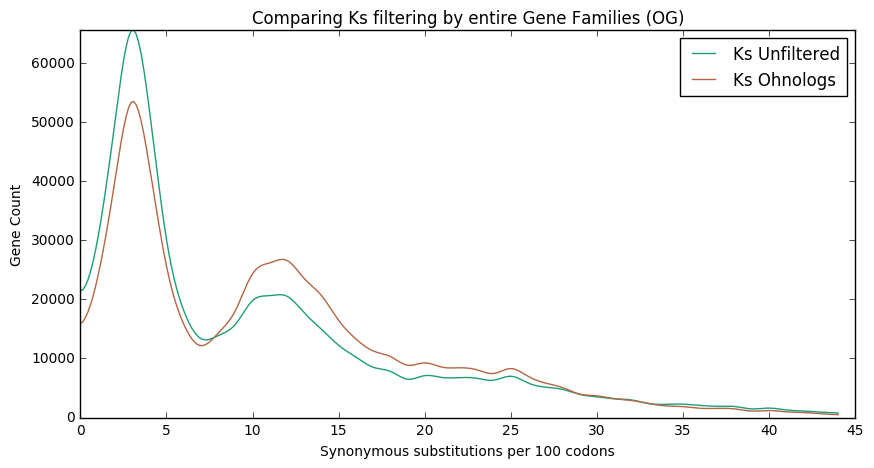

In [276]:
study_og_Ks   = [stats['ks_ratio']       for og, stats in ohnolog_indiv_stats.items()]
categorical_histogram('Comparing Ks filtering by entire Gene Families (OG)', 
                      {'Ks Ohnologs': [int(y*100) for y in study_og_Ks],
                      'Ks Unfiltered': [int(y*100) for y in ks_vals_all[:len(study_og_Ks)]]}, xmax=45,
                      y_title='Gene Count',
                      x_title='Synonymous substitutions per 100 codons')

**Conclusion:** Enrichment in second peak is looking better, but we still have that dominant first peak that indicates many comparisons are being made ebtween closely related genes.

### Ensuring all comparisons made are across a left-right ohnolog subtree split

* Read Genes 1	Genes 2 directly from Duplications.csv
* use `study_ohnologs` to filter rows to pay attention to

In [181]:
Dcsv = read_csv("Ash_Proteome\Results_Jun25\Orthologues_Jul04_2\Duplications.csv", delimiter='\t')
Dcsv[Dcsv['Orthogroup'].isin(list(study_ohnologs)[:10]) & (Dcsv['Species Tree Node'] == 'N1')]

,Orthogroup,Species Tree Node,Gene Tree Node,Support,Type,Genes 1,Genes 2
42622,OG0003148,N1,n3,0.903226,Shared,"FRAX27_FRAX27_000023640.1_R1, FRAX11_FRAX11_00...","FRAX31_FRAX31_000023640.1_R0, FRAX25_FRAX25_00..."
55841,OG0005336,N1,n1,0.903226,Shared,"FRAX07_FRAX07_000070410.1_R0, FRAX28_FRAX28_00...","Oeuropea_OE6A055384P3, FRAX21_FRAX21_000070410..."
64026,OG0007385,N1,n0,0.774194,Shared,"FRAX03_FRAX03_000189250.1_R4, FRAX26_FRAX26_00...","Oeuropea_OE6A104718P1, FRAX20_FRAX20_000189250..."
67430,OG0008222,N1,n2,0.677419,Shared,"FRAX14_FRAX14_000055650.1_R1, FRAX07_FRAX07_00...","FRAX00_FRAEX38873_v2_000055650.1, FRAX16_FRAX1..."
70954,OG0009072,N1,n1,0.580645,Shared,"FRAX26_FRAX26_000096710.1_R0, FRAX13_FRAX13_00...","FRAX30_FRAX30_000096710.1_R1, Oeuropea_OE6A013..."
76189,OG0010265,N1,n4,0.419355,Shared,"FRAX31_FRAX31_000122420.1_R1, FRAX25_FRAX25_00...","Oeuropea_OE6A005445P3, Oeuropea_OE6A110455P2, ..."
79742,OG0011115,N1,n0,0.354839,Shared,"FRAX12_FRAX12_000145640.1_R3, FRAX04_FRAX04_00...","Oeuropea_OE6A117865P1, FRAX13_FRAX13_000145640..."
80786,OG0011379,N1,n5,0.096774,Shared,"FRAX26_FRAX26_000318660.1_R1, FRAX09_FRAX09_00...","Oeuropea_OE6A095937P2, FRAX34_FRAX34_000318660..."
87338,OG0014338,N1,n2,0.161290,Shared,"Oeuropea_OE6A020614P1, FRAX25_FRAX25_000130510...","Oeuropea_OE6A040789P1, FRAX02_FRAX02_000130510..."
95285,OG0020234,N1,n3,0.032258,Shared,Oeuropea_OE6A069029P1,"FRAX02_FRAX02_000254980.1_R5, Oeuropea_OE6A069..."


In [184]:
def left_right_from_og(og, df, node_name='N1'):
    focus = df[(df['Orthogroup'] == og) & (df['Species Tree Node'] == node_name)]
    row = next(focus.iterrows())[1]
    return {'left': row['Genes 1'].split(', '), 'right':row['Genes 2'].split(', ')}

left_right_from_og('OG0014338', Dcsv)

{'left': ['Oeuropea_OE6A020614P1',
  'FRAX25_FRAX25_000130510.1_R0',
  'FRAX33_FRAX33_000130510.1_R0',
  'FRAX09_FRAX09_000130510.1_R0',
  'FRAX05_FRAX05_000130510.1_R0',
  'FRAX06_FRAX06_000130510.1_R0',
  'FRAX16_FRAX16_000130510.1_R0',
  'FRAX00_FRAEX38873_v2_000130510.1',
  'FRAX15_FRAX15_000130510.1_R0',
  'FRAX23_FRAX23_000130510.1_R0',
  'FRAX20_FRAX20_000130510.1_R0',
  'FRAX19_FRAX19_000130510.1_R0',
  'FRAX27_FRAX27_000130510.1_R0',
  'FRAX04_FRAX04_000130510.1_R0',
  'FRAX11_FRAX11_000130510.1_R0',
  'FRAX32_FRAX32_000130510.1_R0',
  'FRAX28_FRAX28_000130510.1_R0',
  'FRAX30_FRAX30_000130510.1_R0',
  'FRAX07_FRAX07_000130510.1_R0',
  'FRAX12_FRAX12_000130510.1_R0',
  'FRAX29_FRAX29_000130510.1_R0',
  'FRAX31_FRAX31_000130510.1_R0'],
 'right': ['Oeuropea_OE6A040789P1',
  'FRAX02_FRAX02_000130510.1_R2',
  'FRAX08_FRAX08_000187860.1_R1',
  'FRAX14_FRAX14_000130510.1_R3',
  'FRAX05_FRAX05_000130510.1_R3',
  'FRAX28_FRAX28_000130510.1_R1',
  'FRAX06_FRAX06_000130510.1_R1',
  'FRA

In [192]:
i = set(og_prot.keys()).intersection(study_ohnologs)
[x for x in (study_ohnologs - i)]

['OG0022799']

**Note:** OG0022799 is excluded because it had only 1 Fexc gene and Olea

In [193]:
study_ohnologs.remove('OG0022799')

In [194]:
dna_msa = {og_name: dna_aligned_OG(og_name) for og_name in study_ohnologs}

d:\josiah\projects\jupyter\lib\site-packages\Bio\Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [209]:
type(study_ohnologs)

set

In [201]:
def ks_subtree_cross_combinations():
    subtree_cross_combinations = {}
    failed_fetch = 0
    for og in study_ohnologs:
        subtrees = left_right_from_og(og, Dcsv)
        combinations = [(a,b) for a in subtrees['left'] for b in subtrees['right']]
        for pair in combinations:
            # grab sequences
            try:
                lgene = dna_msa[og][pair[0]]
                rgene = dna_msa[og][pair[1]]
                subtree_cross_combinations[pair] = ks_stats(lgene, rgene)
            except KeyError:
                failed_fetch += 1
    print(failed_fetch, 'failed sequence fetches (probably FRAX00)') # pp(failed_fetch / 542170)
    return subtree_cross_combinations
subtree_cross_combinations = ks_subtree_cross_combinations()
len(subtree_cross_combinations)

217913 failed sequence fetches (probably FRAX00)


2298963

In [ ]:
combin_4DTv = [stats['fourfold_ratio'] for og, stats in subtree_cross_combinations.items()]

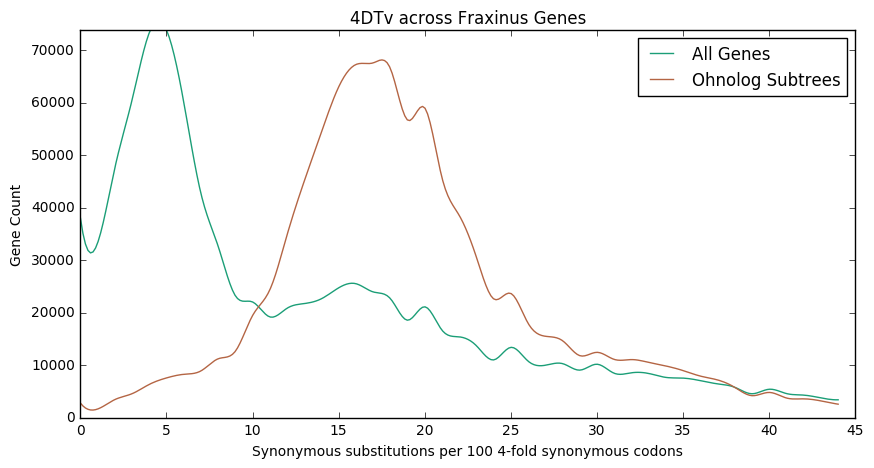

In [282]:
categorical_histogram('4DTv across Fraxinus Genes', 
                      {'Ohnolog Subtrees': [int(y*100) for y in combin_4DTv[:len(four_folds_all)]],
                      'All Genes': [int(y*100) for y in four_folds_all[:len(combin_4DTv)]]}, xmax=45,
                      y_title='Gene Count',
                     x_title='Synonymous substitutions per 100 4-fold synonymous codons')

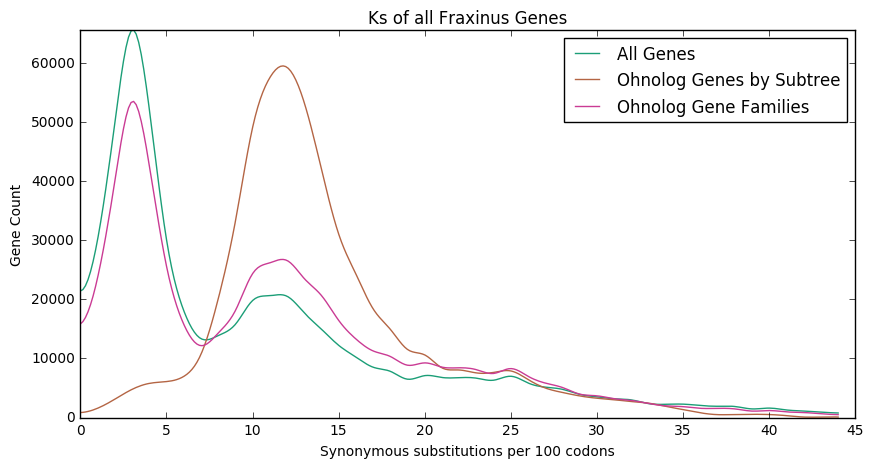

In [280]:
combin_Ks   = [stats['ks_ratio']       for og, stats in subtree_cross_combinations.items()]
categorical_histogram('Ks of all Fraxinus Genes', 
                      {'Ohnolog Genes by Subtree': [int(y*100) for y in combin_Ks[:len(study_og_Ks)]],
                      'Ohnolog Gene Families': [int(y*100) for y in study_og_Ks],
                      'All Genes': [int(y*100) for y in ks_vals_all[:len(study_og_Ks)]]}, xmax=45,
                      y_title='Gene Count',
                      x_title='Synonymous substitutions per 100 codons')

### Conclusion: You must filter by particular gene names in an ohnolog subtree to get clear separation by Ks and 4DTv.  This subtree filtered set is consistently the sam age.

**Where to from here?  Mixture Models?**

In [222]:
len(combin_Ks)

2298963

### Check if combinatorial comparisons is inflating the results

In [27]:
class LoopList(list):
    def __getitem__(self, index):
        index = index % len(self)
        return super(LoopList, self).__getitem__(index)

In [237]:
def ks_subtree_cross_singles():
    subtree_crosses = {}
    failed_fetch = 0
    for og in study_ohnologs:
        subtrees = left_right_from_og(og, Dcsv)
        #Using LoopLists ensures that each gene gets 1 comparison in the dataset
        left, right = LoopList(subtrees['left']), LoopList(subtrees['right'])
        m_length = max(len(subtrees['left']), len(subtrees['right']))
        single_matches = [(left[i], right[i]) for i in range(m_length)]
        for pair in single_matches:
            # grab sequences
            try:
                lgene = dna_msa[og][pair[0]]
                rgene = dna_msa[og][pair[1]]
                subtree_crosses[pair] = ks_stats(lgene, rgene)
            except KeyError:
                failed_fetch += 1
    print(failed_fetch, 'failed sequence fetches (probably FRAX00)') # pp(failed_fetch / 542170)
    return subtree_crosses
subtree_cross_singles = ks_subtree_cross_singles()
len(subtree_cross_singles)

18178 failed sequence fetches (probably FRAX00)


110214

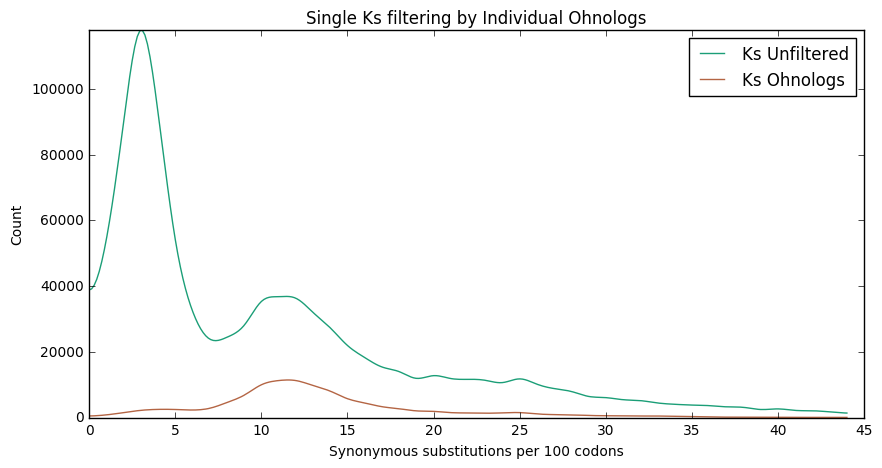

In [268]:
single_Ks   = [stats['ks_ratio']       for og, stats in subtree_cross_singles.items()]
categorical_histogram('Single Ks filtering by Individual Ohnologs', 
                      {'Ks Ohnologs': [int(y*100) for y in single_Ks],
                      'Ks Unfiltered': [int(y*100) for y in ks_vals_all[:]]}, xmax=45,
                     x_title='Synonymous substitutions per 100 codons')

#### Question: How does one define "conservation of mass" for pairwise comparisons?  How many genes am I comparing?  This graph looks like the subtree filtering only pull out ~20% of the total Ohnologs.

-----------------------

# Ks plots for Individual Species
Do different species show different divergence rates?

In [184]:
def collect_stats_for_all_valid_pairs(paralogs_by_species):
    too_short = 0
    stats_paralogs_by_species = {}
    rejected_pairs = set()
    for species, pairs in paralogs_by_species.items():
        current_species = {}
        for pair in pairs:
            try:
                stats = count_synonymous_sites(pair[0].seq, pair[1].seq)
                if stats['opportunities'] >= 100:
                    current_species[(pair[0].name, pair[1].name)] = stats
                else:
                    too_short += 1
            except ValueError as e:
                rejected_pairs.add(pair)
#             if len(current_species) > 10:
#                 break
        stats_paralogs_by_species[species] = current_species
    rejected = len(rejected_pairs)
    total_pairs_processed = sum([len(pairs) for pairs in paralogs_by_species.values()])
    print("total_pairs_processed", total_pairs_processed, "rejected", rejected, "too_short", too_short)
    print(pp((total_pairs_processed - too_short - rejected)/ total_pairs_processed), " of pairs were valid")
    return stats_paralogs_by_species, rejected_pairs
stat_pairs_by_species, rejected_pairs = collect_stats_for_all_valid_pairs(paralogs_by_species)
    

first(first(stat_pairs_by_species)[1])

total_pairs_processed 760951 rejected 36 too_short 56
99.987910%  of pairs were valid


(('FRAX16_FRAX16_000045390.1_R0', 'FRAX16_FRAX16_000018570.1_R0'),
 {'four_fold_changes': 38,
  'four_fold_opportunities': 118,
  'nonsynonymous': 15,
  'opportunities': 244,
  'same': 165,
  'synonymous': 64})

In [183]:
first(stat_pairs_by_species)

('FRAX16',
 {('FRAX16_FRAX16_000045390.1_R0',
   'FRAX16_FRAX16_000018570.1_R0'): {'four_fold_changes': 38, 'four_fold_opportunities': 118, 'nonsynonymous': 15, 'opportunities': 244, 'same': 165, 'synonymous': 64},
  ('FRAX16_FRAX16_000077340.1_R1',
   'FRAX16_FRAX16_000077340.1_R0'): {'four_fold_changes': 59, 'four_fold_opportunities': 197, 'nonsynonymous': 69, 'opportunities': 541, 'same': 336, 'synonymous': 136},
  ('FRAX16_FRAX16_000096300.1_R0',
   'FRAX16_FRAX16_000096300.1_R1'): {'four_fold_changes': 26, 'four_fold_opportunities': 82, 'nonsynonymous': 43, 'opportunities': 200, 'same': 105, 'synonymous': 52},
  ('FRAX16_FRAX16_000140350.1_R4',
   'FRAX16_FRAX16_000140350.1_R0'): {'four_fold_changes': 5, 'four_fold_opportunities': 79, 'nonsynonymous': 22, 'opportunities': 240, 'same': 204, 'synonymous': 14},
  ('FRAX16_FRAX16_000208250.1_R3',
   'FRAX16_FRAX16_000017570.1_R4'): {'four_fold_changes': 5, 'four_fold_opportunities': 64, 'nonsynonymous': 37, 'opportunities': 134, 'same

In [187]:
gene_to_og['FRAX16_FRAX16_000398870.1_R1']

'OG0006842'

In [188]:
dna_aligned_OG('OG0006842')

{'FRAX00_FRAEX38873_v2_000398870.1': '------------------------------------------ATGGCATTTACCTCTGCTTTCCGTCGCATTCTGAGCGGATCTTCTACGCCTTCGCCGATTTTTCGCTCACAAATCGCATGGATTCGCCACAGTTCTACC------TTCCCTACGCTCACCAGTCCTAAGCTTTTCATTAGCGGTATATCAAAAAATACAACTGATGAAAGTCTTTTCAACGCGTTTGCACCATTTGGAAGGCTTCTTGACTCAAAAGTG------ATCATGGATCGAGGTTCTGGAAAACCAAAGGGGTTTGGTTTTATTACTTATGAAACAGTAGACGAAGCTGAGAAAGCTCGGGAAGAAATGAATGCCAAGTACCTGGATGGTTGGGTAATTTTTGTTGATCCAGCAAGGCCTAGGGAG---CTTCCTCCTCCACCTCGACAATCTCCTCAACAAGACCTACAGCTCAATCCAAAGCCTACTGAAAGTCTC---TTTGCGACTAACAGGACTTTAGGA------TGGTCTGGT------',
 'FRAX01_FRAX01_000398870.1_R0': '------------------------------------------ATGGCATTTACCTCTGCTTTCCGTCGTATTCTGAGCGGATCTTCTACGCCTTCGCCGATTTTTCGCTCACAAATCGCATGGATTCGCCACAGTTCTACC------CTCCCTACGCTCACCAGTCCTAAACTTTTCATTAGCGGTATATCAAAAAATACAACTGATGAAAGTCTTTTCAACGCGTTTGCACCATTTGGAAGGCTTCTTGACTCAAAAGTG------ATCATGGATCGAGGTTCTGGAAAACCAAAGGGGTTTGGTTTTATTACTTATGAAACAGTAGAAGAAGCTGAGAAAGCTCGGGAAGAAATGAATGCCAAGTACCTGGATGGTTGGGTAATTTTTG

In [203]:
from Bio import AlignIO, SeqIO, Phylo
OG0006842 = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ogs\Jun25\Sequences\aligned\for_study\OG0006842.fa"
OG0006842_seq = [record for record in SeqIO.parse(OG0006842, "fasta")]
SeqIO.write(OG0006842_seq, "OG0006842.nuc", 'phylip-relaxed')

59

In [207]:
species_tree = Phylo.read(r"Ogs\Orthologues_Jul04_2\Species_tree_corrected_root_added_02_34.tre", 'newick')
Phylo.write(species_tree, r"Ash_Proteome\PAML\data\species_tree.trees", 'nexus')

1

In [208]:
import pickle
with open('stat_pairs_by_species.pickle', 'wb') as handle:
    pickle.dump(stat_pairs_by_species, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [211]:
sum([len(pairs) for pairs in stat_pairs_by_species.values()])

308

# Ohnolog % for pan genome of Fraxinus

In [30]:
in_paralogs = defaultdict(lambda: set())  #{'FRAX00': {'GeneA', 'GeneB'}}
in_paralog_scores = defaultdict(lambda: dict())  #{'FRAX00': {('GeneA', 'GeneB'): 0.24}}
for species in 'FRAX00 FRAX01 FRAX02 FRAX03 FRAX04 FRAX05 FRAX06 FRAX07 FRAX08 FRAX09 FRAX11 FRAX12 FRAX13 FRAX14 FRAX15 FRAX16 FRAX19 FRAX20 FRAX21 FRAX23 FRAX25 FRAX26 FRAX27 FRAX28 FRAX29 FRAX30 FRAX31 FRAX32 FRAX33 FRAX34'.split():
    for og_name, msa in dna_msa.items():
        paralogs = [gene_name for gene_name in msa.keys() if gene_name.startswith(species)]
        if len(paralogs) > 1:
            for x, gene_a in enumerate(paralogs):
                for gene_b in paralogs[x+1:]:
                    scores = ks_stats(msa[gene_a], msa[gene_b])
                    in_paralog_scores[species][(gene_a, gene_b)] = scores
                    if .09 < scores['ks_ratio'] < .2 or .15 < scores['fourfold_ratio'] < .25:
                        in_paralogs[species].add(gene_a)
                        in_paralogs[species].add(gene_b)

In [45]:
print("FRAX00 has at minimum ", pp(len(in_paralogs['FRAX00']) / 34000), "of genes are Ohnologs")
print(pp(len(ohnolog_gene_set) / (33000 * 30)), "of genes in pan-genome are listed in an OG containing an ohnolog.",
     "This is an upper bound on genes that could be discovered through orthology transfer in the pan-genome.")


FRAX00 has at minimum  15.617647% of genes are Ohnologs
58.534040% of genes in pan-genome are listed in an OG containing an ohnolog. This is an upper bound on genes that could be discovered through orthology transfer in the pan-genome.


In order to include all genes, we need to go back to a file like the GFFs containing all gene annotations.

# SCRAP